## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


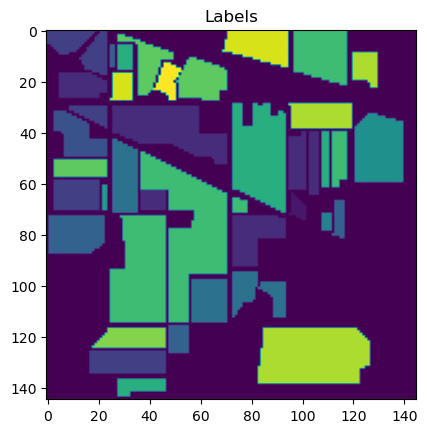

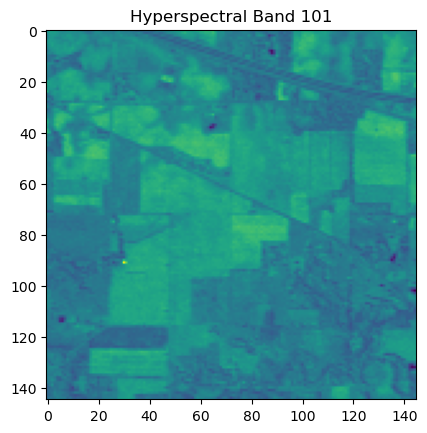

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(160, 5, 5, 200)
(80, 5, 5, 200)
(10009, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0779, PSNR: 10.7077


Epoch [1/50] Training Loss: 0.0638, PSNR: 11.4893
	[Val]   Batch [1/33] Loss: 0.0483, PSNR: 12.8276
	[Val]   Batch [10/33] Loss: 0.0475, PSNR: 12.4990
	[Val]   Batch [20/33] Loss: 0.0472, PSNR: 12.0884
	[Val]   Batch [30/33] Loss: 0.0461, PSNR: 12.4393
Epoch [1/50] Validation Loss: 0.0479, PSNR: 12.6508

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0495, PSNR: 12.7189


Epoch [2/50] Training Loss: 0.0389, PSNR: 13.6828
	[Val]   Batch [1/33] Loss: 0.0284, PSNR: 15.1240
	[Val]   Batch [10/33] Loss: 0.0280, PSNR: 14.7980
	[Val]   Batch [20/33] Loss: 0.0277, PSNR: 14.4035
	[Val]   Batch [30/33] Loss: 0.0270, PSNR: 14.7612
Epoch [2/50] Validation Loss: 0.0284, PSNR: 14.9265

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0283, PSNR: 15.4867


Epoch [3/50] Training Loss: 0.0230, PSNR: 15.9580
	[Val]   Batch [1/33] Loss: 0.0174, PSNR: 17.2552
	[Val]   Batch [10/33] Loss: 0.0170, PSNR: 16.9682
	[Val]   Batch [20/33] Loss: 0.0167, PSNR: 16.6000
	[Val]   Batch [30/33] Loss: 0.0163, PSNR: 16.9576
Epoch [3/50] Validation Loss: 0.0174, PSNR: 17.0570

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0177, PSNR: 16.9988


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0358
	[Val]   Batch [1/33] Loss: 0.0114, PSNR: 19.1004
	[Val]   Batch [10/33] Loss: 0.0109, PSNR: 18.8781
	[Val]   Batch [20/33] Loss: 0.0107, PSNR: 18.5486
	[Val]   Batch [30/33] Loss: 0.0104, PSNR: 18.9190
Epoch [4/50] Validation Loss: 0.0113, PSNR: 18.9130

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0109, PSNR: 19.4202


Epoch [5/50] Training Loss: 0.0096, PSNR: 19.7302
	[Val]   Batch [1/33] Loss: 0.0083, PSNR: 20.4869
	[Val]   Batch [10/33] Loss: 0.0078, PSNR: 20.3250
	[Val]   Batch [20/33] Loss: 0.0076, PSNR: 20.0324
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.3965
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2996

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0089, PSNR: 20.1410


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0201
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6130
	[Val]   Batch [10/33] Loss: 0.0059, PSNR: 21.5247
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2732
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6431
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4350

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0064, PSNR: 21.4409


Epoch [7/50] Training Loss: 0.0057, PSNR: 22.0204
	[Val]   Batch [1/33] Loss: 0.0052, PSNR: 22.4814
	[Val]   Batch [10/33] Loss: 0.0048, PSNR: 22.4632
	[Val]   Batch [20/33] Loss: 0.0046, PSNR: 22.2455
	[Val]   Batch [30/33] Loss: 0.0044, PSNR: 22.6182
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.3139

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0054, PSNR: 22.6892


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8376
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2654
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.3324
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1528
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.5396
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.1223

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0039, PSNR: 23.7147


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5423
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9929
	[Val]   Batch [10/33] Loss: 0.0032, PSNR: 24.1625
	[Val]   Batch [20/33] Loss: 0.0030, PSNR: 24.0220
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.4450
Epoch [9/50] Validation Loss: 0.0036, PSNR: 23.8944

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 24.0642


Epoch [10/50] Training Loss: 0.0035, PSNR: 24.1643
	[Val]   Batch [1/33] Loss: 0.0032, PSNR: 24.5504
	[Val]   Batch [10/33] Loss: 0.0028, PSNR: 24.8285
	[Val]   Batch [20/33] Loss: 0.0026, PSNR: 24.7289
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.1642
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.5102

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0032, PSNR: 24.5743


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.7270
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.1142
	[Val]   Batch [10/33] Loss: 0.0024, PSNR: 25.4708
	[Val]   Batch [20/33] Loss: 0.0022, PSNR: 25.4097
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.8579
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.1183

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.6258


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.2005
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5301
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 25.9668
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 25.9511
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4088
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5826

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.4211


Epoch [13/50] Training Loss: 0.0025, PSNR: 25.6568
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.8589
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.3220
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3284
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.8484
Epoch [13/50] Validation Loss: 0.0023, PSNR: 25.9325

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 26.1487


Epoch [14/50] Training Loss: 0.0023, PSNR: 26.0178
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.3762
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9089
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 26.9646
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.4988
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4938

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.5836


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.3209
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6426
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.1454
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.2020
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.7518
Epoch [15/50] Validation Loss: 0.0019, PSNR: 26.7430

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 26.0022


Epoch [16/50] Training Loss: 0.0020, PSNR: 26.6810
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9209
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.3673
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.4205
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0116
Epoch [16/50] Validation Loss: 0.0018, PSNR: 27.0012

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.9305


Epoch [17/50] Training Loss: 0.0018, PSNR: 27.0017
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.4994
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 27.9739
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0606
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6723
Epoch [17/50] Validation Loss: 0.0016, PSNR: 27.5980

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.6262


Epoch [18/50] Training Loss: 0.0017, PSNR: 27.2901
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8275
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.2143
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.3076
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9437
Epoch [18/50] Validation Loss: 0.0015, PSNR: 27.8897

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.5484


Epoch [19/50] Training Loss: 0.0016, PSNR: 27.6835
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.3625
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7189
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8025
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.5138
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.4195

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.6666


Epoch [20/50] Training Loss: 0.0014, PSNR: 27.9766
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.8710
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1655
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2911
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9730
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.9024

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.2761


Epoch [21/50] Training Loss: 0.0014, PSNR: 28.2487
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.0846
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3472
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4842
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2086
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1182

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.7645


Epoch [22/50] Training Loss: 0.0013, PSNR: 28.5358
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5587
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7683
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9155
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6237
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5767

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.0768


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8149
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7479
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9323
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1221
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8442
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.7809

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.3664


Epoch [24/50] Training Loss: 0.0011, PSNR: 28.9960
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0458
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2298
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4544
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1174
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.0708

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.8299


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2136
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2982
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4567
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7144
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4721
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3418

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.6106


Epoch [26/50] Training Loss: 0.0011, PSNR: 29.3486
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4793
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6767
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9653
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7251
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5581

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.0071


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.4923
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6315
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8290
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1353
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.8886
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.7178

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.4853


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.5883
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.7184
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9477
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2712
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0196
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.8265

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0008, PSNR: 30.6409


Epoch [29/50] Training Loss: 0.0010, PSNR: 29.7437
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 30.9689
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.1209
	[Val]   Batch [20/33] Loss: 0.0005, PSNR: 31.4684
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.2371
Epoch [29/50] Validation Loss: 0.0007, PSNR: 31.0473

LOG: Epoch [30/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.5350


Epoch [30/50] Training Loss: 0.0009, PSNR: 29.8308
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8441
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.0046
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.3078
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0783
Epoch [30/50] Validation Loss: 0.0007, PSNR: 30.9205
Early stopping triggered at epoch 30. No improvement for 3 epochs.


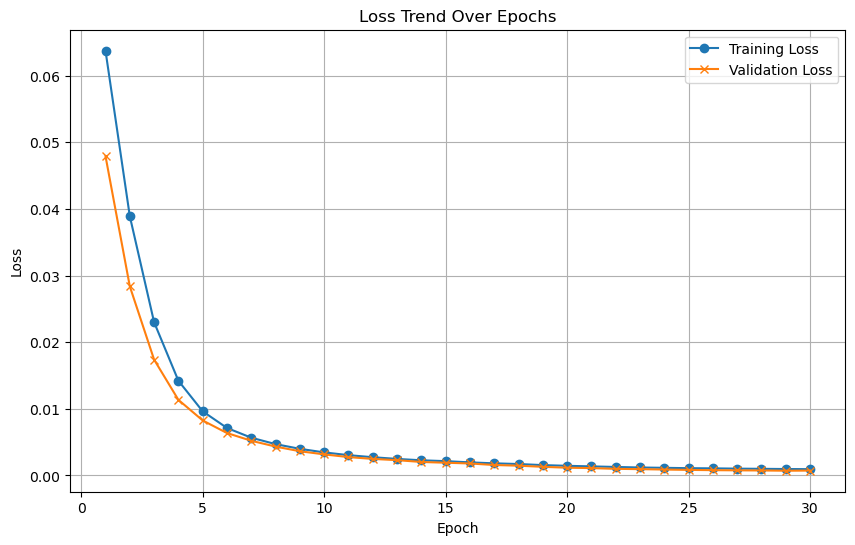

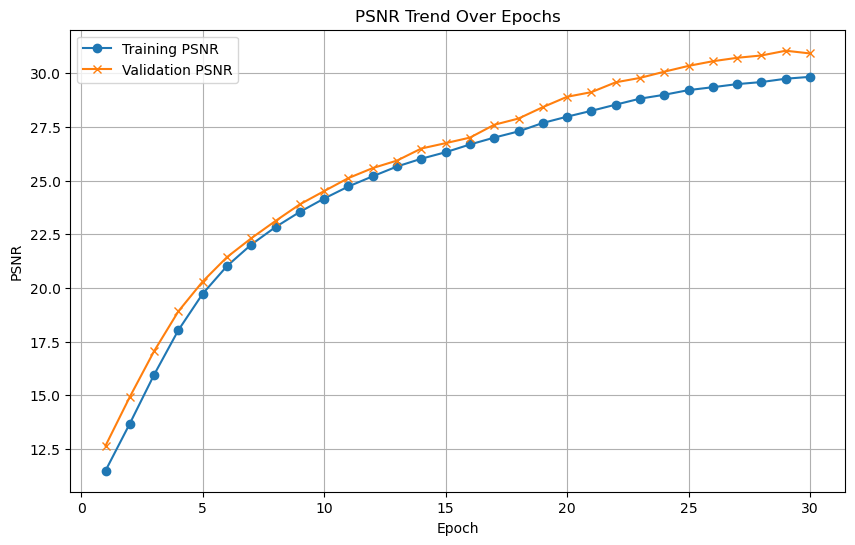

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7908
    Validation Batch [1/1], Loss: 2.7777
Validation Loss: 2.7777, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7777. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7679
    Validation Batch [1/1], Loss: 2.7777
Validation Loss: 2.7777, Validation Accuracy: 6.25%
Validation loss improved from 2.7777 to 2.7777. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7487
    Validation Batch [1/1], Loss: 2.7776
Validation Loss: 2.7776, Validation Accuracy: 6.25%
Validation loss improved from 2.7777 to 2.7776. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7281
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss improved from 2.7776 to 2.7775. Saving model...

LOG: Epoch [5/1000] - 

Epoch [10/1000] completed, Average Training Loss: 2.6646
    Validation Batch [1/1], Loss: 2.7771
Validation Loss: 2.7771, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7771. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6396
    Validation Batch [1/1], Loss: 2.7771
Validation Loss: 2.7771, Validation Accuracy: 6.25%
Validation loss improved from 2.7771 to 2.7771. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6407
    Validation Batch [1/1], Loss: 2.7770
Validation Loss: 2.7770, Validation Accuracy: 6.25%
Validation loss improved from 2.7771 to 2.7770. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6383
    Validation Batch [1/1], Loss: 2.7770
Validation Loss: 2.7770, Validation Accuracy: 6.25%
Validation loss improved from 2.7770 to 2.7770. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/10

Epoch [22/1000] completed, Average Training Loss: 2.5257
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.5269
    Validation Batch [1/1], Loss: 2.7766
Validation Loss: 2.7766, Validation Accuracy: 6.25%
Validation loss improved from 2.7769 to 2.7766. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.5052
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 6.25%
Validation loss improved from 2.7766 to 2.7762. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.4848
    Validation Batch [1/1], Loss: 2.7756
Validation Loss: 2.7756, Validation Accuracy: 6.25%
Validation loss improved from 2.7762 to 2.7756. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, 

Epoch [37/1000] completed, Average Training Loss: 2.3829
    Validation Batch [1/1], Loss: 2.7568
Validation Loss: 2.7568, Validation Accuracy: 13.75%
Validation loss improved from 2.7585 to 2.7568. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.3650
    Validation Batch [1/1], Loss: 2.7537
Validation Loss: 2.7537, Validation Accuracy: 16.25%
Validation loss improved from 2.7568 to 2.7537. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.3523
    Validation Batch [1/1], Loss: 2.7508
Validation Loss: 2.7508, Validation Accuracy: 12.50%
Validation loss improved from 2.7537 to 2.7508. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3623
    Validation Batch [1/1], Loss: 2.7483
Validation Loss: 2.7483, Validation Accuracy: 7.50%
Validation loss improved from 2.7508 to 2.7483. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41

Epoch [48/1000] completed, Average Training Loss: 2.2397
    Validation Batch [1/1], Loss: 2.7041
Validation Loss: 2.7041, Validation Accuracy: 8.75%
Validation loss improved from 2.7142 to 2.7041. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2712
    Validation Batch [1/1], Loss: 2.6920
Validation Loss: 2.6920, Validation Accuracy: 8.75%
Validation loss improved from 2.7041 to 2.6920. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2676
    Validation Batch [1/1], Loss: 2.6771
Validation Loss: 2.6771, Validation Accuracy: 8.75%
Validation loss improved from 2.6920 to 2.6771. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.2356
    Validation Batch [1/1], Loss: 2.6559
Validation Loss: 2.6559, Validation Accuracy: 11.25%
Validation loss improved from 2.6771 to 2.6559. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1

Epoch [64/1000] completed, Average Training Loss: 2.1133
    Validation Batch [1/1], Loss: 2.3950
Validation Loss: 2.3950, Validation Accuracy: 36.25%
Validation loss improved from 2.4233 to 2.3950. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1217
    Validation Batch [1/1], Loss: 2.3846
Validation Loss: 2.3846, Validation Accuracy: 40.00%
Validation loss improved from 2.3950 to 2.3846. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.0997
    Validation Batch [1/1], Loss: 2.3610
Validation Loss: 2.3610, Validation Accuracy: 41.25%
Validation loss improved from 2.3846 to 2.3610. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.0927
    Validation Batch [1/1], Loss: 2.3285
Validation Loss: 2.3285, Validation Accuracy: 40.00%
Validation loss improved from 2.3610 to 2.3285. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [6

Epoch [76/1000] completed, Average Training Loss: 1.9932
    Validation Batch [1/1], Loss: 2.2179
Validation Loss: 2.2179, Validation Accuracy: 46.25%
Validation loss improved from 2.2310 to 2.2179. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9998
    Validation Batch [1/1], Loss: 2.2101
Validation Loss: 2.2101, Validation Accuracy: 42.50%
Validation loss improved from 2.2179 to 2.2101. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.9935
    Validation Batch [1/1], Loss: 2.2112
Validation Loss: 2.2112, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.9711
    Validation Batch [1/1], Loss: 2.1957
Validation Loss: 2.1957, Validation Accuracy: 45.00%
Validation loss improved from 2.2101 to 2.1957. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] complet

Epoch [91/1000] completed, Average Training Loss: 1.8922
    Validation Batch [1/1], Loss: 2.1006
Validation Loss: 2.1006, Validation Accuracy: 53.75%
Validation loss improved from 2.1040 to 2.1006. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.9147
    Validation Batch [1/1], Loss: 2.1007
Validation Loss: 2.1007, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.8621
    Validation Batch [1/1], Loss: 2.0936
Validation Loss: 2.0936, Validation Accuracy: 51.25%
Validation loss improved from 2.1006 to 2.0936. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.8557
    Validation Batch [1/1], Loss: 2.0934
Validation Loss: 2.0934, Validation Accuracy: 50.00%
Validation loss improved from 2.0936 to 2.0934. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] complet

    Validation Batch [1/1], Loss: 2.0694
Validation Loss: 2.0694, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.7680
    Validation Batch [1/1], Loss: 2.0788
Validation Loss: 2.0788, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.7889
    Validation Batch [1/1], Loss: 2.0231
Validation Loss: 2.0231, Validation Accuracy: 55.00%
Validation loss improved from 2.0471 to 2.0231. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.7423
    Validation Batch [1/1], Loss: 2.0299
Validation Loss: 2.0299, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.7961
    Validation Batch [1/1], Loss: 2.0482
Vali

Epoch [119/1000] completed, Average Training Loss: 1.6662
    Validation Batch [1/1], Loss: 1.9386
Validation Loss: 1.9386, Validation Accuracy: 58.75%
Validation loss improved from 1.9449 to 1.9386. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.7097
    Validation Batch [1/1], Loss: 1.9391
Validation Loss: 1.9391, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.6933
    Validation Batch [1/1], Loss: 1.9334
Validation Loss: 1.9334, Validation Accuracy: 57.50%
Validation loss improved from 1.9386 to 1.9334. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6585
    Validation Batch [1/1], Loss: 1.9244
Validation Loss: 1.9244, Validation Accuracy: 61.25%
Validation loss improved from 1.9334 to 1.9244. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000

Epoch [130/1000] completed, Average Training Loss: 1.6313
    Validation Batch [1/1], Loss: 1.8857
Validation Loss: 1.8857, Validation Accuracy: 58.75%
Validation loss improved from 1.8907 to 1.8857. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.5936
    Validation Batch [1/1], Loss: 1.8768
Validation Loss: 1.8768, Validation Accuracy: 60.00%
Validation loss improved from 1.8857 to 1.8768. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.5946
    Validation Batch [1/1], Loss: 1.9032
Validation Loss: 1.9032, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.5697
    Validation Batch [1/1], Loss: 1.8536
Validation Loss: 1.8536, Validation Accuracy: 53.75%
Validation loss improved from 1.8768 to 1.8536. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000

Epoch [146/1000] completed, Average Training Loss: 1.4786
    Validation Batch [1/1], Loss: 1.8717
Validation Loss: 1.8717, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.5064
    Validation Batch [1/1], Loss: 1.8121
Validation Loss: 1.8121, Validation Accuracy: 57.50%
Validation loss improved from 1.8328 to 1.8121. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4775
    Validation Batch [1/1], Loss: 1.7946
Validation Loss: 1.7946, Validation Accuracy: 56.25%
Validation loss improved from 1.8121 to 1.7946. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4713
    Validation Batch [1/1], Loss: 1.7750
Validation Loss: 1.7750, Validation Accuracy: 60.00%
Validation loss improved from 1.7946 to 1.7750. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000

Epoch [155/1000] completed, Average Training Loss: 1.4396
    Validation Batch [1/1], Loss: 1.7649
Validation Loss: 1.7649, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.4236
    Validation Batch [1/1], Loss: 1.7722
Validation Loss: 1.7722, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.4218
    Validation Batch [1/1], Loss: 1.7978
Validation Loss: 1.7978, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.3798
    Validation Batch [1/1], Loss: 1.7716
Validation Loss: 1.7716, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.4274
  

    Validation Batch [1/1], Loss: 1.7439
Validation Loss: 1.7439, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.3355
    Validation Batch [1/1], Loss: 1.7409
Validation Loss: 1.7409, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.2924
    Validation Batch [1/1], Loss: 1.6978
Validation Loss: 1.6978, Validation Accuracy: 61.25%
Validation loss improved from 1.7175 to 1.6978. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.3064
    Validation Batch [1/1], Loss: 1.6713
Validation Loss: 1.6713, Validation Accuracy: 61.25%
Validation loss improved from 1.6978 to 1.6713. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.2823
    Validation Batch [1/1], Lo

Epoch [180/1000] completed, Average Training Loss: 1.3009
    Validation Batch [1/1], Loss: 1.6505
Validation Loss: 1.6505, Validation Accuracy: 60.00%
Validation loss improved from 1.6661 to 1.6505. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.2600
    Validation Batch [1/1], Loss: 1.6771
Validation Loss: 1.6771, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.2332
    Validation Batch [1/1], Loss: 1.7319
Validation Loss: 1.7319, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.2699
    Validation Batch [1/1], Loss: 1.6613
Validation Loss: 1.6613, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training 

Epoch [197/1000] completed, Average Training Loss: 1.1235
    Validation Batch [1/1], Loss: 1.6107
Validation Loss: 1.6107, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.1333
    Validation Batch [1/1], Loss: 1.5769
Validation Loss: 1.5769, Validation Accuracy: 65.00%
Validation loss improved from 1.5802 to 1.5769. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.1248
    Validation Batch [1/1], Loss: 1.7238
Validation Loss: 1.7238, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 1.1018
    Validation Batch [1/1], Loss: 1.6963
Validation Loss: 1.6963, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training 

Epoch [206/1000] completed, Average Training Loss: 1.0903
    Validation Batch [1/1], Loss: 1.5468
Validation Loss: 1.5468, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 1.1259
    Validation Batch [1/1], Loss: 1.6527
Validation Loss: 1.6527, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 1.0574
    Validation Batch [1/1], Loss: 1.6500
Validation Loss: 1.6500, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0746
    Validation Batch [1/1], Loss: 1.5508
Validation Loss: 1.5508, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0566
  

Epoch [225/1000] completed, Average Training Loss: 1.0006
    Validation Batch [1/1], Loss: 1.5529
Validation Loss: 1.5529, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.9902
    Validation Batch [1/1], Loss: 1.5293
Validation Loss: 1.5293, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.9701
    Validation Batch [1/1], Loss: 1.5252
Validation Loss: 1.5252, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.9356
    Validation Batch [1/1], Loss: 1.5572
Validation Loss: 1.5572, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.9469


Epoch [231/1000] completed, Average Training Loss: 0.9124
    Validation Batch [1/1], Loss: 1.6125
Validation Loss: 1.6125, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.9638
    Validation Batch [1/1], Loss: 1.4292
Validation Loss: 1.4292, Validation Accuracy: 72.50%
Validation loss improved from 1.4886 to 1.4292. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.9140
    Validation Batch [1/1], Loss: 1.5032
Validation Loss: 1.5032, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.9161
    Validation Batch [1/1], Loss: 1.5368
Validation Loss: 1.5368, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training

Epoch [253/1000] completed, Average Training Loss: 0.7840
    Validation Batch [1/1], Loss: 1.3600
Validation Loss: 1.3600, Validation Accuracy: 73.75%
Validation loss improved from 1.3841 to 1.3600. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.7871
    Validation Batch [1/1], Loss: 1.3867
Validation Loss: 1.3867, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.7370
    Validation Batch [1/1], Loss: 1.4237
Validation Loss: 1.4237, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.7819
    Validation Batch [1/1], Loss: 1.4863
Validation Loss: 1.4863, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.4549
Validation Loss: 1.4549, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.7835
    Validation Batch [1/1], Loss: 1.5067
Validation Loss: 1.5067, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.8037
    Validation Batch [1/1], Loss: 1.3613
Validation Loss: 1.3613, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.7350
    Validation Batch [1/1], Loss: 1.4100
Validation Loss: 1.4100, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.7381
    Validation Batch [1/1], Loss: 1.5051
Validation Loss: 1.

Epoch [278/1000] completed, Average Training Loss: 0.6596
    Validation Batch [1/1], Loss: 1.3845
Validation Loss: 1.3845, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.6576
    Validation Batch [1/1], Loss: 1.3318
Validation Loss: 1.3318, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.6782
    Validation Batch [1/1], Loss: 1.4043
Validation Loss: 1.4043, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.6613
    Validation Batch [1/1], Loss: 1.3483
Validation Loss: 1.3483, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.6380

Epoch [285/1000] completed, Average Training Loss: 0.6187
    Validation Batch [1/1], Loss: 1.2962
Validation Loss: 1.2962, Validation Accuracy: 72.50%
Validation loss improved from 1.2986 to 1.2962. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.5893
    Validation Batch [1/1], Loss: 1.2897
Validation Loss: 1.2897, Validation Accuracy: 72.50%
Validation loss improved from 1.2962 to 1.2897. Saving model...

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.6055
    Validation Batch [1/1], Loss: 1.2906
Validation Loss: 1.2906, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.6388
    Validation Batch [1/1], Loss: 1.2641
Validation Loss: 1.2641, Validation Accuracy: 71.25%
Validation loss improved from 1.2897 to 1.2641. Saving model...

LOG: Epoch [289/1000] - Training
Epoch [289/1000

    Validation Batch [1/1], Loss: 1.2241
Validation Loss: 1.2241, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.5480
    Validation Batch [1/1], Loss: 1.2817
Validation Loss: 1.2817, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.5296
    Validation Batch [1/1], Loss: 1.3334
Validation Loss: 1.3334, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.4969
    Validation Batch [1/1], Loss: 1.2832
Validation Loss: 1.2832, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.4838
    Validation Batch [1/1], Loss: 1.2424
Validation Loss: 1.

Epoch [311/1000] completed, Average Training Loss: 0.5223
    Validation Batch [1/1], Loss: 1.2512
Validation Loss: 1.2512, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.5186
    Validation Batch [1/1], Loss: 1.2641
Validation Loss: 1.2641, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.5117
    Validation Batch [1/1], Loss: 1.2136
Validation Loss: 1.2136, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.5211
    Validation Batch [1/1], Loss: 1.2400
Validation Loss: 1.2400, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4851
  

Epoch [331/1000] completed, Average Training Loss: 0.4065
    Validation Batch [1/1], Loss: 1.1421
Validation Loss: 1.1421, Validation Accuracy: 71.25%
Validation loss improved from 1.1500 to 1.1421. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3920
    Validation Batch [1/1], Loss: 1.1686
Validation Loss: 1.1686, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3763
    Validation Batch [1/1], Loss: 1.1559
Validation Loss: 1.1559, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.4061
    Validation Batch [1/1], Loss: 1.1622
Validation Loss: 1.1622, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training 

Epoch [338/1000] completed, Average Training Loss: 0.3871
    Validation Batch [1/1], Loss: 1.2921
Validation Loss: 1.2921, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.4067
    Validation Batch [1/1], Loss: 1.2134
Validation Loss: 1.2134, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.3866
    Validation Batch [1/1], Loss: 1.1992
Validation Loss: 1.1992, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3990
    Validation Batch [1/1], Loss: 1.1659
Validation Loss: 1.1659, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.3443
  

Epoch [357/1000] completed, Average Training Loss: 0.3159
    Validation Batch [1/1], Loss: 1.1817
Validation Loss: 1.1817, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.3349
    Validation Batch [1/1], Loss: 1.2700
Validation Loss: 1.2700, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.2895
    Validation Batch [1/1], Loss: 1.1243
Validation Loss: 1.1243, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.3427
    Validation Batch [1/1], Loss: 1.1826
Validation Loss: 1.1826, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.3009
 

    Validation Batch [1/1], Loss: 1.1786
Validation Loss: 1.1786, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2971
    Validation Batch [1/1], Loss: 1.1865
Validation Loss: 1.1865, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2802
    Validation Batch [1/1], Loss: 1.2006
Validation Loss: 1.2006, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2954
    Validation Batch [1/1], Loss: 1.1292
Validation Loss: 1.1292, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.3076
    Validation Batch [1/1], Loss: 1.2637
Validation Loss

Epoch [385/1000] completed, Average Training Loss: 0.2557
    Validation Batch [1/1], Loss: 1.0846
Validation Loss: 1.0846, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2086
    Validation Batch [1/1], Loss: 1.1292
Validation Loss: 1.1292, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2379
    Validation Batch [1/1], Loss: 1.1214
Validation Loss: 1.1214, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.2378
    Validation Batch [1/1], Loss: 1.0829
Validation Loss: 1.0829, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2448
 

Epoch [392/1000] completed, Average Training Loss: 0.2016
    Validation Batch [1/1], Loss: 1.0965
Validation Loss: 1.0965, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.2354
    Validation Batch [1/1], Loss: 1.0812
Validation Loss: 1.0812, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2237
    Validation Batch [1/1], Loss: 1.0208
Validation Loss: 1.0208, Validation Accuracy: 75.00%
Validation loss improved from 1.0410 to 1.0208. Saving model...

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2454
    Validation Batch [1/1], Loss: 1.1952
Validation Loss: 1.1952, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Trainin

Epoch [412/1000] completed, Average Training Loss: 0.1768
    Validation Batch [1/1], Loss: 1.0732
Validation Loss: 1.0732, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1775
    Validation Batch [1/1], Loss: 1.0525
Validation Loss: 1.0525, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1891
    Validation Batch [1/1], Loss: 1.1122
Validation Loss: 1.1122, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1835
    Validation Batch [1/1], Loss: 1.0625
Validation Loss: 1.0625, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1966
  

    Validation Batch [1/1], Loss: 1.0542
Validation Loss: 1.0542, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1948
    Validation Batch [1/1], Loss: 1.0946
Validation Loss: 1.0946, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1877
    Validation Batch [1/1], Loss: 1.0840
Validation Loss: 1.0840, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1564
    Validation Batch [1/1], Loss: 1.1064
Validation Loss: 1.1064, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1812
    Validation Batch [1/1], Loss: 1.0128
Validation Loss

    Validation Batch [1/1], Loss: 1.0074
Validation Loss: 1.0074, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1536
    Validation Batch [1/1], Loss: 1.0276
Validation Loss: 1.0276, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1732
    Validation Batch [1/1], Loss: 1.0676
Validation Loss: 1.0676, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1412
    Validation Batch [1/1], Loss: 1.1605
Validation Loss: 1.1605, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1609
    Validation Batch [1/1], Loss: 1.0800
Validation Loss

Epoch [446/1000] completed, Average Training Loss: 0.1658
    Validation Batch [1/1], Loss: 1.0325
Validation Loss: 1.0325, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1264
    Validation Batch [1/1], Loss: 1.0192
Validation Loss: 1.0192, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1501
    Validation Batch [1/1], Loss: 0.9821
Validation Loss: 0.9821, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1549
    Validation Batch [1/1], Loss: 0.9750
Validation Loss: 0.9750, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.142

Epoch [465/1000] completed, Average Training Loss: 0.1269
    Validation Batch [1/1], Loss: 0.9556
Validation Loss: 0.9556, Validation Accuracy: 73.75%
Validation loss improved from 0.9656 to 0.9556. Saving model...

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.9643
Validation Loss: 0.9643, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1243
    Validation Batch [1/1], Loss: 1.0219
Validation Loss: 1.0219, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1421
    Validation Batch [1/1], Loss: 1.1247
Validation Loss: 1.1247, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.0208
Validation Loss: 1.0208, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1327
    Validation Batch [1/1], Loss: 1.0689
Validation Loss: 1.0689, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1121
    Validation Batch [1/1], Loss: 1.0434
Validation Loss: 1.0434, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 1.0170
Validation Loss: 1.0170, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.9971
Validation Loss:

Epoch [492/1000] completed, Average Training Loss: 0.1053
    Validation Batch [1/1], Loss: 1.0426
Validation Loss: 1.0426, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1411
    Validation Batch [1/1], Loss: 0.9447
Validation Loss: 0.9447, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1197
    Validation Batch [1/1], Loss: 1.0919
Validation Loss: 1.0919, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1118
    Validation Batch [1/1], Loss: 1.1175
Validation Loss: 1.1175, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0894
  

Epoch [502/1000] completed, Average Training Loss: 0.0993
    Validation Batch [1/1], Loss: 1.2104
Validation Loss: 1.2104, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.1042
    Validation Batch [1/1], Loss: 1.0617
Validation Loss: 1.0617, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.1072
    Validation Batch [1/1], Loss: 1.0294
Validation Loss: 1.0294, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.1015
    Validation Batch [1/1], Loss: 1.0324
Validation Loss: 1.0324, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.118

Epoch [519/1000] completed, Average Training Loss: 0.0974
    Validation Batch [1/1], Loss: 1.0506
Validation Loss: 1.0506, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0969
    Validation Batch [1/1], Loss: 1.0163
Validation Loss: 1.0163, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0920
    Validation Batch [1/1], Loss: 0.9694
Validation Loss: 0.9694, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0852
    Validation Batch [1/1], Loss: 1.0512
Validation Loss: 1.0512, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1054
  

Epoch [529/1000] completed, Average Training Loss: 0.0903
    Validation Batch [1/1], Loss: 0.9914
Validation Loss: 0.9914, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 1.0167
Validation Loss: 1.0167, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.1019
    Validation Batch [1/1], Loss: 1.0025
Validation Loss: 1.0025, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0922
    Validation Batch [1/1], Loss: 0.9844
Validation Loss: 0.9844, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.076

Epoch [547/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 1.0561
Validation Loss: 1.0561, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 1.0392
Validation Loss: 1.0392, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0939
    Validation Batch [1/1], Loss: 1.0325
Validation Loss: 1.0325, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Loss: 0.9865
Validation Loss: 0.9865, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.101

Epoch [557/1000] completed, Average Training Loss: 0.0779
    Validation Batch [1/1], Loss: 0.9354
Validation Loss: 0.9354, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0750
    Validation Batch [1/1], Loss: 0.9736
Validation Loss: 0.9736, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0784
    Validation Batch [1/1], Loss: 0.9969
Validation Loss: 0.9969, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.9688
Validation Loss: 0.9688, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0856
  

Epoch [572/1000] completed, Average Training Loss: 0.0698
    Validation Batch [1/1], Loss: 1.1624
Validation Loss: 1.1624, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 1.2296
Validation Loss: 1.2296, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0668
    Validation Batch [1/1], Loss: 1.1219
Validation Loss: 1.1219, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 1.0703
Validation Loss: 1.0703, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.075

Epoch [584/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.9779
Validation Loss: 0.9779, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.9763
Validation Loss: 0.9763, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0649
    Validation Batch [1/1], Loss: 1.0194
Validation Loss: 1.0194, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 1.0828
Validation Loss: 1.0828, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.055

Epoch [602/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 0.9790
Validation Loss: 0.9790, Validation Accuracy: 72.50%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0610
    Validation Batch [1/1], Loss: 1.2655
Validation Loss: 1.2655, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0709
    Validation Batch [1/1], Loss: 1.3190
Validation Loss: 1.3190, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0718
    Validation Batch [1/1], Loss: 1.0865
Validation Loss: 1.0865, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.077

    Validation Batch [1/1], Loss: 1.0957
Validation Loss: 1.0957, Validation Accuracy: 71.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 1.0444
Validation Loss: 1.0444, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.9568
Validation Loss: 0.9568, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0589
    Validation Batch [1/1], Loss: 0.9311
Validation Loss: 0.9311, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.9133
Validation Loss

Epoch [630/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 1.0365
Validation Loss: 1.0365, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 1.2601
Validation Loss: 1.2601, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 1.3014
Validation Loss: 1.3014, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0569
    Validation Batch [1/1], Loss: 1.2796
Validation Loss: 1.2796, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.037

Epoch [640/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 1.1596
Validation Loss: 1.1596, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 1.0844
Validation Loss: 1.0844, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.9637
Validation Loss: 0.9637, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.9684
Validation Loss: 0.9684, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.049

Epoch [658/1000] completed, Average Training Loss: 0.0504
    Validation Batch [1/1], Loss: 1.0662
Validation Loss: 1.0662, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0559
    Validation Batch [1/1], Loss: 1.1105
Validation Loss: 1.1105, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 1.0835
Validation Loss: 1.0835, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 1.0111
Validation Loss: 1.0111, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 661. No improvement for 100 epochs.
Loading the best mo

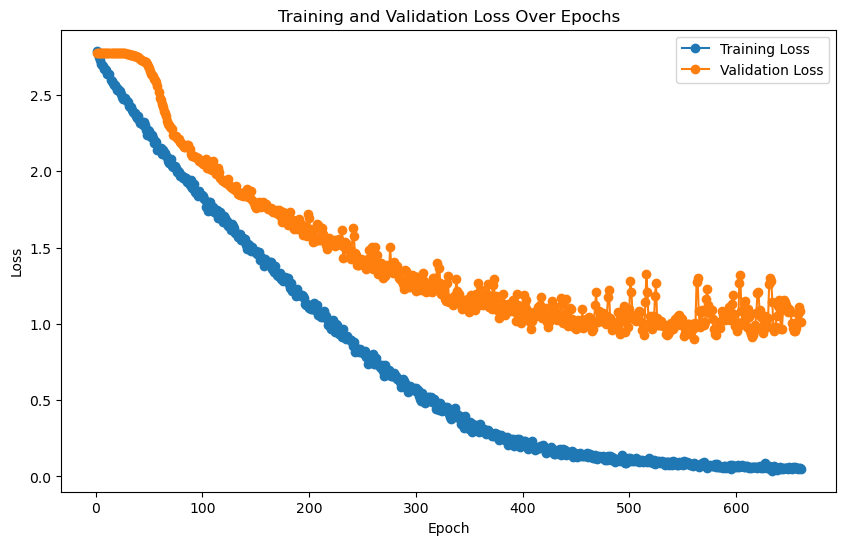

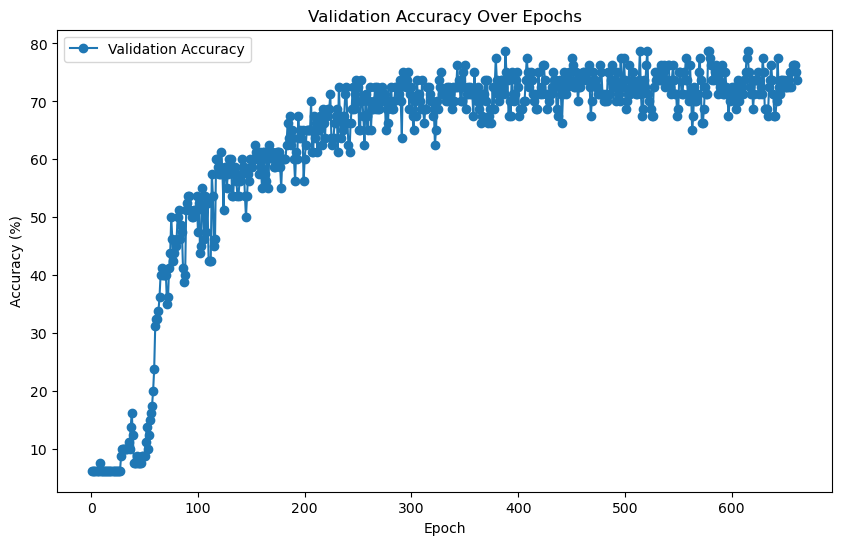


Evaluating on the test set...
    Test Batch [1/40], Loss: 3.1000

Final Test Loss: 1.6025, Test Accuracy: 60.26%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10009, 64), Test labels shape: (10009,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 55.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.33      0.20      0.25         5
           2       0.00      0.00      0.00         5
           3       1.00      0.20      0.33         5
           4       0.67      0.40      0.50         5
           5       0.60      0.60      0.60         5
           6       0.50      0.60      0.55         5
           7       0.60      0.60      0.60         5
           8       0.71      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10009, 64)
Test labels shape: (10009,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0291  |  Val Loss: 2.8501
Validation loss improved from inf to 2.8501.
[Epoch 2/1000] Train Loss: 2.7888  |  Val Loss: 2.7295
Validation loss improved from 2.8501 to 2.7295.
[Epoch 3/1000] Train Loss: 2.6668  |  Val Loss: 2.6447
Validation loss improved from 2.7295 to 2.6447.
[Epoch 4/1000] Train Loss: 2.5933  |  Val Loss: 2.5919
Validation loss improved from 2.6447 to 2.5919.
[Epoch 5/1000] Train Loss: 2.5359  |  Val Loss: 2.5543
Validation loss improved from 2.5919 to 2.5543.
[Epoch 6/1000] Train Loss: 2.4863  |  Val Loss: 2.5180
Validation loss improved from 2.5543 to 2.5180.
[Epoch 7/1000] Train Loss: 2.4404  |  Val Loss: 2.4783
Validation loss improved from 2.5180 to 2.4783.
[Epoch 8/1000] Train Loss: 2.3956  |  Val Loss: 2.4390
Validation loss improved from 2.4783 to 2.4390.
[Epoch 9/1000] Train Loss: 2.3510  |  Val Loss: 2.4034
Validation loss improved from 2.4390 to 2.4034.
[Epoch 10/1000] Train Loss: 2.3078  |  Val Loss: 2.3681
Validation loss impr

[Epoch 14/1000] Train Loss: 2.1360  |  Val Loss: 2.2291
Validation loss improved from 2.2604 to 2.2291.
[Epoch 15/1000] Train Loss: 2.0979  |  Val Loss: 2.1991
Validation loss improved from 2.2291 to 2.1991.
[Epoch 16/1000] Train Loss: 2.0581  |  Val Loss: 2.1744
Validation loss improved from 2.1991 to 2.1744.
[Epoch 17/1000] Train Loss: 2.0258  |  Val Loss: 2.1445
Validation loss improved from 2.1744 to 2.1445.
[Epoch 18/1000] Train Loss: 1.9827  |  Val Loss: 2.1099
Validation loss improved from 2.1445 to 2.1099.
[Epoch 19/1000] Train Loss: 1.9485  |  Val Loss: 2.0829
Validation loss improved from 2.1099 to 2.0829.
[Epoch 20/1000] Train Loss: 1.9095  |  Val Loss: 2.0540
Validation loss improved from 2.0829 to 2.0540.
[Epoch 21/1000] Train Loss: 1.8654  |  Val Loss: 2.0279
Validation loss improved from 2.0540 to 2.0279.
[Epoch 22/1000] Train Loss: 1.8253  |  Val Loss: 2.0009
Validation loss improved from 2.0279 to 2.0009.
[Epoch 23/1000] Train Loss: 1.7888  |  Val Loss: 1.9672
Validati

[Epoch 27/1000] Train Loss: 1.6507  |  Val Loss: 1.8577
Validation loss improved from 1.8863 to 1.8577.


[Epoch 28/1000] Train Loss: 1.6138  |  Val Loss: 1.8322
Validation loss improved from 1.8577 to 1.8322.
[Epoch 29/1000] Train Loss: 1.5847  |  Val Loss: 1.8135
Validation loss improved from 1.8322 to 1.8135.
[Epoch 30/1000] Train Loss: 1.5598  |  Val Loss: 1.7863
Validation loss improved from 1.8135 to 1.7863.
[Epoch 31/1000] Train Loss: 1.5282  |  Val Loss: 1.7661
Validation loss improved from 1.7863 to 1.7661.
[Epoch 32/1000] Train Loss: 1.5026  |  Val Loss: 1.7555
Validation loss improved from 1.7661 to 1.7555.
[Epoch 33/1000] Train Loss: 1.4697  |  Val Loss: 1.7410
Validation loss improved from 1.7555 to 1.7410.
[Epoch 34/1000] Train Loss: 1.4450  |  Val Loss: 1.7225
Validation loss improved from 1.7410 to 1.7225.
[Epoch 35/1000] Train Loss: 1.4145  |  Val Loss: 1.6983
Validation loss improved from 1.7225 to 1.6983.
[Epoch 36/1000] Train Loss: 1.3938  |  Val Loss: 1.6861
Validation loss improved from 1.6983 to 1.6861.
[Epoch 37/1000] Train Loss: 1.3729  |  Val Loss: 1.6685
Validati

[Epoch 42/1000] Train Loss: 1.2644  |  Val Loss: 1.6188
Validation loss improved from 1.6305 to 1.6188.
[Epoch 43/1000] Train Loss: 1.2472  |  Val Loss: 1.6119
Validation loss improved from 1.6188 to 1.6119.
[Epoch 44/1000] Train Loss: 1.2178  |  Val Loss: 1.6142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 1.2085  |  Val Loss: 1.6165
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 1.1947  |  Val Loss: 1.5923
Validation loss improved from 1.6119 to 1.5923.
[Epoch 47/1000] Train Loss: 1.1668  |  Val Loss: 1.5883
Validation loss improved from 1.5923 to 1.5883.
[Epoch 48/1000] Train Loss: 1.1549  |  Val Loss: 1.5788
Validation loss improved from 1.5883 to 1.5788.
[Epoch 49/1000] Train Loss: 1.1301  |  Val Loss: 1.5693
Validation loss improved from 1.5788 to 1.5693.
[Epoch 50/1000] Train Loss: 1.1194  |  Val Loss: 1.5626
Validation loss improved from 1.5693 to 1.5626.
[Epoch 51/1000] Train Loss: 1.0963  |  Val Loss: 1.5

[Epoch 60/1000] Train Loss: 0.9773  |  Val Loss: 1.5075
Validation loss improved from 1.5244 to 1.5075.
[Epoch 61/1000] Train Loss: 0.9615  |  Val Loss: 1.5036
Validation loss improved from 1.5075 to 1.5036.
[Epoch 62/1000] Train Loss: 0.9494  |  Val Loss: 1.5080
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.9374  |  Val Loss: 1.5192
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 0.9328  |  Val Loss: 1.4980
Validation loss improved from 1.5036 to 1.4980.
[Epoch 65/1000] Train Loss: 0.9088  |  Val Loss: 1.4890
Validation loss improved from 1.4980 to 1.4890.
[Epoch 66/1000] Train Loss: 0.9064  |  Val Loss: 1.4992
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 0.8957  |  Val Loss: 1.5015
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 68/1000] Train Loss: 0.8906  |  Val Loss: 1.5150
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 69/1000] Train Loss: 0.8748

[Epoch 72/1000] Train Loss: 0.8419  |  Val Loss: 1.5021
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 73/1000] Train Loss: 0.8361  |  Val Loss: 1.5074
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 74/1000] Train Loss: 0.8303  |  Val Loss: 1.4998
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 75/1000] Train Loss: 0.8229  |  Val Loss: 1.5162
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 76/1000] Train Loss: 0.8061  |  Val Loss: 1.5186
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 77/1000] Train Loss: 0.8062  |  Val Loss: 1.5352
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 78/1000] Train Loss: 0.7942  |  Val Loss: 1.5110
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 79/1000] Train Loss: 0.7811  |  Val Loss: 1.5131
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 80/1000] Train Loss: 0.7699  |  Val Loss: 1.5122
!! Validation loss did NOT improve !! Patience: 15/100
[Epo

[Epoch 87/1000] Train Loss: 0.7040  |  Val Loss: 1.5398
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 88/1000] Train Loss: 0.7044  |  Val Loss: 1.5514
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 89/1000] Train Loss: 0.6867  |  Val Loss: 1.5622
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 90/1000] Train Loss: 0.6967  |  Val Loss: 1.5427
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 91/1000] Train Loss: 0.6910  |  Val Loss: 1.5445
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 92/1000] Train Loss: 0.6800  |  Val Loss: 1.5731
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 93/1000] Train Loss: 0.6863  |  Val Loss: 1.5735
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 94/1000] Train Loss: 0.6655  |  Val Loss: 1.5647
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 95/1000] Train Loss: 0.6595  |  Val Loss: 1.5502
!! Validation loss did NOT improve !! Patience: 30/100
[

[Epoch 100/1000] Train Loss: 0.6175  |  Val Loss: 1.5603
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 101/1000] Train Loss: 0.6096  |  Val Loss: 1.5819
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 102/1000] Train Loss: 0.6076  |  Val Loss: 1.5920
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 103/1000] Train Loss: 0.5981  |  Val Loss: 1.6120
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 104/1000] Train Loss: 0.5919  |  Val Loss: 1.6130
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 105/1000] Train Loss: 0.5851  |  Val Loss: 1.5940
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 106/1000] Train Loss: 0.5740  |  Val Loss: 1.5809
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 107/1000] Train Loss: 0.5769  |  Val Loss: 1.5819
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 108/1000] Train Loss: 0.5715  |  Val Loss: 1.6025
!! Validation loss did NOT improve !! Patience:

[Epoch 118/1000] Train Loss: 0.5119  |  Val Loss: 1.6409
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 119/1000] Train Loss: 0.5091  |  Val Loss: 1.6358
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 120/1000] Train Loss: 0.5005  |  Val Loss: 1.6508
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 121/1000] Train Loss: 0.4925  |  Val Loss: 1.6773
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 122/1000] Train Loss: 0.4927  |  Val Loss: 1.6943
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 123/1000] Train Loss: 0.4841  |  Val Loss: 1.6897
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 124/1000] Train Loss: 0.4793  |  Val Loss: 1.6868
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 125/1000] Train Loss: 0.4765  |  Val Loss: 1.6878
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 126/1000] Train Loss: 0.4659  |  Val Loss: 1.7111
!! Validation loss did NOT improve !! Patience:

[Epoch 130/1000] Train Loss: 0.4530  |  Val Loss: 1.7264
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 131/1000] Train Loss: 0.4545  |  Val Loss: 1.7400
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 132/1000] Train Loss: 0.4447  |  Val Loss: 1.7295
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 133/1000] Train Loss: 0.4507  |  Val Loss: 1.7418
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 134/1000] Train Loss: 0.4503  |  Val Loss: 1.7676
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 135/1000] Train Loss: 0.4356  |  Val Loss: 1.7657
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 136/1000] Train Loss: 0.4334  |  Val Loss: 1.7419
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 137/1000] Train Loss: 0.4216  |  Val Loss: 1.7329
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 138/1000] Train Loss: 0.4238  |  Val Loss: 1.7436
!! Validation loss did NOT improve !! Patience:

[Epoch 144/1000] Train Loss: 0.4009  |  Val Loss: 1.7859
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 145/1000] Train Loss: 0.3944  |  Val Loss: 1.7724
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 146/1000] Train Loss: 0.3887  |  Val Loss: 1.7842
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 147/1000] Train Loss: 0.3834  |  Val Loss: 1.8057
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 148/1000] Train Loss: 0.3737  |  Val Loss: 1.8076
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 149/1000] Train Loss: 0.3813  |  Val Loss: 1.8119
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 150/1000] Train Loss: 0.3764  |  Val Loss: 1.8441
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 151/1000] Train Loss: 0.3803  |  Val Loss: 1.8282
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 152/1000] Train Loss: 0.3619  |  Val Loss: 1.8434
!! Validation loss did NOT improve !! Patience:

[Epoch 154/1000] Train Loss: 0.3660  |  Val Loss: 1.8475
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 155/1000] Train Loss: 0.3666  |  Val Loss: 1.8317
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 156/1000] Train Loss: 0.3573  |  Val Loss: 1.8552
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 157/1000] Train Loss: 0.3491  |  Val Loss: 1.8700
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 158/1000] Train Loss: 0.3452  |  Val Loss: 1.8592
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 159/1000] Train Loss: 0.3423  |  Val Loss: 1.8474
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 160/1000] Train Loss: 0.3422  |  Val Loss: 1.8452
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 161/1000] Train Loss: 0.3399  |  Val Loss: 1.8774
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 162/1000] Train Loss: 0.3377  |  Val Loss: 1.8822
!! Validation loss did NOT improve !! Patience:

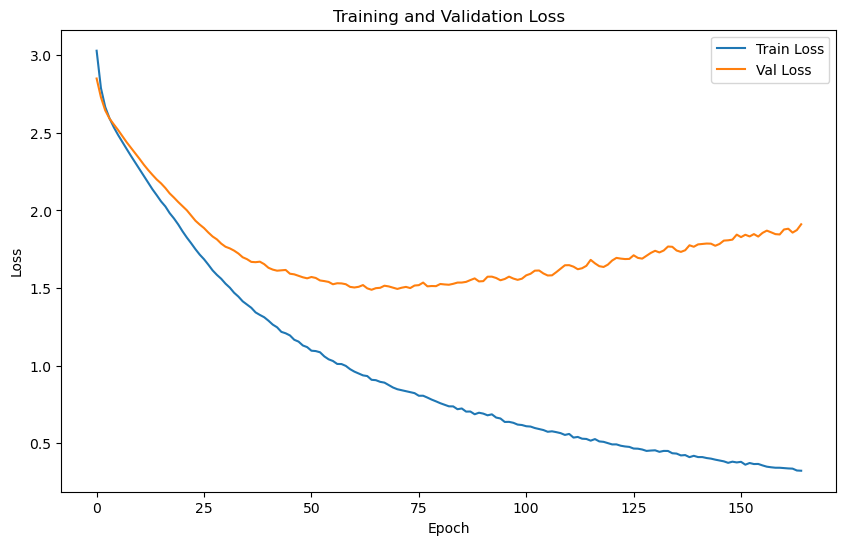

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.4723 | Test Accuracy: 52.65%


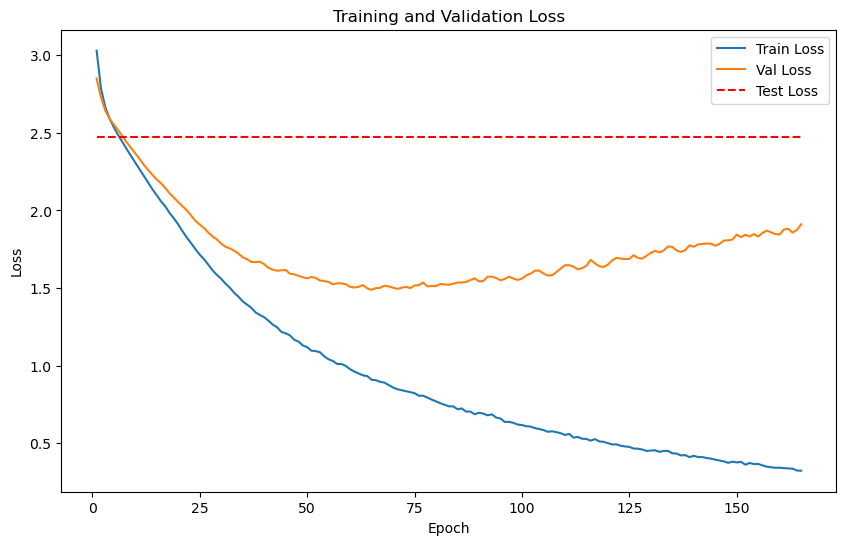

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.0980
Epoch [1/2000], Avg Train Loss: 9.0980
Epoch [1/2000], Avg Val Loss: 5.2836
Validation loss improved from inf to 5.2836. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.9053
Epoch [2/2000], Avg Train Loss: 8.9053
Epoch [2/2000], Avg Val Loss: 5.2302
Validation loss improved from 5.2836 to 5.2302. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 8.9076
Epoch [3/2000], Avg Train Loss: 8.9076
Epoch [3/2000], Avg Val Loss: 5.1784
Validation loss improved from 5.2302 to 5.1784. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1501
Epoch [4/2000], Avg Train Loss: 9.1501
Epoch [4/2000], Avg Val Loss: 5.1276
Validation loss improved from 5.1784 to 5.1276. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8673
Epoch [5/2000], Avg Train Loss: 8.8673
Epoch [5/2000], Avg Val Loss: 5.0781
Validation loss improved from 5.1276 to 5.0781. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.8193
Epoch [6/2000], Avg Train Loss: 8.8193
Epoch [6/2000], Avg Val Loss: 5.0296
Validation loss improved from 5.0781 to 5.0296. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 8.5797
Epoch [7/2000], Avg Train Loss: 8.5797
Epoch [7/2000], Avg Val Loss: 4.9822
Validation loss improved from 5.0296 to 4.9822. Saving m

    Batch [1/1], Train Loss: 8.0094
Epoch [17/2000], Avg Train Loss: 8.0094


Epoch [17/2000], Avg Val Loss: 4.5680
Validation loss improved from 4.6047 to 4.5680. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.9262
Epoch [18/2000], Avg Train Loss: 7.9262
Epoch [18/2000], Avg Val Loss: 4.5325
Validation loss improved from 4.5680 to 4.5325. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.7688
Epoch [19/2000], Avg Train Loss: 7.7688
Epoch [19/2000], Avg Val Loss: 4.4980
Validation loss improved from 4.5325 to 4.4980. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.7113
Epoch [20/2000], Avg Train Loss: 7.7113
Epoch [20/2000], Avg Val Loss: 4.4646
Validation loss improved from 4.4980 to 4.4646. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.5778
Epoch [21/2000], Avg Train Loss: 7.5778
Epoch [21/2000], Avg Val Loss: 4.4321
Validation loss improved from 4.4646 to 4.4321. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.2889
Epoch [27/2000], Avg Train Loss: 7.2889
Epoch [27/2000], Avg Val Loss: 4.2581
Validation loss improved from 4.2848 to 4.2581. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.2290
Epoch [28/2000], Avg Train Loss: 7.2290
Epoch [28/2000], Avg Val Loss: 4.2322
Validation loss improved from 4.2581 to 4.2322. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.0582
Epoch [29/2000], Avg Train Loss: 7.0582
Epoch [29/2000], Avg Val Loss: 4.2073
Validation loss improved from 4.2322 to 4.2073. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.0196
Epoch [30/2000], Avg Train Loss: 7.0196
Epoch [30/2000], Avg Val Loss: 4.1832
Validation loss improved from 4.2073 to 4.1832. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 7.1536
Epoch [31/2000], Avg Train Loss: 7.1536
Epoch [31/2000], Avg Val Loss: 4.1602
Validation loss improved from 4.1832 to 4.

    Batch [1/1], Train Loss: 6.4361
Epoch [44/2000], Avg Train Loss: 6.4361
Epoch [44/2000], Avg Val Loss: 3.9268
Validation loss improved from 3.9410 to 3.9268. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.1873
Epoch [45/2000], Avg Train Loss: 6.1873
Epoch [45/2000], Avg Val Loss: 3.9131
Validation loss improved from 3.9268 to 3.9131. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.1667
Epoch [46/2000], Avg Train Loss: 6.1667
Epoch [46/2000], Avg Val Loss: 3.9000
Validation loss improved from 3.9131 to 3.9000. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2409
Epoch [47/2000], Avg Train Loss: 6.2409
Epoch [47/2000], Avg Val Loss: 3.8874
Validation loss improved from 3.9000 to 3.8874. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.2458
Epoch [48/2000], Avg Train Loss: 6.2458
Epoch [48/2000], Avg Val Loss: 3.8753
Validation loss improved from 3.8874 to 3.

Epoch [60/2000], Avg Val Loss: 3.7623
Validation loss improved from 3.7697 to 3.7623. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.6746
Epoch [61/2000], Avg Train Loss: 5.6746
Epoch [61/2000], Avg Val Loss: 3.7553
Validation loss improved from 3.7623 to 3.7553. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.7665
Epoch [62/2000], Avg Train Loss: 5.7665
Epoch [62/2000], Avg Val Loss: 3.7485
Validation loss improved from 3.7553 to 3.7485. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.6235
Epoch [63/2000], Avg Train Loss: 5.6235
Epoch [63/2000], Avg Val Loss: 3.7421
Validation loss improved from 3.7485 to 3.7421. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.6652
Epoch [64/2000], Avg Train Loss: 5.6652
Epoch [64/2000], Avg Val Loss: 3.7359
Validation loss improved from 3.7421 to 3.7359. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3591
Epoch [82/2000], Avg Train Loss: 5.3591
Epoch [82/2000], Avg Val Loss: 3.6593
Validation loss improved from 3.6621 to 3.6593. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.1812
Epoch [83/2000], Avg Train Loss: 5.1812
Epoch [83/2000], Avg Val Loss: 3.6565
Validation loss improved from 3.6593 to 3.6565. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.2515
Epoch [84/2000], Avg Train Loss: 5.2515
Epoch [84/2000], Avg Val Loss: 3.6537
Validation loss improved from 3.6565 to 3.6537. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.2169
Epoch [85/2000], Avg Train Loss: 5.2169
Epoch [85/2000], Avg Val Loss: 3.6511
Validation loss improved from 3.6537 to 3.6511. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.1192
Epoch [86/2000], Avg Train Loss: 5.1192
Epoch [86/2000], Avg Val Loss: 3.6485
Validation loss improved from 3.6511 to 3.

Epoch [103/2000], Avg Val Loss: 3.6158
Validation loss improved from 3.6174 to 3.6158. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.9667
Epoch [104/2000], Avg Train Loss: 4.9667
Epoch [104/2000], Avg Val Loss: 3.6143
Validation loss improved from 3.6158 to 3.6143. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.9852
Epoch [105/2000], Avg Train Loss: 4.9852
Epoch [105/2000], Avg Val Loss: 3.6127
Validation loss improved from 3.6143 to 3.6127. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.9312
Epoch [106/2000], Avg Train Loss: 4.9312
Epoch [106/2000], Avg Val Loss: 3.6112
Validation loss improved from 3.6127 to 3.6112. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.9683
Epoch [107/2000], Avg Train Loss: 4.9683
Epoch [107/2000], Avg Val Loss: 3.6097
Validation loss improved from 3.6112 to 3.6097. Saving model...

LOG: Epoch [108/2000] - Training
    Bat

Epoch [125/2000], Avg Val Loss: 3.5855
Validation loss improved from 3.5867 to 3.5855. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.8063
Epoch [126/2000], Avg Train Loss: 4.8063
Epoch [126/2000], Avg Val Loss: 3.5843
Validation loss improved from 3.5855 to 3.5843. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.7204
Epoch [127/2000], Avg Train Loss: 4.7204
Epoch [127/2000], Avg Val Loss: 3.5832
Validation loss improved from 3.5843 to 3.5832. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.7979
Epoch [128/2000], Avg Train Loss: 4.7979
Epoch [128/2000], Avg Val Loss: 3.5820
Validation loss improved from 3.5832 to 3.5820. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.8174
Epoch [129/2000], Avg Train Loss: 4.8174
Epoch [129/2000], Avg Val Loss: 3.5809
Validation loss improved from 3.5820 to 3.5809. Saving model...

LOG: Epoch [130/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7325
Epoch [146/2000], Avg Train Loss: 4.7325
Epoch [146/2000], Avg Val Loss: 3.5626
Validation loss improved from 3.5636 to 3.5626. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.7823
Epoch [147/2000], Avg Train Loss: 4.7823
Epoch [147/2000], Avg Val Loss: 3.5615
Validation loss improved from 3.5626 to 3.5615. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6809
Epoch [148/2000], Avg Train Loss: 4.6809
Epoch [148/2000], Avg Val Loss: 3.5605
Validation loss improved from 3.5615 to 3.5605. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.7325
Epoch [149/2000], Avg Train Loss: 4.7325
Epoch [149/2000], Avg Val Loss: 3.5594
Validation loss improved from 3.5605 to 3.5594. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.7069
Epoch [150/2000], Avg Train Loss: 4.7069
Epoch [150/2000], Avg Val Loss: 3.5584
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6919
Epoch [167/2000], Avg Train Loss: 4.6919
Epoch [167/2000], Avg Val Loss: 3.5414
Validation loss improved from 3.5424 to 3.5414. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.6417
Epoch [168/2000], Avg Train Loss: 4.6417
Epoch [168/2000], Avg Val Loss: 3.5404
Validation loss improved from 3.5414 to 3.5404. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.6464
Epoch [169/2000], Avg Train Loss: 4.6464
Epoch [169/2000], Avg Val Loss: 3.5394
Validation loss improved from 3.5404 to 3.5394. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.6407
Epoch [170/2000], Avg Train Loss: 4.6407
Epoch [170/2000], Avg Val Loss: 3.5384
Validation loss improved from 3.5394 to 3.5384. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.6173
Epoch [171/2000], Avg Train Loss: 4.6173
Epoch [171/2000], Avg Val Loss: 3.5374
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5254
Epoch [191/2000], Avg Train Loss: 4.5254
Epoch [191/2000], Avg Val Loss: 3.5179
Validation loss improved from 3.5189 to 3.5179. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.5915
Epoch [192/2000], Avg Train Loss: 4.5915
Epoch [192/2000], Avg Val Loss: 3.5170
Validation loss improved from 3.5179 to 3.5170. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.5127
Epoch [193/2000], Avg Train Loss: 4.5127
Epoch [193/2000], Avg Val Loss: 3.5160
Validation loss improved from 3.5170 to 3.5160. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.5336
Epoch [194/2000], Avg Train Loss: 4.5336
Epoch [194/2000], Avg Val Loss: 3.5150
Validation loss improved from 3.5160 to 3.5150. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.5397
Epoch [195/2000], Avg Train Loss: 4.5397
Epoch [195/2000], Avg Val Loss: 3.5140
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4882
Epoch [209/2000], Avg Train Loss: 4.4882
Epoch [209/2000], Avg Val Loss: 3.5005
Validation loss improved from 3.5015 to 3.5005. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.5173
Epoch [210/2000], Avg Train Loss: 4.5173
Epoch [210/2000], Avg Val Loss: 3.4995
Validation loss improved from 3.5005 to 3.4995. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 4.5063
Epoch [211/2000], Avg Train Loss: 4.5063
Epoch [211/2000], Avg Val Loss: 3.4986
Validation loss improved from 3.4995 to 3.4986. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.4885
Epoch [212/2000], Avg Train Loss: 4.4885
Epoch [212/2000], Avg Val Loss: 3.4976
Validation loss improved from 3.4986 to 3.4976. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.5480
Epoch [213/2000], Avg Train Loss: 4.5480
Epoch [213/2000], Avg Val Loss: 3.4967
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5064
Epoch [230/2000], Avg Train Loss: 4.5064
Epoch [230/2000], Avg Val Loss: 3.4807
Validation loss improved from 3.4817 to 3.4807. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.5126
Epoch [231/2000], Avg Train Loss: 4.5126
Epoch [231/2000], Avg Val Loss: 3.4798
Validation loss improved from 3.4807 to 3.4798. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.4707
Epoch [232/2000], Avg Train Loss: 4.4707
Epoch [232/2000], Avg Val Loss: 3.4789
Validation loss improved from 3.4798 to 3.4789. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.4544
Epoch [233/2000], Avg Train Loss: 4.4544
Epoch [233/2000], Avg Val Loss: 3.4779
Validation loss improved from 3.4789 to 3.4779. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.4830
Epoch [234/2000], Avg Train Loss: 4.4830
Epoch [234/2000], Avg Val Loss: 3.4770
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4480
Epoch [251/2000], Avg Train Loss: 4.4480
Epoch [251/2000], Avg Val Loss: 3.4620
Validation loss improved from 3.4629 to 3.4620. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.3970
Epoch [252/2000], Avg Train Loss: 4.3970
Epoch [252/2000], Avg Val Loss: 3.4611
Validation loss improved from 3.4620 to 3.4611. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.4518
Epoch [253/2000], Avg Train Loss: 4.4518
Epoch [253/2000], Avg Val Loss: 3.4603
Validation loss improved from 3.4611 to 3.4603. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.4102
Epoch [254/2000], Avg Train Loss: 4.4102
Epoch [254/2000], Avg Val Loss: 3.4594
Validation loss improved from 3.4603 to 3.4594. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.3798
Epoch [255/2000], Avg Train Loss: 4.3798
Epoch [255/2000], Avg Val Loss: 3.4586
Validation loss improved fro

Epoch [269/2000], Avg Val Loss: 3.4471
Validation loss improved from 3.4479 to 3.4471. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.4021
Epoch [270/2000], Avg Train Loss: 4.4021
Epoch [270/2000], Avg Val Loss: 3.4463
Validation loss improved from 3.4471 to 3.4463. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.4547
Epoch [271/2000], Avg Train Loss: 4.4547
Epoch [271/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4463 to 3.4455. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.3415
Epoch [272/2000], Avg Train Loss: 4.3415
Epoch [272/2000], Avg Val Loss: 3.4447
Validation loss improved from 3.4455 to 3.4447. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.3665
Epoch [273/2000], Avg Train Loss: 4.3665
Epoch [273/2000], Avg Val Loss: 3.4439
Validation loss improved from 3.4447 to 3.4439. Saving model...

LOG: Epoch [274/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3304
Epoch [294/2000], Avg Train Loss: 4.3304
Epoch [294/2000], Avg Val Loss: 3.4264
Validation loss improved from 3.4272 to 3.4264. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.3488
Epoch [295/2000], Avg Train Loss: 4.3488
Epoch [295/2000], Avg Val Loss: 3.4256
Validation loss improved from 3.4264 to 3.4256. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.3075
Epoch [296/2000], Avg Train Loss: 4.3075
Epoch [296/2000], Avg Val Loss: 3.4248
Validation loss improved from 3.4256 to 3.4248. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.3839
Epoch [297/2000], Avg Train Loss: 4.3839
Epoch [297/2000], Avg Val Loss: 3.4241
Validation loss improved from 3.4248 to 3.4241. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.2894
Epoch [298/2000], Avg Train Loss: 4.2894
Epoch [298/2000], Avg Val Loss: 3.4233
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3117
Epoch [312/2000], Avg Train Loss: 4.3117
Epoch [312/2000], Avg Val Loss: 3.4124
Validation loss improved from 3.4132 to 3.4124. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.3307
Epoch [313/2000], Avg Train Loss: 4.3307
Epoch [313/2000], Avg Val Loss: 3.4116
Validation loss improved from 3.4124 to 3.4116. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.3870
Epoch [314/2000], Avg Train Loss: 4.3870
Epoch [314/2000], Avg Val Loss: 3.4109
Validation loss improved from 3.4116 to 3.4109. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.3153
Epoch [315/2000], Avg Train Loss: 4.3153
Epoch [315/2000], Avg Val Loss: 3.4101
Validation loss improved from 3.4109 to 3.4101. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.3239
Epoch [316/2000], Avg Train Loss: 4.3239
Epoch [316/2000], Avg Val Loss: 3.4093
Validation loss improved fro

Epoch [335/2000], Avg Val Loss: 3.3958
Validation loss improved from 3.3965 to 3.3958. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.2814
Epoch [336/2000], Avg Train Loss: 4.2814
Epoch [336/2000], Avg Val Loss: 3.3952
Validation loss improved from 3.3958 to 3.3952. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.2966
Epoch [337/2000], Avg Train Loss: 4.2966
Epoch [337/2000], Avg Val Loss: 3.3945
Validation loss improved from 3.3952 to 3.3945. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.2312
Epoch [338/2000], Avg Train Loss: 4.2312
Epoch [338/2000], Avg Val Loss: 3.3938
Validation loss improved from 3.3945 to 3.3938. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.3021
Epoch [339/2000], Avg Train Loss: 4.3021
Epoch [339/2000], Avg Val Loss: 3.3931
Validation loss improved from 3.3938 to 3.3931. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2747
Epoch [354/2000], Avg Train Loss: 4.2747
Epoch [354/2000], Avg Val Loss: 3.3830
Validation loss improved from 3.3837 to 3.3830. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.2816
Epoch [355/2000], Avg Train Loss: 4.2816
Epoch [355/2000], Avg Val Loss: 3.3824
Validation loss improved from 3.3830 to 3.3824. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.2672
Epoch [356/2000], Avg Train Loss: 4.2672
Epoch [356/2000], Avg Val Loss: 3.3818
Validation loss improved from 3.3824 to 3.3818. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.2291
Epoch [357/2000], Avg Train Loss: 4.2291
Epoch [357/2000], Avg Val Loss: 3.3812
Validation loss improved from 3.3818 to 3.3812. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.2288
Epoch [358/2000], Avg Train Loss: 4.2288
Epoch [358/2000], Avg Val Loss: 3.3805
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2385
Epoch [379/2000], Avg Train Loss: 4.2385
Epoch [379/2000], Avg Val Loss: 3.3665
Validation loss improved from 3.3672 to 3.3665. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.2282
Epoch [380/2000], Avg Train Loss: 4.2282
Epoch [380/2000], Avg Val Loss: 3.3658
Validation loss improved from 3.3665 to 3.3658. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.2180
Epoch [381/2000], Avg Train Loss: 4.2180
Epoch [381/2000], Avg Val Loss: 3.3651
Validation loss improved from 3.3658 to 3.3651. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.2610
Epoch [382/2000], Avg Train Loss: 4.2610
Epoch [382/2000], Avg Val Loss: 3.3645
Validation loss improved from 3.3651 to 3.3645. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.1978
Epoch [383/2000], Avg Train Loss: 4.1978
Epoch [383/2000], Avg Val Loss: 3.3638
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2409
Epoch [396/2000], Avg Train Loss: 4.2409
Epoch [396/2000], Avg Val Loss: 3.3559
Validation loss improved from 3.3565 to 3.3559. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.2345
Epoch [397/2000], Avg Train Loss: 4.2345
Epoch [397/2000], Avg Val Loss: 3.3554
Validation loss improved from 3.3559 to 3.3554. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.2022
Epoch [398/2000], Avg Train Loss: 4.2022
Epoch [398/2000], Avg Val Loss: 3.3548
Validation loss improved from 3.3554 to 3.3548. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.2080
Epoch [399/2000], Avg Train Loss: 4.2080
Epoch [399/2000], Avg Val Loss: 3.3543
Validation loss improved from 3.3548 to 3.3543. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.2090
Epoch [400/2000], Avg Train Loss: 4.2090
Epoch [400/2000], Avg Val Loss: 3.3537
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2032
Epoch [418/2000], Avg Train Loss: 4.2032
Epoch [418/2000], Avg Val Loss: 3.3436
Validation loss improved from 3.3442 to 3.3436. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.1605
Epoch [419/2000], Avg Train Loss: 4.1605
Epoch [419/2000], Avg Val Loss: 3.3431
Validation loss improved from 3.3436 to 3.3431. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.1837
Epoch [420/2000], Avg Train Loss: 4.1837
Epoch [420/2000], Avg Val Loss: 3.3425
Validation loss improved from 3.3431 to 3.3425. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.1437
Epoch [421/2000], Avg Train Loss: 4.1437
Epoch [421/2000], Avg Val Loss: 3.3420
Validation loss improved from 3.3425 to 3.3420. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.2128
Epoch [422/2000], Avg Train Loss: 4.2128
Epoch [422/2000], Avg Val Loss: 3.3415
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1738
Epoch [440/2000], Avg Train Loss: 4.1738
Epoch [440/2000], Avg Val Loss: 3.3329
Validation loss improved from 3.3334 to 3.3329. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.0942
Epoch [441/2000], Avg Train Loss: 4.0942
Epoch [441/2000], Avg Val Loss: 3.3324
Validation loss improved from 3.3329 to 3.3324. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.1814
Epoch [442/2000], Avg Train Loss: 4.1814
Epoch [442/2000], Avg Val Loss: 3.3319
Validation loss improved from 3.3324 to 3.3319. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.2060
Epoch [443/2000], Avg Train Loss: 4.2060
Epoch [443/2000], Avg Val Loss: 3.3313
Validation loss improved from 3.3319 to 3.3313. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.1500
Epoch [444/2000], Avg Train Loss: 4.1500
Epoch [444/2000], Avg Val Loss: 3.3308
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1626
Epoch [462/2000], Avg Train Loss: 4.1626
Epoch [462/2000], Avg Val Loss: 3.3225
Validation loss improved from 3.3229 to 3.3225. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.1231
Epoch [463/2000], Avg Train Loss: 4.1231
Epoch [463/2000], Avg Val Loss: 3.3221
Validation loss improved from 3.3225 to 3.3221. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.1223
Epoch [464/2000], Avg Train Loss: 4.1223
Epoch [464/2000], Avg Val Loss: 3.3216
Validation loss improved from 3.3221 to 3.3216. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.1042
Epoch [465/2000], Avg Train Loss: 4.1042
Epoch [465/2000], Avg Val Loss: 3.3212
Validation loss improved from 3.3216 to 3.3212. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.1524
Epoch [466/2000], Avg Train Loss: 4.1524
Epoch [466/2000], Avg Val Loss: 3.3207
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1447
Epoch [486/2000], Avg Train Loss: 4.1447
Epoch [486/2000], Avg Val Loss: 3.3110
Validation loss improved from 3.3115 to 3.3110. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.1150
Epoch [487/2000], Avg Train Loss: 4.1150
Epoch [487/2000], Avg Val Loss: 3.3105
Validation loss improved from 3.3110 to 3.3105. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.0701
Epoch [488/2000], Avg Train Loss: 4.0701
Epoch [488/2000], Avg Val Loss: 3.3100
Validation loss improved from 3.3105 to 3.3100. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.1131
Epoch [489/2000], Avg Train Loss: 4.1131
Epoch [489/2000], Avg Val Loss: 3.3096
Validation loss improved from 3.3100 to 3.3096. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.0893
Epoch [490/2000], Avg Train Loss: 4.0893
Epoch [490/2000], Avg Val Loss: 3.3092
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0592
Epoch [504/2000], Avg Train Loss: 4.0592
Epoch [504/2000], Avg Val Loss: 3.3028
Validation loss improved from 3.3032 to 3.3028. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.0948
Epoch [505/2000], Avg Train Loss: 4.0948
Epoch [505/2000], Avg Val Loss: 3.3024
Validation loss improved from 3.3028 to 3.3024. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.1371
Epoch [506/2000], Avg Train Loss: 4.1371
Epoch [506/2000], Avg Val Loss: 3.3021
Validation loss improved from 3.3024 to 3.3021. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.0739
Epoch [507/2000], Avg Train Loss: 4.0739
Epoch [507/2000], Avg Val Loss: 3.3017
Validation loss improved from 3.3021 to 3.3017. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 4.1141
Epoch [508/2000], Avg Train Loss: 4.1141
Epoch [508/2000], Avg Val Loss: 3.3014
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1060
Epoch [533/2000], Avg Train Loss: 4.1060
Epoch [533/2000], Avg Val Loss: 3.2925
Validation loss improved from 3.2928 to 3.2925. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.1167
Epoch [534/2000], Avg Train Loss: 4.1167
Epoch [534/2000], Avg Val Loss: 3.2921
Validation loss improved from 3.2925 to 3.2921. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.0637
Epoch [535/2000], Avg Train Loss: 4.0637
Epoch [535/2000], Avg Val Loss: 3.2917
Validation loss improved from 3.2921 to 3.2917. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.1101
Epoch [536/2000], Avg Train Loss: 4.1101
Epoch [536/2000], Avg Val Loss: 3.2912
Validation loss improved from 3.2917 to 3.2912. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.1054
Epoch [537/2000], Avg Train Loss: 4.1054
Epoch [537/2000], Avg Val Loss: 3.2909
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1135
Epoch [545/2000], Avg Train Loss: 4.1135
Epoch [545/2000], Avg Val Loss: 3.2872
Validation loss improved from 3.2877 to 3.2872. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.0731
Epoch [546/2000], Avg Train Loss: 4.0731
Epoch [546/2000], Avg Val Loss: 3.2867
Validation loss improved from 3.2872 to 3.2867. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.0347
Epoch [547/2000], Avg Train Loss: 4.0347
Epoch [547/2000], Avg Val Loss: 3.2863
Validation loss improved from 3.2867 to 3.2863. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.0485
Epoch [548/2000], Avg Train Loss: 4.0485
Epoch [548/2000], Avg Val Loss: 3.2859
Validation loss improved from 3.2863 to 3.2859. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.0176
Epoch [549/2000], Avg Train Loss: 4.0176
Epoch [549/2000], Avg Val Loss: 3.2855
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9554
Epoch [580/2000], Avg Train Loss: 3.9554
Epoch [580/2000], Avg Val Loss: 3.2744
Validation loss improved from 3.2747 to 3.2744. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.0533
Epoch [581/2000], Avg Train Loss: 4.0533
Epoch [581/2000], Avg Val Loss: 3.2741
Validation loss improved from 3.2744 to 3.2741. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.0691
Epoch [582/2000], Avg Train Loss: 4.0691
Epoch [582/2000], Avg Val Loss: 3.2738
Validation loss improved from 3.2741 to 3.2738. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.0006
Epoch [583/2000], Avg Train Loss: 4.0006
Epoch [583/2000], Avg Val Loss: 3.2735
Validation loss improved from 3.2738 to 3.2735. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.0413
Epoch [584/2000], Avg Train Loss: 4.0413
Epoch [584/2000], Avg Val Loss: 3.2733
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0167
Epoch [589/2000], Avg Train Loss: 4.0167
Epoch [589/2000], Avg Val Loss: 3.2721
Validation loss improved from 3.2723 to 3.2721. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.0016
Epoch [590/2000], Avg Train Loss: 4.0016
Epoch [590/2000], Avg Val Loss: 3.2719
Validation loss improved from 3.2721 to 3.2719. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.0640
Epoch [591/2000], Avg Train Loss: 4.0640
Epoch [591/2000], Avg Val Loss: 3.2717
Validation loss improved from 3.2719 to 3.2717. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.0501
Epoch [592/2000], Avg Train Loss: 4.0501
Epoch [592/2000], Avg Val Loss: 3.2715
Validation loss improved from 3.2717 to 3.2715. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.0386
Epoch [593/2000], Avg Train Loss: 4.0386
Epoch [593/2000], Avg Val Loss: 3.2712
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9573
Epoch [622/2000], Avg Train Loss: 3.9573
Epoch [622/2000], Avg Val Loss: 3.2626
Validation loss improved from 3.2630 to 3.2626. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.9961
Epoch [623/2000], Avg Train Loss: 3.9961
Epoch [623/2000], Avg Val Loss: 3.2622
Validation loss improved from 3.2626 to 3.2622. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.0271
Epoch [624/2000], Avg Train Loss: 4.0271
Epoch [624/2000], Avg Val Loss: 3.2618
Validation loss improved from 3.2622 to 3.2618. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.0598
Epoch [625/2000], Avg Train Loss: 4.0598
Epoch [625/2000], Avg Val Loss: 3.2614
Validation loss improved from 3.2618 to 3.2614. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.9297
Epoch [626/2000], Avg Train Loss: 3.9297
Epoch [626/2000], Avg Val Loss: 3.2612
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9677
Epoch [631/2000], Avg Train Loss: 3.9677
Epoch [631/2000], Avg Val Loss: 3.2600
Validation loss improved from 3.2603 to 3.2600. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.9618
Epoch [632/2000], Avg Train Loss: 3.9618
Epoch [632/2000], Avg Val Loss: 3.2598
Validation loss improved from 3.2600 to 3.2598. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.0179
Epoch [633/2000], Avg Train Loss: 4.0179
Epoch [633/2000], Avg Val Loss: 3.2596
Validation loss improved from 3.2598 to 3.2596. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.0428
Epoch [634/2000], Avg Train Loss: 4.0428
Epoch [634/2000], Avg Val Loss: 3.2594
Validation loss improved from 3.2596 to 3.2594. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.9826
Epoch [635/2000], Avg Train Loss: 3.9826
Epoch [635/2000], Avg Val Loss: 3.2592
Validation loss improved fro

Epoch [667/2000], Avg Val Loss: 3.2526
Validation loss improved from 3.2530 to 3.2526. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.9240
Epoch [668/2000], Avg Train Loss: 3.9240
Epoch [668/2000], Avg Val Loss: 3.2522
Validation loss improved from 3.2526 to 3.2522. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.9362
Epoch [669/2000], Avg Train Loss: 3.9362
Epoch [669/2000], Avg Val Loss: 3.2518
Validation loss improved from 3.2522 to 3.2518. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.9869
Epoch [670/2000], Avg Train Loss: 3.9869
Epoch [670/2000], Avg Val Loss: 3.2514
Validation loss improved from 3.2518 to 3.2514. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.9326
Epoch [671/2000], Avg Train Loss: 3.9326
Epoch [671/2000], Avg Val Loss: 3.2510
Validation loss improved from 3.2514 to 3.2510. Saving model...

LOG: Epoch [672/2000] - Training
    Bat

Epoch [710/2000], Avg Val Loss: 3.2412
Validation loss improved from 3.2414 to 3.2412. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.9213
Epoch [711/2000], Avg Train Loss: 3.9213
Epoch [711/2000], Avg Val Loss: 3.2410
Validation loss improved from 3.2412 to 3.2410. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.8588
Epoch [712/2000], Avg Train Loss: 3.8588
Epoch [712/2000], Avg Val Loss: 3.2407
Validation loss improved from 3.2410 to 3.2407. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.8740
Epoch [713/2000], Avg Train Loss: 3.8740
Epoch [713/2000], Avg Val Loss: 3.2405
Validation loss improved from 3.2407 to 3.2405. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.9212
Epoch [714/2000], Avg Train Loss: 3.9212
Epoch [714/2000], Avg Val Loss: 3.2403
Validation loss improved from 3.2405 to 3.2403. Saving model...

LOG: Epoch [715/2000] - Training
    Bat

Epoch [755/2000], Avg Val Loss: 3.2317
Validation loss improved from 3.2318 to 3.2317. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.8951
Epoch [756/2000], Avg Train Loss: 3.8951
Epoch [756/2000], Avg Val Loss: 3.2315
Validation loss improved from 3.2317 to 3.2315. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.9082
Epoch [757/2000], Avg Train Loss: 3.9082
Epoch [757/2000], Avg Val Loss: 3.2314
Validation loss improved from 3.2315 to 3.2314. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.8739
Epoch [758/2000], Avg Train Loss: 3.8739
Epoch [758/2000], Avg Val Loss: 3.2313
Validation loss improved from 3.2314 to 3.2313. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.9012
Epoch [759/2000], Avg Train Loss: 3.9012
Epoch [759/2000], Avg Val Loss: 3.2312
Validation loss improved from 3.2313 to 3.2312. Saving model...

LOG: Epoch [760/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8619
Epoch [804/2000], Avg Train Loss: 3.8619
Epoch [804/2000], Avg Val Loss: 3.2231
Validation loss improved from 3.2234 to 3.2231. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.8499
Epoch [805/2000], Avg Train Loss: 3.8499
Epoch [805/2000], Avg Val Loss: 3.2229
Validation loss improved from 3.2231 to 3.2229. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.8666
Epoch [806/2000], Avg Train Loss: 3.8666
Epoch [806/2000], Avg Val Loss: 3.2227
Validation loss improved from 3.2229 to 3.2227. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.8390
Epoch [807/2000], Avg Train Loss: 3.8390
Epoch [807/2000], Avg Val Loss: 3.2224
Validation loss improved from 3.2227 to 3.2224. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.8530
Epoch [808/2000], Avg Train Loss: 3.8530
Epoch [808/2000], Avg Val Loss: 3.2222
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7967
Epoch [847/2000], Avg Train Loss: 3.7967
Epoch [847/2000], Avg Val Loss: 3.2195
Validation loss improved from 3.2198 to 3.2195. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.7953
Epoch [848/2000], Avg Train Loss: 3.7953
Epoch [848/2000], Avg Val Loss: 3.2193
Validation loss improved from 3.2195 to 3.2193. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.7787
Epoch [849/2000], Avg Train Loss: 3.7787
Epoch [849/2000], Avg Val Loss: 3.2191
Validation loss improved from 3.2193 to 3.2191. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.8501
Epoch [850/2000], Avg Train Loss: 3.8501
Epoch [850/2000], Avg Val Loss: 3.2188
Validation loss improved from 3.2191 to 3.2188. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.7935
Epoch [851/2000], Avg Train Loss: 3.7935
Epoch [851/2000], Avg Val Loss: 3.2186
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8023
Epoch [889/2000], Avg Train Loss: 3.8023
Epoch [889/2000], Avg Val Loss: 3.2161
Validation loss did not improve. Patience: 3/100

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.8263
Epoch [890/2000], Avg Train Loss: 3.8263
Epoch [890/2000], Avg Val Loss: 3.2162
Validation loss did not improve. Patience: 4/100

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.7996
Epoch [891/2000], Avg Train Loss: 3.7996
Epoch [891/2000], Avg Val Loss: 3.2164
Validation loss did not improve. Patience: 5/100

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.8453
Epoch [892/2000], Avg Train Loss: 3.8453
Epoch [892/2000], Avg Val Loss: 3.2165
Validation loss did not improve. Patience: 6/100

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.7659
Epoch [893/2000], Avg Train Loss: 3.7659
Epoch [893/2000], Avg Val Loss: 3.2167
Validation loss did not improve. Patience: 7/100

LOG: Epoch [894/2000] - Training
    B

Epoch [932/2000], Avg Val Loss: 3.2126
Validation loss improved from 3.2128 to 3.2126. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.7501
Epoch [933/2000], Avg Train Loss: 3.7501
Epoch [933/2000], Avg Val Loss: 3.2124
Validation loss improved from 3.2126 to 3.2124. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.7364
Epoch [934/2000], Avg Train Loss: 3.7364
Epoch [934/2000], Avg Val Loss: 3.2122
Validation loss improved from 3.2124 to 3.2122. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.8078
Epoch [935/2000], Avg Train Loss: 3.8078
Epoch [935/2000], Avg Val Loss: 3.2120
Validation loss improved from 3.2122 to 3.2120. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.7669
Epoch [936/2000], Avg Train Loss: 3.7669
Epoch [936/2000], Avg Val Loss: 3.2117
Validation loss improved from 3.2120 to 3.2117. Saving model...

LOG: Epoch [937/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7451
Epoch [976/2000], Avg Train Loss: 3.7451
Epoch [976/2000], Avg Val Loss: 3.2076
Validation loss improved from 3.2077 to 3.2076. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.7441
Epoch [977/2000], Avg Train Loss: 3.7441
Epoch [977/2000], Avg Val Loss: 3.2076
Validation loss improved from 3.2076 to 3.2076. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.7711
Epoch [978/2000], Avg Train Loss: 3.7711
Epoch [978/2000], Avg Val Loss: 3.2074
Validation loss improved from 3.2076 to 3.2074. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.7308
Epoch [979/2000], Avg Train Loss: 3.7308
Epoch [979/2000], Avg Val Loss: 3.2072
Validation loss improved from 3.2074 to 3.2072. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.7413
Epoch [980/2000], Avg Train Loss: 3.7413
Epoch [980/2000], Avg Val Loss: 3.2070
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6746
Epoch [1015/2000], Avg Train Loss: 3.6746
Epoch [1015/2000], Avg Val Loss: 3.2042
Validation loss improved from 3.2043 to 3.2042. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.7323
Epoch [1016/2000], Avg Train Loss: 3.7323
Epoch [1016/2000], Avg Val Loss: 3.2042
Validation loss improved from 3.2042 to 3.2042. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.7022
Epoch [1017/2000], Avg Train Loss: 3.7022
Epoch [1017/2000], Avg Val Loss: 3.2042
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.7135
Epoch [1018/2000], Avg Train Loss: 3.7135
Epoch [1018/2000], Avg Val Loss: 3.2042
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.7483
Epoch [1019/2000], Avg Train Loss: 3.7483
Epoch [1019/2000], Avg Val Loss: 3.2042
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.7083
Epoch [1059/2000], Avg Train Loss: 3.7083
Epoch [1059/2000], Avg Val Loss: 3.1972
Validation loss improved from 3.1973 to 3.1972. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.6445
Epoch [1060/2000], Avg Train Loss: 3.6445
Epoch [1060/2000], Avg Val Loss: 3.1971
Validation loss improved from 3.1972 to 3.1971. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.7099
Epoch [1061/2000], Avg Train Loss: 3.7099
Epoch [1061/2000], Avg Val Loss: 3.1968
Validation loss improved from 3.1971 to 3.1968. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.6937
Epoch [1062/2000], Avg Train Loss: 3.6937
Epoch [1062/2000], Avg Val Loss: 3.1965
Validation loss improved from 3.1968 to 3.1965. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 3.6290
Epoch [1063/2000], Avg Train Loss: 3.6290
Epoch [1063/2000], Avg Val Loss: 3.1963
Validation los

Epoch [1101/2000], Avg Val Loss: 3.1993
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.6407
Epoch [1102/2000], Avg Train Loss: 3.6407
Epoch [1102/2000], Avg Val Loss: 3.1991
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.6600
Epoch [1103/2000], Avg Train Loss: 3.6600
Epoch [1103/2000], Avg Val Loss: 3.1989
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 3.6217
Epoch [1104/2000], Avg Train Loss: 3.6217
Epoch [1104/2000], Avg Val Loss: 3.1988
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 3.7033
Epoch [1105/2000], Avg Train Loss: 3.7033
Epoch [1105/2000], Avg Val Loss: 3.1986
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 3.6672
Epoch [1106/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6347
Epoch [1143/2000], Avg Train Loss: 3.6347
Epoch [1143/2000], Avg Val Loss: 3.1986
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 3.6779
Epoch [1144/2000], Avg Train Loss: 3.6779
Epoch [1144/2000], Avg Val Loss: 3.1980
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 3.6084
Epoch [1145/2000], Avg Train Loss: 3.6084
Epoch [1145/2000], Avg Val Loss: 3.1975
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 3.6281
Epoch [1146/2000], Avg Train Loss: 3.6281
Epoch [1146/2000], Avg Val Loss: 3.1969
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 3.6370
Epoch [1147/2000], Avg Train Loss: 3.6370
Epoch [1147/2000], Avg Val Loss: 3.1966
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1148/20

    Batch [1/1], Train Loss: 3.6230
Epoch [1189/2000], Avg Train Loss: 3.6230
Epoch [1189/2000], Avg Val Loss: 3.1945
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 3.5688
Epoch [1190/2000], Avg Train Loss: 3.5688
Epoch [1190/2000], Avg Val Loss: 3.1945
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 3.6619
Epoch [1191/2000], Avg Train Loss: 3.6619
Epoch [1191/2000], Avg Val Loss: 3.1946
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 3.5850
Epoch [1192/2000], Avg Train Loss: 3.5850
Epoch [1192/2000], Avg Val Loss: 3.1947
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 3.5902
Epoch [1193/2000], Avg Train Loss: 3.5902
Epoch [1193/2000], Avg Val Loss: 3.1947
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1194/2000] -

Epoch [1231/2000], Avg Val Loss: 3.1946
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 3.5745
Epoch [1232/2000], Avg Train Loss: 3.5745
Epoch [1232/2000], Avg Val Loss: 3.1945
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 3.5683
Epoch [1233/2000], Avg Train Loss: 3.5683
Epoch [1233/2000], Avg Val Loss: 3.1945
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 3.5794
Epoch [1234/2000], Avg Train Loss: 3.5794
Epoch [1234/2000], Avg Val Loss: 3.1946
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 3.5665
Epoch [1235/2000], Avg Train Loss: 3.5665
Epoch [1235/2000], Avg Val Loss: 3.1946
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 3.5503
Epoch [1236/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5005
Epoch [1274/2000], Avg Train Loss: 3.5005
Epoch [1274/2000], Avg Val Loss: 3.1875
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 3.5590
Epoch [1275/2000], Avg Train Loss: 3.5590
Epoch [1275/2000], Avg Val Loss: 3.1877
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 3.5751
Epoch [1276/2000], Avg Train Loss: 3.5751
Epoch [1276/2000], Avg Val Loss: 3.1878
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 3.5130
Epoch [1277/2000], Avg Train Loss: 3.5130
Epoch [1277/2000], Avg Val Loss: 3.1880
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 3.5571
Epoch [1278/2000], Avg Train Loss: 3.5571
Epoch [1278/2000], Avg Val Loss: 3.1883
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1279/2000] -

    Batch [1/1], Train Loss: 3.5301
Epoch [1318/2000], Avg Train Loss: 3.5301
Epoch [1318/2000], Avg Val Loss: 3.1908
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 3.4884
Epoch [1319/2000], Avg Train Loss: 3.4884
Epoch [1319/2000], Avg Val Loss: 3.1907
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 3.5436
Epoch [1320/2000], Avg Train Loss: 3.5436
Epoch [1320/2000], Avg Val Loss: 3.1906
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 3.4759
Epoch [1321/2000], Avg Train Loss: 3.4759
Epoch [1321/2000], Avg Val Loss: 3.1904
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 3.5672
Epoch [1322/2000], Avg Train Loss: 3.5672
Epoch [1322/2000], Avg Val Loss: 3.1903
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1323/20

    Batch [1/1], Train Loss: 3.5180
Epoch [1363/2000], Avg Train Loss: 3.5180
Epoch [1363/2000], Avg Val Loss: 3.1971
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.4484
Epoch [1364/2000], Avg Train Loss: 3.4484
Epoch [1364/2000], Avg Val Loss: 3.1972
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.5207
Epoch [1365/2000], Avg Train Loss: 3.5207
Epoch [1365/2000], Avg Val Loss: 3.1975
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 3.4999
Epoch [1366/2000], Avg Train Loss: 3.4999
Epoch [1366/2000], Avg Val Loss: 3.1975
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 3.4948
Epoch [1367/2000], Avg Train Loss: 3.4948
Epoch [1367/2000], Avg Val Loss: 3.1975
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1368/20

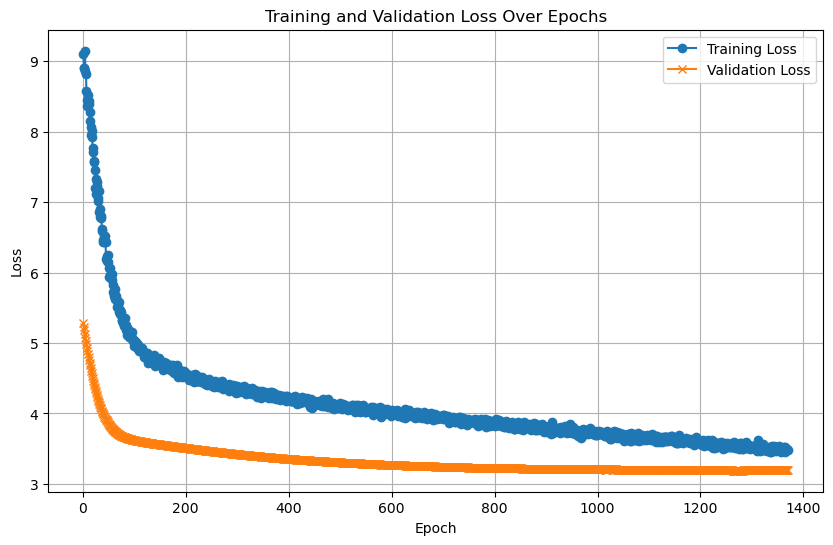

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 5.1677
Test Batch [20/40], Loss: 5.3603
Test Batch [30/40], Loss: 4.7372
Test Batch [40/40], Loss: 5.1463

Test Loss: 5.1715


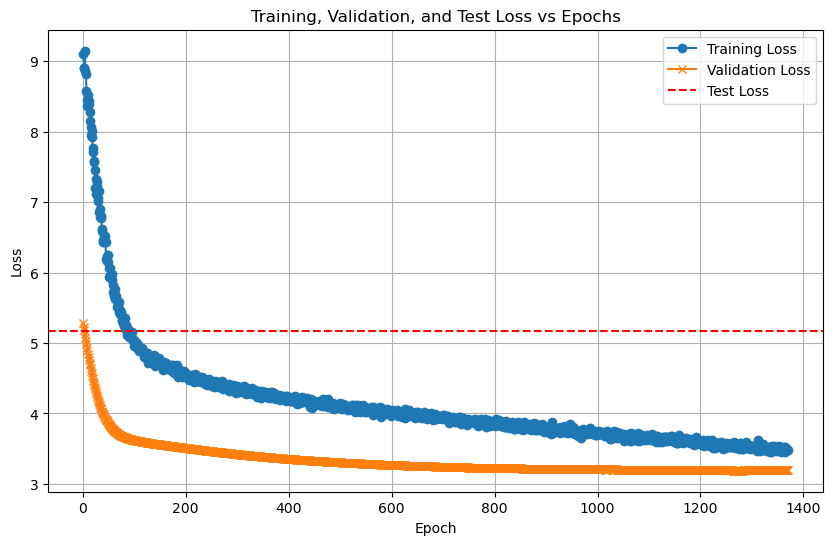

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 63.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.67      0.40      0.50         5
           2       0.00      0.00      0.00         5
           3       1.00      0.40      0.57         5
           4       0.60      0.60      0.60         5
           5       0.60      0.60      0.60         5
           6       0.83      1.00      0.91         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       0.50      0.80      0.62         5
          10       0.50      0.60      0.55         5
          11       0.43      0.60      0.50         5
          12       0.50      1.00      0.67         5
          13       0.6

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7838  |  Val Loss: 2.8035
Validation loss improved from inf to 2.8035.
[Epoch 2/1000] Train Loss: 2.7688  |  Val Loss: 2.7924
Validation loss improved from 2.8035 to 2.7924.
[Epoch 3/1000] Train Loss: 2.7550  |  Val Loss: 2.7825
Validation loss improved from 2.7924 to 2.7825.
[Epoch 4/1000] Train Loss: 2.7435  |  Val Loss: 2.7730
Validation loss improved from 2.7825 to 2.7730.
[Epoch 5/1000] Train Loss: 2.7316  |  Val Loss: 2.7633
Validation loss improved from 2.7730 to 2.7633.
[Epoch 6/1000] Train Loss: 2.7200  |  Val Loss: 2.7539
Validation loss improved from 2.7633 to 2.7539.
[Epoch 7/1000] Train Loss: 2.7091  |  Val Loss: 2.7450
Validation loss improved from 2.7539 to 2.7450.
[Epoch 8/1000] Train Loss: 2.6987  |  Val Loss: 2.7373
Validation loss improved from 2.7450 to 2.7373.
[Epoch 9/1000] Train Loss: 2.6894  |  Val Loss: 2.7305
Validation loss improved from 2.7373 to 2.7305.


[Epoch 10/1000] Train Loss: 2.6814  |  Val Loss: 2.7240
Validation loss improved from 2.7305 to 2.7240.
[Epoch 11/1000] Train Loss: 2.6737  |  Val Loss: 2.7180
Validation loss improved from 2.7240 to 2.7180.
[Epoch 12/1000] Train Loss: 2.6664  |  Val Loss: 2.7123
Validation loss improved from 2.7180 to 2.7123.
[Epoch 13/1000] Train Loss: 2.6595  |  Val Loss: 2.7071
Validation loss improved from 2.7123 to 2.7071.
[Epoch 14/1000] Train Loss: 2.6528  |  Val Loss: 2.7020
Validation loss improved from 2.7071 to 2.7020.
[Epoch 15/1000] Train Loss: 2.6460  |  Val Loss: 2.6969
Validation loss improved from 2.7020 to 2.6969.
[Epoch 16/1000] Train Loss: 2.6398  |  Val Loss: 2.6921
Validation loss improved from 2.6969 to 2.6921.
[Epoch 17/1000] Train Loss: 2.6335  |  Val Loss: 2.6872
Validation loss improved from 2.6921 to 2.6872.
[Epoch 18/1000] Train Loss: 2.6271  |  Val Loss: 2.6827
Validation loss improved from 2.6872 to 2.6827.
[Epoch 19/1000] Train Loss: 2.6209  |  Val Loss: 2.6783
Validati

[Epoch 27/1000] Train Loss: 2.5703  |  Val Loss: 2.6424
Validation loss improved from 2.6471 to 2.6424.
[Epoch 28/1000] Train Loss: 2.5635  |  Val Loss: 2.6377
Validation loss improved from 2.6424 to 2.6377.
[Epoch 29/1000] Train Loss: 2.5571  |  Val Loss: 2.6331
Validation loss improved from 2.6377 to 2.6331.
[Epoch 30/1000] Train Loss: 2.5508  |  Val Loss: 2.6285
Validation loss improved from 2.6331 to 2.6285.
[Epoch 31/1000] Train Loss: 2.5441  |  Val Loss: 2.6238
Validation loss improved from 2.6285 to 2.6238.
[Epoch 32/1000] Train Loss: 2.5374  |  Val Loss: 2.6192
Validation loss improved from 2.6238 to 2.6192.
[Epoch 33/1000] Train Loss: 2.5307  |  Val Loss: 2.6147
Validation loss improved from 2.6192 to 2.6147.
[Epoch 34/1000] Train Loss: 2.5241  |  Val Loss: 2.6102
Validation loss improved from 2.6147 to 2.6102.
[Epoch 35/1000] Train Loss: 2.5180  |  Val Loss: 2.6057
Validation loss improved from 2.6102 to 2.6057.
[Epoch 36/1000] Train Loss: 2.5111  |  Val Loss: 2.6012
Validati

[Epoch 39/1000] Train Loss: 2.4911  |  Val Loss: 2.5885
Validation loss improved from 2.5927 to 2.5885.
[Epoch 40/1000] Train Loss: 2.4845  |  Val Loss: 2.5842
Validation loss improved from 2.5885 to 2.5842.
[Epoch 41/1000] Train Loss: 2.4779  |  Val Loss: 2.5800
Validation loss improved from 2.5842 to 2.5800.
[Epoch 42/1000] Train Loss: 2.4711  |  Val Loss: 2.5757
Validation loss improved from 2.5800 to 2.5757.
[Epoch 43/1000] Train Loss: 2.4650  |  Val Loss: 2.5710
Validation loss improved from 2.5757 to 2.5710.
[Epoch 44/1000] Train Loss: 2.4576  |  Val Loss: 2.5661
Validation loss improved from 2.5710 to 2.5661.
[Epoch 45/1000] Train Loss: 2.4512  |  Val Loss: 2.5610
Validation loss improved from 2.5661 to 2.5610.
[Epoch 46/1000] Train Loss: 2.4444  |  Val Loss: 2.5558
Validation loss improved from 2.5610 to 2.5558.
[Epoch 47/1000] Train Loss: 2.4375  |  Val Loss: 2.5506
Validation loss improved from 2.5558 to 2.5506.
[Epoch 48/1000] Train Loss: 2.4305  |  Val Loss: 2.5452
Validati

[Epoch 58/1000] Train Loss: 2.3580  |  Val Loss: 2.4915
Validation loss improved from 2.4970 to 2.4915.
[Epoch 59/1000] Train Loss: 2.3502  |  Val Loss: 2.4860
Validation loss improved from 2.4915 to 2.4860.
[Epoch 60/1000] Train Loss: 2.3425  |  Val Loss: 2.4806
Validation loss improved from 2.4860 to 2.4806.
[Epoch 61/1000] Train Loss: 2.3349  |  Val Loss: 2.4749
Validation loss improved from 2.4806 to 2.4749.
[Epoch 62/1000] Train Loss: 2.3269  |  Val Loss: 2.4694
Validation loss improved from 2.4749 to 2.4694.
[Epoch 63/1000] Train Loss: 2.3193  |  Val Loss: 2.4635
Validation loss improved from 2.4694 to 2.4635.
[Epoch 64/1000] Train Loss: 2.3115  |  Val Loss: 2.4578
Validation loss improved from 2.4635 to 2.4578.
[Epoch 65/1000] Train Loss: 2.3032  |  Val Loss: 2.4521
Validation loss improved from 2.4578 to 2.4521.
[Epoch 66/1000] Train Loss: 2.2959  |  Val Loss: 2.4464
Validation loss improved from 2.4521 to 2.4464.
[Epoch 67/1000] Train Loss: 2.2881  |  Val Loss: 2.4409
Validati

[Epoch 69/1000] Train Loss: 2.2723  |  Val Loss: 2.4299
Validation loss improved from 2.4355 to 2.4299.
[Epoch 70/1000] Train Loss: 2.2644  |  Val Loss: 2.4241
Validation loss improved from 2.4299 to 2.4241.
[Epoch 71/1000] Train Loss: 2.2567  |  Val Loss: 2.4183
Validation loss improved from 2.4241 to 2.4183.
[Epoch 72/1000] Train Loss: 2.2489  |  Val Loss: 2.4125
Validation loss improved from 2.4183 to 2.4125.
[Epoch 73/1000] Train Loss: 2.2415  |  Val Loss: 2.4067
Validation loss improved from 2.4125 to 2.4067.
[Epoch 74/1000] Train Loss: 2.2338  |  Val Loss: 2.4011
Validation loss improved from 2.4067 to 2.4011.
[Epoch 75/1000] Train Loss: 2.2261  |  Val Loss: 2.3954
Validation loss improved from 2.4011 to 2.3954.
[Epoch 76/1000] Train Loss: 2.2190  |  Val Loss: 2.3899
Validation loss improved from 2.3954 to 2.3899.
[Epoch 77/1000] Train Loss: 2.2118  |  Val Loss: 2.3845
Validation loss improved from 2.3899 to 2.3845.
[Epoch 78/1000] Train Loss: 2.2042  |  Val Loss: 2.3793
Validati

[Epoch 88/1000] Train Loss: 2.1344  |  Val Loss: 2.3279
Validation loss improved from 2.3327 to 2.3279.
[Epoch 89/1000] Train Loss: 2.1277  |  Val Loss: 2.3227
Validation loss improved from 2.3279 to 2.3227.
[Epoch 90/1000] Train Loss: 2.1212  |  Val Loss: 2.3176
Validation loss improved from 2.3227 to 2.3176.
[Epoch 91/1000] Train Loss: 2.1143  |  Val Loss: 2.3124
Validation loss improved from 2.3176 to 2.3124.
[Epoch 92/1000] Train Loss: 2.1078  |  Val Loss: 2.3073
Validation loss improved from 2.3124 to 2.3073.
[Epoch 93/1000] Train Loss: 2.1015  |  Val Loss: 2.3024
Validation loss improved from 2.3073 to 2.3024.
[Epoch 94/1000] Train Loss: 2.0949  |  Val Loss: 2.2977
Validation loss improved from 2.3024 to 2.2977.
[Epoch 95/1000] Train Loss: 2.0884  |  Val Loss: 2.2930
Validation loss improved from 2.2977 to 2.2930.
[Epoch 96/1000] Train Loss: 2.0819  |  Val Loss: 2.2887
Validation loss improved from 2.2930 to 2.2887.


[Epoch 97/1000] Train Loss: 2.0760  |  Val Loss: 2.2850
Validation loss improved from 2.2887 to 2.2850.
[Epoch 98/1000] Train Loss: 2.0693  |  Val Loss: 2.2807
Validation loss improved from 2.2850 to 2.2807.
[Epoch 99/1000] Train Loss: 2.0630  |  Val Loss: 2.2765
Validation loss improved from 2.2807 to 2.2765.
[Epoch 100/1000] Train Loss: 2.0567  |  Val Loss: 2.2724
Validation loss improved from 2.2765 to 2.2724.
[Epoch 101/1000] Train Loss: 2.0506  |  Val Loss: 2.2686
Validation loss improved from 2.2724 to 2.2686.
[Epoch 102/1000] Train Loss: 2.0442  |  Val Loss: 2.2647
Validation loss improved from 2.2686 to 2.2647.
[Epoch 103/1000] Train Loss: 2.0380  |  Val Loss: 2.2602
Validation loss improved from 2.2647 to 2.2602.
[Epoch 104/1000] Train Loss: 2.0315  |  Val Loss: 2.2557
Validation loss improved from 2.2602 to 2.2557.
[Epoch 105/1000] Train Loss: 2.0253  |  Val Loss: 2.2510
Validation loss improved from 2.2557 to 2.2510.
[Epoch 106/1000] Train Loss: 2.0189  |  Val Loss: 2.2465
V

[Epoch 116/1000] Train Loss: 1.9565  |  Val Loss: 2.2014
Validation loss improved from 2.2056 to 2.2014.
[Epoch 117/1000] Train Loss: 1.9501  |  Val Loss: 2.1966
Validation loss improved from 2.2014 to 2.1966.
[Epoch 118/1000] Train Loss: 1.9437  |  Val Loss: 2.1918
Validation loss improved from 2.1966 to 2.1918.
[Epoch 119/1000] Train Loss: 1.9373  |  Val Loss: 2.1871
Validation loss improved from 2.1918 to 2.1871.
[Epoch 120/1000] Train Loss: 1.9309  |  Val Loss: 2.1823
Validation loss improved from 2.1871 to 2.1823.
[Epoch 121/1000] Train Loss: 1.9247  |  Val Loss: 2.1773
Validation loss improved from 2.1823 to 2.1773.
[Epoch 122/1000] Train Loss: 1.9181  |  Val Loss: 2.1727
Validation loss improved from 2.1773 to 2.1727.
[Epoch 123/1000] Train Loss: 1.9117  |  Val Loss: 2.1680
Validation loss improved from 2.1727 to 2.1680.
[Epoch 124/1000] Train Loss: 1.9053  |  Val Loss: 2.1632
Validation loss improved from 2.1680 to 2.1632.
[Epoch 125/1000] Train Loss: 1.8986  |  Val Loss: 2.158

[Epoch 126/1000] Train Loss: 1.8922  |  Val Loss: 2.1542
Validation loss improved from 2.1587 to 2.1542.
[Epoch 127/1000] Train Loss: 1.8855  |  Val Loss: 2.1495
Validation loss improved from 2.1542 to 2.1495.
[Epoch 128/1000] Train Loss: 1.8790  |  Val Loss: 2.1445
Validation loss improved from 2.1495 to 2.1445.
[Epoch 129/1000] Train Loss: 1.8721  |  Val Loss: 2.1393
Validation loss improved from 2.1445 to 2.1393.
[Epoch 130/1000] Train Loss: 1.8653  |  Val Loss: 2.1339
Validation loss improved from 2.1393 to 2.1339.
[Epoch 131/1000] Train Loss: 1.8586  |  Val Loss: 2.1283
Validation loss improved from 2.1339 to 2.1283.
[Epoch 132/1000] Train Loss: 1.8518  |  Val Loss: 2.1231
Validation loss improved from 2.1283 to 2.1231.
[Epoch 133/1000] Train Loss: 1.8451  |  Val Loss: 2.1178
Validation loss improved from 2.1231 to 2.1178.
[Epoch 134/1000] Train Loss: 1.8384  |  Val Loss: 2.1127
Validation loss improved from 2.1178 to 2.1127.
[Epoch 135/1000] Train Loss: 1.8313  |  Val Loss: 2.107

[Epoch 145/1000] Train Loss: 1.7612  |  Val Loss: 2.0582
Validation loss improved from 2.0629 to 2.0582.
[Epoch 146/1000] Train Loss: 1.7541  |  Val Loss: 2.0535
Validation loss improved from 2.0582 to 2.0535.
[Epoch 147/1000] Train Loss: 1.7466  |  Val Loss: 2.0491
Validation loss improved from 2.0535 to 2.0491.
[Epoch 148/1000] Train Loss: 1.7400  |  Val Loss: 2.0441
Validation loss improved from 2.0491 to 2.0441.
[Epoch 149/1000] Train Loss: 1.7321  |  Val Loss: 2.0388
Validation loss improved from 2.0441 to 2.0388.
[Epoch 150/1000] Train Loss: 1.7245  |  Val Loss: 2.0336
Validation loss improved from 2.0388 to 2.0336.
[Epoch 151/1000] Train Loss: 1.7171  |  Val Loss: 2.0285
Validation loss improved from 2.0336 to 2.0285.
[Epoch 152/1000] Train Loss: 1.7097  |  Val Loss: 2.0237
Validation loss improved from 2.0285 to 2.0237.
[Epoch 153/1000] Train Loss: 1.7024  |  Val Loss: 2.0196
Validation loss improved from 2.0237 to 2.0196.
[Epoch 154/1000] Train Loss: 1.6949  |  Val Loss: 2.014

[Epoch 159/1000] Train Loss: 1.6570  |  Val Loss: 1.9903
Validation loss improved from 1.9951 to 1.9903.
[Epoch 160/1000] Train Loss: 1.6497  |  Val Loss: 1.9848
Validation loss improved from 1.9903 to 1.9848.
[Epoch 161/1000] Train Loss: 1.6417  |  Val Loss: 1.9795
Validation loss improved from 1.9848 to 1.9795.
[Epoch 162/1000] Train Loss: 1.6341  |  Val Loss: 1.9737
Validation loss improved from 1.9795 to 1.9737.
[Epoch 163/1000] Train Loss: 1.6268  |  Val Loss: 1.9681
Validation loss improved from 1.9737 to 1.9681.
[Epoch 164/1000] Train Loss: 1.6190  |  Val Loss: 1.9635
Validation loss improved from 1.9681 to 1.9635.
[Epoch 165/1000] Train Loss: 1.6117  |  Val Loss: 1.9593
Validation loss improved from 1.9635 to 1.9593.
[Epoch 166/1000] Train Loss: 1.6040  |  Val Loss: 1.9553
Validation loss improved from 1.9593 to 1.9553.
[Epoch 167/1000] Train Loss: 1.5963  |  Val Loss: 1.9508
Validation loss improved from 1.9553 to 1.9508.
[Epoch 168/1000] Train Loss: 1.5888  |  Val Loss: 1.946

[Epoch 174/1000] Train Loss: 1.5435  |  Val Loss: 1.9163
Validation loss improved from 1.9222 to 1.9163.
[Epoch 175/1000] Train Loss: 1.5362  |  Val Loss: 1.9105
Validation loss improved from 1.9163 to 1.9105.
[Epoch 176/1000] Train Loss: 1.5286  |  Val Loss: 1.9048
Validation loss improved from 1.9105 to 1.9048.
[Epoch 177/1000] Train Loss: 1.5209  |  Val Loss: 1.8994
Validation loss improved from 1.9048 to 1.8994.
[Epoch 178/1000] Train Loss: 1.5134  |  Val Loss: 1.8937
Validation loss improved from 1.8994 to 1.8937.
[Epoch 179/1000] Train Loss: 1.5061  |  Val Loss: 1.8879
Validation loss improved from 1.8937 to 1.8879.
[Epoch 180/1000] Train Loss: 1.4985  |  Val Loss: 1.8833
Validation loss improved from 1.8879 to 1.8833.
[Epoch 181/1000] Train Loss: 1.4911  |  Val Loss: 1.8788
Validation loss improved from 1.8833 to 1.8788.
[Epoch 182/1000] Train Loss: 1.4838  |  Val Loss: 1.8747
Validation loss improved from 1.8788 to 1.8747.
[Epoch 183/1000] Train Loss: 1.4761  |  Val Loss: 1.870

[Epoch 190/1000] Train Loss: 1.4254  |  Val Loss: 1.8353
Validation loss improved from 1.8406 to 1.8353.
[Epoch 191/1000] Train Loss: 1.4184  |  Val Loss: 1.8302
Validation loss improved from 1.8353 to 1.8302.
[Epoch 192/1000] Train Loss: 1.4109  |  Val Loss: 1.8253
Validation loss improved from 1.8302 to 1.8253.
[Epoch 193/1000] Train Loss: 1.4037  |  Val Loss: 1.8205
Validation loss improved from 1.8253 to 1.8205.
[Epoch 194/1000] Train Loss: 1.3967  |  Val Loss: 1.8166
Validation loss improved from 1.8205 to 1.8166.
[Epoch 195/1000] Train Loss: 1.3897  |  Val Loss: 1.8127
Validation loss improved from 1.8166 to 1.8127.
[Epoch 196/1000] Train Loss: 1.3823  |  Val Loss: 1.8090
Validation loss improved from 1.8127 to 1.8090.
[Epoch 197/1000] Train Loss: 1.3756  |  Val Loss: 1.8056
Validation loss improved from 1.8090 to 1.8056.
[Epoch 198/1000] Train Loss: 1.3684  |  Val Loss: 1.8018
Validation loss improved from 1.8056 to 1.8018.
[Epoch 199/1000] Train Loss: 1.3618  |  Val Loss: 1.798

[Epoch 203/1000] Train Loss: 1.3332  |  Val Loss: 1.7828
Validation loss improved from 1.7872 to 1.7828.
[Epoch 204/1000] Train Loss: 1.3264  |  Val Loss: 1.7782
Validation loss improved from 1.7828 to 1.7782.
[Epoch 205/1000] Train Loss: 1.3197  |  Val Loss: 1.7738
Validation loss improved from 1.7782 to 1.7738.
[Epoch 206/1000] Train Loss: 1.3126  |  Val Loss: 1.7701
Validation loss improved from 1.7738 to 1.7701.
[Epoch 207/1000] Train Loss: 1.3059  |  Val Loss: 1.7658
Validation loss improved from 1.7701 to 1.7658.
[Epoch 208/1000] Train Loss: 1.2988  |  Val Loss: 1.7620
Validation loss improved from 1.7658 to 1.7620.
[Epoch 209/1000] Train Loss: 1.2920  |  Val Loss: 1.7581
Validation loss improved from 1.7620 to 1.7581.
[Epoch 210/1000] Train Loss: 1.2853  |  Val Loss: 1.7544
Validation loss improved from 1.7581 to 1.7544.
[Epoch 211/1000] Train Loss: 1.2787  |  Val Loss: 1.7504
Validation loss improved from 1.7544 to 1.7504.
[Epoch 212/1000] Train Loss: 1.2720  |  Val Loss: 1.746

[Epoch 220/1000] Train Loss: 1.2205  |  Val Loss: 1.7205
Validation loss improved from 1.7231 to 1.7205.
[Epoch 221/1000] Train Loss: 1.2141  |  Val Loss: 1.7180
Validation loss improved from 1.7205 to 1.7180.
[Epoch 222/1000] Train Loss: 1.2082  |  Val Loss: 1.7155
Validation loss improved from 1.7180 to 1.7155.
[Epoch 223/1000] Train Loss: 1.2020  |  Val Loss: 1.7123
Validation loss improved from 1.7155 to 1.7123.
[Epoch 224/1000] Train Loss: 1.1955  |  Val Loss: 1.7091
Validation loss improved from 1.7123 to 1.7091.
[Epoch 225/1000] Train Loss: 1.1899  |  Val Loss: 1.7068
Validation loss improved from 1.7091 to 1.7068.
[Epoch 226/1000] Train Loss: 1.1832  |  Val Loss: 1.7045
Validation loss improved from 1.7068 to 1.7045.
[Epoch 227/1000] Train Loss: 1.1770  |  Val Loss: 1.7025
Validation loss improved from 1.7045 to 1.7025.
[Epoch 228/1000] Train Loss: 1.1716  |  Val Loss: 1.7001
Validation loss improved from 1.7025 to 1.7001.
[Epoch 229/1000] Train Loss: 1.1656  |  Val Loss: 1.697

[Epoch 233/1000] Train Loss: 1.1424  |  Val Loss: 1.6910
Validation loss improved from 1.6922 to 1.6910.
[Epoch 234/1000] Train Loss: 1.1363  |  Val Loss: 1.6891
Validation loss improved from 1.6910 to 1.6891.
[Epoch 235/1000] Train Loss: 1.1306  |  Val Loss: 1.6874
Validation loss improved from 1.6891 to 1.6874.
[Epoch 236/1000] Train Loss: 1.1253  |  Val Loss: 1.6860
Validation loss improved from 1.6874 to 1.6860.
[Epoch 237/1000] Train Loss: 1.1195  |  Val Loss: 1.6843
Validation loss improved from 1.6860 to 1.6843.
[Epoch 238/1000] Train Loss: 1.1143  |  Val Loss: 1.6815
Validation loss improved from 1.6843 to 1.6815.
[Epoch 239/1000] Train Loss: 1.1085  |  Val Loss: 1.6789
Validation loss improved from 1.6815 to 1.6789.
[Epoch 240/1000] Train Loss: 1.1029  |  Val Loss: 1.6766
Validation loss improved from 1.6789 to 1.6766.
[Epoch 241/1000] Train Loss: 1.0978  |  Val Loss: 1.6747
Validation loss improved from 1.6766 to 1.6747.
[Epoch 242/1000] Train Loss: 1.0923  |  Val Loss: 1.672

[Epoch 247/1000] Train Loss: 1.0664  |  Val Loss: 1.6645
Validation loss improved from 1.6658 to 1.6645.
[Epoch 248/1000] Train Loss: 1.0616  |  Val Loss: 1.6628
Validation loss improved from 1.6645 to 1.6628.
[Epoch 249/1000] Train Loss: 1.0564  |  Val Loss: 1.6614
Validation loss improved from 1.6628 to 1.6614.
[Epoch 250/1000] Train Loss: 1.0518  |  Val Loss: 1.6594
Validation loss improved from 1.6614 to 1.6594.
[Epoch 251/1000] Train Loss: 1.0464  |  Val Loss: 1.6579
Validation loss improved from 1.6594 to 1.6579.
[Epoch 252/1000] Train Loss: 1.0423  |  Val Loss: 1.6559
Validation loss improved from 1.6579 to 1.6559.
[Epoch 253/1000] Train Loss: 1.0370  |  Val Loss: 1.6559
Validation loss improved from 1.6559 to 1.6559.
[Epoch 254/1000] Train Loss: 1.0322  |  Val Loss: 1.6554
Validation loss improved from 1.6559 to 1.6554.
[Epoch 255/1000] Train Loss: 1.0274  |  Val Loss: 1.6540
Validation loss improved from 1.6554 to 1.6540.
[Epoch 256/1000] Train Loss: 1.0227  |  Val Loss: 1.652

[Epoch 259/1000] Train Loss: 1.0089  |  Val Loss: 1.6476
Validation loss improved from 1.6493 to 1.6476.
[Epoch 260/1000] Train Loss: 1.0043  |  Val Loss: 1.6452
Validation loss improved from 1.6476 to 1.6452.
[Epoch 261/1000] Train Loss: 0.9999  |  Val Loss: 1.6441
Validation loss improved from 1.6452 to 1.6441.
[Epoch 262/1000] Train Loss: 0.9955  |  Val Loss: 1.6435
Validation loss improved from 1.6441 to 1.6435.
[Epoch 263/1000] Train Loss: 0.9912  |  Val Loss: 1.6441
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.9865  |  Val Loss: 1.6442
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.9819  |  Val Loss: 1.6444
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.9776  |  Val Loss: 1.6434
Validation loss improved from 1.6435 to 1.6434.
[Epoch 267/1000] Train Loss: 0.9733  |  Val Loss: 1.6416
Validation loss improved from 1.6434 to 1.6416.
[Epoch 268/1000] Train Loss: 0.9695  

[Epoch 276/1000] Train Loss: 0.9365  |  Val Loss: 1.6375
Validation loss improved from 1.6394 to 1.6375.
[Epoch 277/1000] Train Loss: 0.9324  |  Val Loss: 1.6371
Validation loss improved from 1.6375 to 1.6371.
[Epoch 278/1000] Train Loss: 0.9285  |  Val Loss: 1.6363
Validation loss improved from 1.6371 to 1.6363.
[Epoch 279/1000] Train Loss: 0.9245  |  Val Loss: 1.6353
Validation loss improved from 1.6363 to 1.6353.
[Epoch 280/1000] Train Loss: 0.9210  |  Val Loss: 1.6345
Validation loss improved from 1.6353 to 1.6345.
[Epoch 281/1000] Train Loss: 0.9171  |  Val Loss: 1.6322
Validation loss improved from 1.6345 to 1.6322.
[Epoch 282/1000] Train Loss: 0.9137  |  Val Loss: 1.6312
Validation loss improved from 1.6322 to 1.6312.
[Epoch 283/1000] Train Loss: 0.9096  |  Val Loss: 1.6304
Validation loss improved from 1.6312 to 1.6304.
[Epoch 284/1000] Train Loss: 0.9061  |  Val Loss: 1.6292
Validation loss improved from 1.6304 to 1.6292.
[Epoch 285/1000] Train Loss: 0.9024  |  Val Loss: 1.628

[Epoch 288/1000] Train Loss: 0.8921  |  Val Loss: 1.6288
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.8880  |  Val Loss: 1.6284
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.8846  |  Val Loss: 1.6284
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 291/1000] Train Loss: 0.8811  |  Val Loss: 1.6286
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 292/1000] Train Loss: 0.8777  |  Val Loss: 1.6289
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 293/1000] Train Loss: 0.8742  |  Val Loss: 1.6302
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 294/1000] Train Loss: 0.8709  |  Val Loss: 1.6299
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 295/1000] Train Loss: 0.8677  |  Val Loss: 1.6296
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 296/1000] Train Loss: 0.8643  |  Val Loss: 1.6300
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 305/1000] Train Loss: 0.8356  |  Val Loss: 1.6322
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 306/1000] Train Loss: 0.8326  |  Val Loss: 1.6318
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 307/1000] Train Loss: 0.8290  |  Val Loss: 1.6309
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 308/1000] Train Loss: 0.8259  |  Val Loss: 1.6294
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 309/1000] Train Loss: 0.8226  |  Val Loss: 1.6296
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 310/1000] Train Loss: 0.8189  |  Val Loss: 1.6287
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 311/1000] Train Loss: 0.8166  |  Val Loss: 1.6288
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 312/1000] Train Loss: 0.8147  |  Val Loss: 1.6285
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 313/1000] Train Loss: 0.8110  |  Val Loss: 1.6284
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 319/1000] Train Loss: 0.7925  |  Val Loss: 1.6315
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 320/1000] Train Loss: 0.7893  |  Val Loss: 1.6303
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 321/1000] Train Loss: 0.7865  |  Val Loss: 1.6289
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 322/1000] Train Loss: 0.7835  |  Val Loss: 1.6283
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 323/1000] Train Loss: 0.7803  |  Val Loss: 1.6273
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 324/1000] Train Loss: 0.7778  |  Val Loss: 1.6260
Validation loss improved from 1.6267 to 1.6260.
[Epoch 325/1000] Train Loss: 0.7750  |  Val Loss: 1.6264
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 326/1000] Train Loss: 0.7723  |  Val Loss: 1.6270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 327/1000] Train Loss: 0.7700  |  Val Loss: 1.6267
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 335/1000] Train Loss: 0.7483  |  Val Loss: 1.6254
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 336/1000] Train Loss: 0.7462  |  Val Loss: 1.6263
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 337/1000] Train Loss: 0.7439  |  Val Loss: 1.6269
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 338/1000] Train Loss: 0.7408  |  Val Loss: 1.6269
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 339/1000] Train Loss: 0.7385  |  Val Loss: 1.6266
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 340/1000] Train Loss: 0.7364  |  Val Loss: 1.6256
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 341/1000] Train Loss: 0.7339  |  Val Loss: 1.6261
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 342/1000] Train Loss: 0.7314  |  Val Loss: 1.6268
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 343/1000] Train Loss: 0.7288  |  Val Loss: 1.6285
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 348/1000] Train Loss: 0.7176  |  Val Loss: 1.6319
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 349/1000] Train Loss: 0.7155  |  Val Loss: 1.6325
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 350/1000] Train Loss: 0.7130  |  Val Loss: 1.6320
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 351/1000] Train Loss: 0.7102  |  Val Loss: 1.6314
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 352/1000] Train Loss: 0.7083  |  Val Loss: 1.6312
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 353/1000] Train Loss: 0.7059  |  Val Loss: 1.6318
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 354/1000] Train Loss: 0.7040  |  Val Loss: 1.6332
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 355/1000] Train Loss: 0.7021  |  Val Loss: 1.6356
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 356/1000] Train Loss: 0.6999  |  Val Loss: 1.6362
!! Validation loss did NOT improve !! Patience:

[Epoch 364/1000] Train Loss: 0.6831  |  Val Loss: 1.6438
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 365/1000] Train Loss: 0.6808  |  Val Loss: 1.6453
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 366/1000] Train Loss: 0.6791  |  Val Loss: 1.6466
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 367/1000] Train Loss: 0.6768  |  Val Loss: 1.6477
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 368/1000] Train Loss: 0.6752  |  Val Loss: 1.6461
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 369/1000] Train Loss: 0.6722  |  Val Loss: 1.6455
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 370/1000] Train Loss: 0.6704  |  Val Loss: 1.6443
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 371/1000] Train Loss: 0.6687  |  Val Loss: 1.6439
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 372/1000] Train Loss: 0.6667  |  Val Loss: 1.6454
!! Validation loss did NOT improve !! Patience:

[Epoch 376/1000] Train Loss: 0.6597  |  Val Loss: 1.6566
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 377/1000] Train Loss: 0.6576  |  Val Loss: 1.6572
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 378/1000] Train Loss: 0.6558  |  Val Loss: 1.6574
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 379/1000] Train Loss: 0.6535  |  Val Loss: 1.6570
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 380/1000] Train Loss: 0.6518  |  Val Loss: 1.6565
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 381/1000] Train Loss: 0.6497  |  Val Loss: 1.6573
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 382/1000] Train Loss: 0.6477  |  Val Loss: 1.6575
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 383/1000] Train Loss: 0.6456  |  Val Loss: 1.6574
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 384/1000] Train Loss: 0.6439  |  Val Loss: 1.6588
!! Validation loss did NOT improve !! Patience:

[Epoch 391/1000] Train Loss: 0.6316  |  Val Loss: 1.6697
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 392/1000] Train Loss: 0.6303  |  Val Loss: 1.6718
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 393/1000] Train Loss: 0.6281  |  Val Loss: 1.6723
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 394/1000] Train Loss: 0.6264  |  Val Loss: 1.6735
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 395/1000] Train Loss: 0.6245  |  Val Loss: 1.6751
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 396/1000] Train Loss: 0.6227  |  Val Loss: 1.6762
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 397/1000] Train Loss: 0.6211  |  Val Loss: 1.6760
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 398/1000] Train Loss: 0.6195  |  Val Loss: 1.6765
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 399/1000] Train Loss: 0.6178  |  Val Loss: 1.6787
!! Validation loss did NOT improve !! Patience:

[Epoch 403/1000] Train Loss: 0.6114  |  Val Loss: 1.6816
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 404/1000] Train Loss: 0.6096  |  Val Loss: 1.6838
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 405/1000] Train Loss: 0.6082  |  Val Loss: 1.6846
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 406/1000] Train Loss: 0.6061  |  Val Loss: 1.6866
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 407/1000] Train Loss: 0.6048  |  Val Loss: 1.6890
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 408/1000] Train Loss: 0.6030  |  Val Loss: 1.6911
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 409/1000] Train Loss: 0.6020  |  Val Loss: 1.6941
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 410/1000] Train Loss: 0.6002  |  Val Loss: 1.6957
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 411/1000] Train Loss: 0.5980  |  Val Loss: 1.6966
!! Validation loss did NOT improve !! Patience:

[Epoch 424/1000] Train Loss: 0.5789  |  Val Loss: 1.7196
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 425/1000] Train Loss: 0.5774  |  Val Loss: 1.7175
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 426/1000] Train Loss: 0.5753  |  Val Loss: 1.7154
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 427/1000] Train Loss: 0.5739  |  Val Loss: 1.7145
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 428/1000] Train Loss: 0.5722  |  Val Loss: 1.7138
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 429/1000] Train Loss: 0.5706  |  Val Loss: 1.7151
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 430/1000] Train Loss: 0.5696  |  Val Loss: 1.7163
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 431/1000] Train Loss: 0.5682  |  Val Loss: 1.7185
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 431 !!
No improvement for 100 epochs.


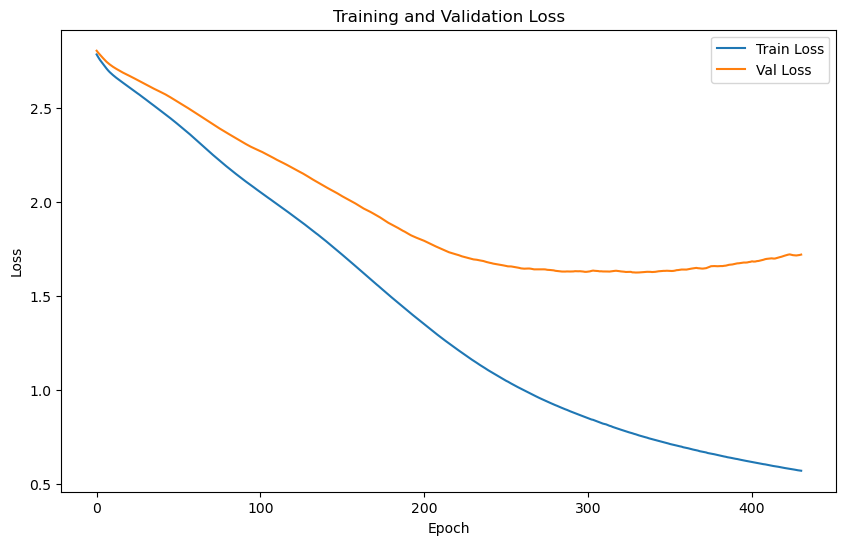

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.3609 | Test Accuracy: 51.08%


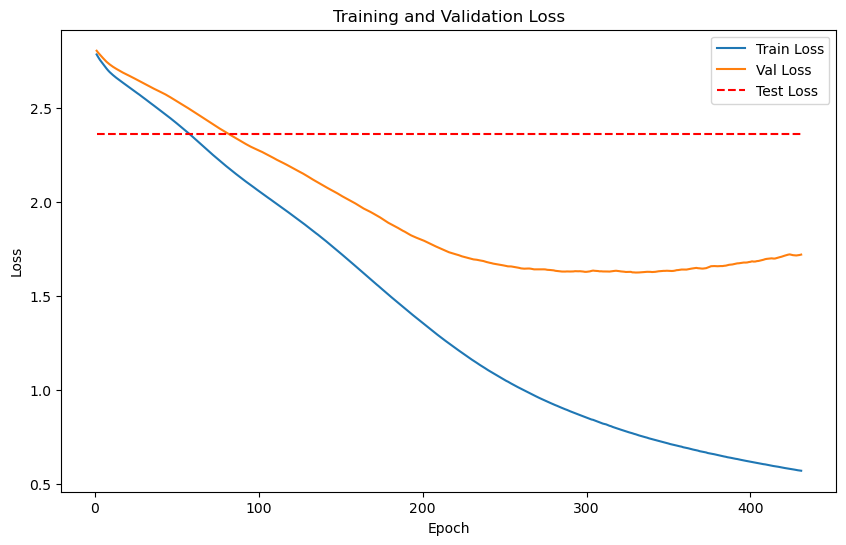

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.3979
Epoch [1/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.4633

Validation loss improved from inf to 0.4633. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.3986
Epoch [2/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.4625

Validation loss improved from 0.4633 to 0.4625. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.3987
Epoch [3/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.4617

Validation loss improved from 0.4625 to 0.4617. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5231
    Batch [2/2], Val Loss: 0.3984
Epoch [4/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4608

Validation loss improved from 0.4617 to 0.4608. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.3979
Epoch [5/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.4599

Validation loss improved from 0.4608 to 0.4599. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.3972
Epoch [6/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.4588

Validation loss improved from 0.4599 to 0.4588. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.3965
Epoch [7/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.4577

Validation loss improved from 0.4588 to 0.4577. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.3955
Epoch [8/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.4563

Validation loss improved from 0.4577 to 0.4563. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.3945
Epoch [9/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.4548

Validation loss improved from 0.4563 to 0.4548. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.3938
Epoch [10/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4535

Validation loss improved from 0.4548 to 0.4535. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.3930
Epoch [11/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.4522

Validation loss improved from 0.4535 to 0.4522. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.3920
Epoch [12/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.4509

Validation loss improved from 0.4522 to 0.4509. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.3908
Epoch [13/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4494

Validation loss improved from 0.4509 to 0.4494. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.3899
Epoch [14/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.4479

Validation loss improved from 0.4494 to 0.4479. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.3889
Epoch [15/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4465

Validation loss improved from 0.4479 to 0.4465. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.3881
Epoch [16/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4451

Validation loss improved from 0.4465 to 0.4451. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3870
Epoch [17/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4438

Validation loss improved from 0.4451 to 0.4438. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.3860
Epoch [18/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4426

Validation loss improved from 0.4438 to 0.4426. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.3850
Epoch [19/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.4415

Validation loss improved from 0.4426 to 0.4415. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.3840
Epoch [20/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4405

Validation loss improved from 0.4415 to 0.4405. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.3832
Epoch [21/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4397

Validation loss improved from 0.4405 to 0.4397. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.3823
Epoch [22/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.4389

Validation loss improved from 0.4397 to 0.4389. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.3816
Epoch [23/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4382

Validation loss improved from 0.4389 to 0.4382. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3809
Epoch [24/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4375

Validation loss improved from 0.4382 to 0.4375. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.3803
Epoch [25/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4369

Validation loss improved from 0.4375 to 0.4369. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3799
Epoch [26/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4364

Validation loss improved from 0.4369 to 0.4364. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.3796
Epoch [27/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4359

Validation loss improved from 0.4364 to 0.4359. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.3794
Epoch [28/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4355

Validation loss improved from 0.4359 to 0.4355. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.3791
Epoch [29/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4350

Validation loss improved from 0.4355 to 0.4350. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.3788
Epoch [30/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4346

Validation loss improved from 0.4350 to 0.4346. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.3786
Epoch [31/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4342

Validation loss improved from 0.4346 to 0.4342. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.3784
Epoch [32/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4339

Validation loss improved from 0.4342 to 0.4339. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.3782
Epoch [33/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4336

Validation loss improved from 0.4339 to 0.4336. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.3780
Epoch [34/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4333

Validation loss improved from 0.4336 to 0.4333. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.3779
Epoch [35/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4331

Validation loss improved from 0.4333 to 0.4331. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.3780
Epoch [36/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4329

Validation loss improved from 0.4331 to 0.4329. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.3780
Epoch [37/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4328

Validation loss improved from 0.4329 to 0.4328. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.3780
Epoch [38/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4326

Validation loss improved from 0.4328 to 0.4326. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.3780
Epoch [39/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4325

Validation loss improved from 0.4326 to 0.4325. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3780
Epoch [40/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4323

Validation loss improved from 0.4325 to 0.4323. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.3780
Epoch [41/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4322

Validation loss improved from 0.4323 to 0.4322. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.3781
Epoch [42/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4320

Validation loss improved from 0.4322 to 0.4320. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.3780
Epoch [43/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4319

Validation loss improved from 0.4320 to 0.4319. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.3780
Epoch [44/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4318

Validation loss improved from 0.4319 to 0.4318. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.3780
Epoch [45/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4316

Validation loss improved from 0.4318 to 0.4316. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.3780
Epoch [46/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4315

Validation loss improved from 0.4316 to 0.4315. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.3780
Epoch [47/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4314

Validation loss improved from 0.4315 to 0.4314. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3779
Epoch [48/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4312

Validation loss improved from 0.4314 to 0.4312. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.3779
Epoch [49/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4311

Validation loss improved from 0.4312 to 0.4311. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3779
Epoch [50/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4310

Validation loss improved from 0.4311 to 0.4310. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3778
Epoch [51/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4309

Validation loss improved from 0.4310 to 0.4309. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3778
Epoch [52/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4307

Validation loss improved from 0.4309 to 0.4307. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3778
Epoch [53/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4306

Validation loss improved from 0.4307 to 0.4306. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.3777
Epoch [54/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4305

Validation loss improved from 0.4306 to 0.4305. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3776
Epoch [55/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4303

Validation loss improved from 0.4305 to 0.4303. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.3774
Epoch [56/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4301

Validation loss improved from 0.4303 to 0.4301. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.3772
Epoch [57/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4299

Validation loss improved from 0.4301 to 0.4299. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3770
Epoch [58/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4297

Validation loss improved from 0.4299 to 0.4297. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.3768
Epoch [59/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4295

Validation loss improved from 0.4297 to 0.4295. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.3766
Epoch [60/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4292

Validation loss improved from 0.4295 to 0.4292. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.3765
Epoch [61/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4291

Validation loss improved from 0.4292 to 0.4291. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3764
Epoch [62/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.4289

Validation loss improved from 0.4291 to 0.4289. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.3763
Epoch [63/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4287

Validation loss improved from 0.4289 to 0.4287. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.3762
Epoch [64/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4285

Validation loss improved from 0.4287 to 0.4285. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3761
Epoch [65/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4284

Validation loss improved from 0.4285 to 0.4284. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.3760
Epoch [66/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4282

Validation loss improved from 0.4284 to 0.4282. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3758
Epoch [67/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4280

Validation loss improved from 0.4282 to 0.4280. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.3755
Epoch [68/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4278

Validation loss improved from 0.4280 to 0.4278. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.3753
Epoch [69/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4276

Validation loss improved from 0.4278 to 0.4276. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3750
Epoch [70/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4274

Validation loss improved from 0.4276 to 0.4274. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3748
Epoch [71/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4271

Validation loss improved from 0.4274 to 0.4271. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3746
Epoch [72/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4269

Validation loss improved from 0.4271 to 0.4269. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.3744
Epoch [73/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4268

Validation loss improved from 0.4269 to 0.4268. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.3743
Epoch [74/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4266

Validation loss improved from 0.4268 to 0.4266. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3742
Epoch [75/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4265

Validation loss improved from 0.4266 to 0.4265. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.3741
Epoch [76/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4264

Validation loss improved from 0.4265 to 0.4264. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3740
Epoch [77/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4263

Validation loss improved from 0.4264 to 0.4263. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3738
Epoch [78/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4261

Validation loss improved from 0.4263 to 0.4261. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3737
Epoch [79/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4260

Validation loss improved from 0.4261 to 0.4260. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3737
Epoch [80/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4259

Validation loss improved from 0.4260 to 0.4259. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.3736
Epoch [81/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4258

Validation loss improved from 0.4259 to 0.4258. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.3734
Epoch [82/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4256

Validation loss improved from 0.4258 to 0.4256. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.3733
Epoch [83/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4255

Validation loss improved from 0.4256 to 0.4255. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.3732
Epoch [84/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4254

Validation loss improved from 0.4255 to 0.4254. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3732
Epoch [85/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4253

Validation loss improved from 0.4254 to 0.4253. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3733
Epoch [86/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4253

Validation loss improved from 0.4253 to 0.4253. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.3734
Epoch [87/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4252

Validation loss improved from 0.4253 to 0.4252. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.3734
Epoch [88/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4252

Validation loss improved from 0.4252 to 0.4252. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3735
Epoch [89/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4251

Validation loss improved from 0.4252 to 0.4251. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.3735
Epoch [90/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4251

Validation loss improved from 0.4251 to 0.4251. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3736
Epoch [91/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4251

Validation loss improved from 0.4251 to 0.4251. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.3737
Epoch [92/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4251

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3737
Epoch [93/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4250

Validation loss improved from 0.4251 to 0.4250. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.3737
Epoch [94/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4250

Validation loss improved from 0.4250 to 0.4250. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.3737
Epoch [95/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4249

Validation loss improved from 0.4250 to 0.4249. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.3738
Epoch [96/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4249

Validation loss improved from 0.4249 to 0.4249. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.3738
Epoch [97/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4248

Validation loss improved from 0.4249 to 0.4248. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.3738
Epoch [98/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4247

Validation loss improved from 0.4248 to 0.4247. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3738
Epoch [99/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4247

Validation loss improved from 0.4247 to 0.4247. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.3738
Epoch [100/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4246

Validation loss improved from 0.4247 to 0.4246. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.3738
Epoch [101/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4245

Validation loss improved from 0.4246 to 0.4245. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.3737
Epoch [102/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4243

Validation loss improved from 0.4245 to 0.4243. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3736
Epoch [103/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4242

Validation loss improved from 0.4243 to 0.4242. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3734
Epoch [104/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4240

Validation loss improved from 0.4242 to 0.4240. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.3731
Epoch [105/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4237

Validation loss improved from 0.4240 to 0.4237. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3728
Epoch [106/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4235

Validation loss improved from 0.4237 to 0.4235. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3725
Epoch [107/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4232

Validation loss improved from 0.4235 to 0.4232. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.3722
Epoch [108/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4230

Validation loss improved from 0.4232 to 0.4230. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.3719
Epoch [109/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4227

Validation loss improved from 0.4230 to 0.4227. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.3716
Epoch [110/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4225

Validation loss improved from 0.4227 to 0.4225. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3715
Epoch [111/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4223

Validation loss improved from 0.4225 to 0.4223. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.3714
Epoch [112/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4222

Validation loss improved from 0.4223 to 0.4222. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.3714
Epoch [113/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4221

Validation loss improved from 0.4222 to 0.4221. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.3714
Epoch [114/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4220

Validation loss improved from 0.4221 to 0.4220. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.3713
Epoch [115/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4219

Validation loss improved from 0.4220 to 0.4219. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3713
Epoch [116/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4218

Validation loss improved from 0.4219 to 0.4218. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.3712
Epoch [117/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4217

Validation loss improved from 0.4218 to 0.4217. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.3711
Epoch [118/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4216

Validation loss improved from 0.4217 to 0.4216. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.3711
Epoch [119/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4215

Validation loss improved from 0.4216 to 0.4215. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3710
Epoch [120/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4214

Validation loss improved from 0.4215 to 0.4214. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.3710
Epoch [121/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4213

Validation loss improved from 0.4214 to 0.4213. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3710
Epoch [122/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4212

Validation loss improved from 0.4213 to 0.4212. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3711
Epoch [123/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4212

Validation loss improved from 0.4212 to 0.4212. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3710
Epoch [124/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4211

Validation loss improved from 0.4212 to 0.4211. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.3709
Epoch [125/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4210

Validation loss improved from 0.4211 to 0.4210. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.3708
Epoch [126/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4209

Validation loss improved from 0.4210 to 0.4209. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.3707
Epoch [127/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4208

Validation loss improved from 0.4209 to 0.4208. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.3706
Epoch [128/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4207

Validation loss improved from 0.4208 to 0.4207. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.3706
Epoch [129/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4207

Validation loss improved from 0.4207 to 0.4207. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3708
Epoch [130/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3710
Epoch [131/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.3711
Epoch [132/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.3712
Epoch [133/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.3713
Epoch [134/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.3714
Epoch [135/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.3715
Epoch [136/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4208

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3715
Epoch [137/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4207

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.3714
Epoch [138/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4206

Validation loss improved from 0.4207 to 0.4206. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3713
Epoch [139/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4205

Validation loss improved from 0.4206 to 0.4205. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.3713
Epoch [140/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4204

Validation loss improved from 0.4205 to 0.4204. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3712
Epoch [141/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4203

Validation loss improved from 0.4204 to 0.4203. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.3712
Epoch [142/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4202

Validation loss improved from 0.4203 to 0.4202. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.3709
Epoch [143/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4200

Validation loss improved from 0.4202 to 0.4200. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.3706
Epoch [144/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4198

Validation loss improved from 0.4200 to 0.4198. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3704
Epoch [145/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4196

Validation loss improved from 0.4198 to 0.4196. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.3703
Epoch [146/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4195

Validation loss improved from 0.4196 to 0.4195. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3702
Epoch [147/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4194

Validation loss improved from 0.4195 to 0.4194. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.3701
Epoch [148/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4193

Validation loss improved from 0.4194 to 0.4193. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3701
Epoch [149/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4192

Validation loss improved from 0.4193 to 0.4192. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3700
Epoch [150/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4191

Validation loss improved from 0.4192 to 0.4191. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3699
Epoch [151/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4190

Validation loss improved from 0.4191 to 0.4190. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.3699
Epoch [152/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4189

Validation loss improved from 0.4190 to 0.4189. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.3697
Epoch [153/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4187

Validation loss improved from 0.4189 to 0.4187. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.3696
Epoch [154/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4186

Validation loss improved from 0.4187 to 0.4186. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.3696
Epoch [155/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4185

Validation loss improved from 0.4186 to 0.4185. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.3697
Epoch [156/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4185

Validation loss improved from 0.4185 to 0.4185. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.3697
Epoch [157/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4184

Validation loss improved from 0.4185 to 0.4184. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.3697
Epoch [158/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4184

Validation loss improved from 0.4184 to 0.4184. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.3698
Epoch [159/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4184

Validation loss improved from 0.4184 to 0.4184. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.3698
Epoch [160/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4184

Validation loss improved from 0.4184 to 0.4184. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.3697
Epoch [161/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4182

Validation loss improved from 0.4184 to 0.4182. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3696
Epoch [162/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4181

Validation loss improved from 0.4182 to 0.4181. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.3695
Epoch [163/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4180

Validation loss improved from 0.4181 to 0.4180. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3694
Epoch [164/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4179

Validation loss improved from 0.4180 to 0.4179. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.3692
Epoch [165/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4177

Validation loss improved from 0.4179 to 0.4177. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.3690
Epoch [166/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4176

Validation loss improved from 0.4177 to 0.4176. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.3688
Epoch [167/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4174

Validation loss improved from 0.4176 to 0.4174. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.3683
Epoch [168/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4171

Validation loss improved from 0.4174 to 0.4171. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.3679
Epoch [169/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4168

Validation loss improved from 0.4171 to 0.4168. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.3674
Epoch [170/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4165

Validation loss improved from 0.4168 to 0.4165. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.3670
Epoch [171/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4163

Validation loss improved from 0.4165 to 0.4163. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.3666
Epoch [172/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4160

Validation loss improved from 0.4163 to 0.4160. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.3663
Epoch [173/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4158

Validation loss improved from 0.4160 to 0.4158. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.3661
Epoch [174/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4157

Validation loss improved from 0.4158 to 0.4157. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3660
Epoch [175/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4155

Validation loss improved from 0.4157 to 0.4155. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.3660
Epoch [176/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.4154

Validation loss improved from 0.4155 to 0.4154. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.3659
Epoch [177/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4153

Validation loss improved from 0.4154 to 0.4153. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.3660
Epoch [178/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4152

Validation loss improved from 0.4153 to 0.4152. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.3660
Epoch [179/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4151

Validation loss improved from 0.4152 to 0.4151. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3660
Epoch [180/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4149

Validation loss improved from 0.4151 to 0.4149. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.3659
Epoch [181/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4148

Validation loss improved from 0.4149 to 0.4148. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.3660
Epoch [182/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4147

Validation loss improved from 0.4148 to 0.4147. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.3660
Epoch [183/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4147

Validation loss improved from 0.4147 to 0.4147. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.3660
Epoch [184/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4146

Validation loss improved from 0.4147 to 0.4146. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.3659
Epoch [185/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4145

Validation loss improved from 0.4146 to 0.4145. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.3660
Epoch [186/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4144

Validation loss improved from 0.4145 to 0.4144. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.3661
Epoch [187/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4144

Validation loss improved from 0.4144 to 0.4144. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.3662
Epoch [188/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4144

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.3664
Epoch [189/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4144

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.3666
Epoch [190/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4145

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.3669
Epoch [191/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4145

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.3671
Epoch [192/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4146

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.3674
Epoch [193/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.4147

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.3677
Epoch [194/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4148

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.3680
Epoch [195/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4148

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.3682
Epoch [196/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4148

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.3684
Epoch [197/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.3685
Epoch [198/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4148

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.3685
Epoch [199/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4147

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.3685
Epoch [200/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.4146

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.3684
Epoch [201/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4145

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.3683
Epoch [202/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4143

Validation loss improved from 0.4144 to 0.4143. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.3682
Epoch [203/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4142

Validation loss improved from 0.4143 to 0.4142. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.3681
Epoch [204/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.4141

Validation loss improved from 0.4142 to 0.4141. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.3680
Epoch [205/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4139

Validation loss improved from 0.4141 to 0.4139. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.3678
Epoch [206/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4137

Validation loss improved from 0.4139 to 0.4137. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.3677
Epoch [207/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4136

Validation loss improved from 0.4137 to 0.4136. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.3677
Epoch [208/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4135

Validation loss improved from 0.4136 to 0.4135. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.3676
Epoch [209/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4134

Validation loss improved from 0.4135 to 0.4134. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.3674
Epoch [210/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4132

Validation loss improved from 0.4134 to 0.4132. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.3673
Epoch [211/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4130

Validation loss improved from 0.4132 to 0.4130. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.3671
Epoch [212/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.4127

Validation loss improved from 0.4130 to 0.4127. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.3668
Epoch [213/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4125

Validation loss improved from 0.4127 to 0.4125. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.3665
Epoch [214/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.4122

Validation loss improved from 0.4125 to 0.4122. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.3662
Epoch [215/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4120

Validation loss improved from 0.4122 to 0.4120. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.3660
Epoch [216/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4118

Validation loss improved from 0.4120 to 0.4118. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.3658
Epoch [217/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4117

Validation loss improved from 0.4118 to 0.4117. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.3657
Epoch [218/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.4116

Validation loss improved from 0.4117 to 0.4116. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.3655
Epoch [219/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.4114

Validation loss improved from 0.4116 to 0.4114. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.3652
Epoch [220/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4112

Validation loss improved from 0.4114 to 0.4112. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.3649
Epoch [221/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4109

Validation loss improved from 0.4112 to 0.4109. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.3646
Epoch [222/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.4107

Validation loss improved from 0.4109 to 0.4107. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.3642
Epoch [223/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.4105

Validation loss improved from 0.4107 to 0.4105. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3638
Epoch [224/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4102

Validation loss improved from 0.4105 to 0.4102. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.3634
Epoch [225/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4100

Validation loss improved from 0.4102 to 0.4100. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.3631
Epoch [226/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4097

Validation loss improved from 0.4100 to 0.4097. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.3628
Epoch [227/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4094

Validation loss improved from 0.4097 to 0.4094. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3624
Epoch [228/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4092

Validation loss improved from 0.4094 to 0.4092. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.3621
Epoch [229/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4089

Validation loss improved from 0.4092 to 0.4089. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.3617
Epoch [230/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4087

Validation loss improved from 0.4089 to 0.4087. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.3614
Epoch [231/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.4085

Validation loss improved from 0.4087 to 0.4085. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.3612
Epoch [232/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4083

Validation loss improved from 0.4085 to 0.4083. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.3611
Epoch [233/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4082

Validation loss improved from 0.4083 to 0.4082. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.3611
Epoch [234/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.4081

Validation loss improved from 0.4082 to 0.4081. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.3611
Epoch [235/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4081

Validation loss improved from 0.4081 to 0.4081. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.3610
Epoch [236/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4079

Validation loss improved from 0.4081 to 0.4079. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.3609
Epoch [237/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4078

Validation loss improved from 0.4079 to 0.4078. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.3611
Epoch [238/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.4078

Validation loss improved from 0.4078 to 0.4078. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.3611
Epoch [239/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.4077

Validation loss improved from 0.4078 to 0.4077. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3611
Epoch [240/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4076

Validation loss improved from 0.4077 to 0.4076. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.3611
Epoch [241/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4075

Validation loss improved from 0.4076 to 0.4075. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.3612
Epoch [242/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.4075

Validation loss improved from 0.4075 to 0.4075. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.3613
Epoch [243/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4075

Validation loss improved from 0.4075 to 0.4075. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.3614
Epoch [244/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.4074

Validation loss improved from 0.4075 to 0.4074. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.3615
Epoch [245/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.4073

Validation loss improved from 0.4074 to 0.4073. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.3616
Epoch [246/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.4073

Validation loss improved from 0.4073 to 0.4073. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.3617
Epoch [247/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.4073

Validation loss improved from 0.4073 to 0.4073. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.3618
Epoch [248/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4072

Validation loss improved from 0.4073 to 0.4072. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.3619
Epoch [249/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4072

Validation loss improved from 0.4072 to 0.4072. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.3619
Epoch [250/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.4071

Validation loss improved from 0.4072 to 0.4071. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.3620
Epoch [251/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4071

Validation loss improved from 0.4071 to 0.4071. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.3619
Epoch [252/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.4070

Validation loss improved from 0.4071 to 0.4070. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.3618
Epoch [253/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.4069

Validation loss improved from 0.4070 to 0.4069. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.3617
Epoch [254/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.4068

Validation loss improved from 0.4069 to 0.4068. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.3616
Epoch [255/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.4067

Validation loss improved from 0.4068 to 0.4067. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.3616
Epoch [256/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4065

Validation loss improved from 0.4067 to 0.4065. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.3615
Epoch [257/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.4064

Validation loss improved from 0.4065 to 0.4064. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.3614
Epoch [258/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4063

Validation loss improved from 0.4064 to 0.4063. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.3613
Epoch [259/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.4061

Validation loss improved from 0.4063 to 0.4061. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.3611
Epoch [260/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.4059

Validation loss improved from 0.4061 to 0.4059. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.3608
Epoch [261/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.4057

Validation loss improved from 0.4059 to 0.4057. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.3605
Epoch [262/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.4054

Validation loss improved from 0.4057 to 0.4054. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.3604
Epoch [263/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4053

Validation loss improved from 0.4054 to 0.4053. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.3604
Epoch [264/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.4052

Validation loss improved from 0.4053 to 0.4052. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.3603
Epoch [265/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.4051

Validation loss improved from 0.4052 to 0.4051. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.3601
Epoch [266/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.4050

Validation loss improved from 0.4051 to 0.4050. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.3600
Epoch [267/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4049

Validation loss improved from 0.4050 to 0.4049. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.3600
Epoch [268/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.4048

Validation loss improved from 0.4049 to 0.4048. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.3601
Epoch [269/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4048

Validation loss improved from 0.4048 to 0.4048. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.3601
Epoch [270/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4047

Validation loss improved from 0.4048 to 0.4047. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.3600
Epoch [271/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.4047

Validation loss improved from 0.4047 to 0.4047. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3599
Epoch [272/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.4046

Validation loss improved from 0.4047 to 0.4046. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.3596
Epoch [273/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4044

Validation loss improved from 0.4046 to 0.4044. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.3593
Epoch [274/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.4042

Validation loss improved from 0.4044 to 0.4042. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.3590
Epoch [275/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4040

Validation loss improved from 0.4042 to 0.4040. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.3586
Epoch [276/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4038

Validation loss improved from 0.4040 to 0.4038. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.3584
Epoch [277/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4036

Validation loss improved from 0.4038 to 0.4036. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.3581
Epoch [278/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.3579
Epoch [279/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.4032

Validation loss improved from 0.4034 to 0.4032. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.3575
Epoch [280/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.4029

Validation loss improved from 0.4032 to 0.4029. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.3572
Epoch [281/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3569
Epoch [282/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.3566
Epoch [283/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.4023

Validation loss improved from 0.4025 to 0.4023. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.3563
Epoch [284/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.4022

Validation loss improved from 0.4023 to 0.4022. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.3561
Epoch [285/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4020

Validation loss improved from 0.4022 to 0.4020. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.3558
Epoch [286/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4018

Validation loss improved from 0.4020 to 0.4018. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.3556
Epoch [287/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.4016

Validation loss improved from 0.4018 to 0.4016. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.3552
Epoch [288/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.4015

Validation loss improved from 0.4016 to 0.4015. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.3550
Epoch [289/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.4013

Validation loss improved from 0.4015 to 0.4013. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.3549
Epoch [290/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.4012

Validation loss improved from 0.4013 to 0.4012. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.3547
Epoch [291/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.4011

Validation loss improved from 0.4012 to 0.4011. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.3545
Epoch [292/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.4010

Validation loss improved from 0.4011 to 0.4010. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.3543
Epoch [293/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.4009

Validation loss improved from 0.4010 to 0.4009. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.3542
Epoch [294/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4008

Validation loss improved from 0.4009 to 0.4008. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.3541
Epoch [295/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.4007

Validation loss improved from 0.4008 to 0.4007. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.3541
Epoch [296/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.4006

Validation loss improved from 0.4007 to 0.4006. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.3541
Epoch [297/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4005

Validation loss improved from 0.4006 to 0.4005. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4468
    Batch [2/2], Val Loss: 0.3541
Epoch [298/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4004

Validation loss improved from 0.4005 to 0.4004. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.3540
Epoch [299/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.4003

Validation loss improved from 0.4004 to 0.4003. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.3540
Epoch [300/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.4002

Validation loss improved from 0.4003 to 0.4002. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.3539
Epoch [301/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.3538
Epoch [302/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3999

Validation loss improved from 0.4001 to 0.3999. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.3538
Epoch [303/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3998

Validation loss improved from 0.3999 to 0.3998. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.3539
Epoch [304/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3997

Validation loss improved from 0.3998 to 0.3997. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.3540
Epoch [305/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3995

Validation loss improved from 0.3997 to 0.3995. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.3540
Epoch [306/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.3994

Validation loss improved from 0.3995 to 0.3994. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.3540
Epoch [307/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3993

Validation loss improved from 0.3994 to 0.3993. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4444
    Batch [2/2], Val Loss: 0.3539
Epoch [308/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3992

Validation loss improved from 0.3993 to 0.3992. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.3540
Epoch [309/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3991

Validation loss improved from 0.3992 to 0.3991. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4441
    Batch [2/2], Val Loss: 0.3540
Epoch [310/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3990

Validation loss improved from 0.3991 to 0.3990. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.3539
Epoch [311/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3989

Validation loss improved from 0.3990 to 0.3989. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.3537
Epoch [312/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3987

Validation loss improved from 0.3989 to 0.3987. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.3535
Epoch [313/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3986

Validation loss improved from 0.3987 to 0.3986. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.3535
Epoch [314/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3985

Validation loss improved from 0.3986 to 0.3985. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4434
    Batch [2/2], Val Loss: 0.3534
Epoch [315/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3984

Validation loss improved from 0.3985 to 0.3984. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3534
Epoch [316/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3983

Validation loss improved from 0.3984 to 0.3983. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3535
Epoch [317/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3983

Validation loss improved from 0.3983 to 0.3983. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3535
Epoch [318/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.3984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3534
Epoch [319/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3983

Validation loss improved from 0.3983 to 0.3983. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3532
Epoch [320/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3982

Validation loss improved from 0.3983 to 0.3982. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3530
Epoch [321/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3981

Validation loss improved from 0.3982 to 0.3981. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.3528
Epoch [322/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3980

Validation loss improved from 0.3981 to 0.3980. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3525
Epoch [323/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3524
Epoch [324/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3978

Validation loss improved from 0.3978 to 0.3978. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3524
Epoch [325/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3978

Validation loss improved from 0.3978 to 0.3978. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3525
Epoch [326/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.3526
Epoch [327/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3527
Epoch [328/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3528
Epoch [329/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3530
Epoch [330/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3531
Epoch [331/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3532
Epoch [332/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3981

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.3533
Epoch [333/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.3537
Epoch [334/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3539
Epoch [335/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3540
Epoch [336/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3984

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3541
Epoch [337/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3984

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3541
Epoch [338/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3985

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3542
Epoch [339/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3985

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3543
Epoch [340/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3985

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.3543
Epoch [341/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3986

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.3544
Epoch [342/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3986

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.3545
Epoch [343/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3986

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.3545
Epoch [344/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3985

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.3544
Epoch [345/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3984

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.3542
Epoch [346/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3983

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.3539
Epoch [347/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.3537
Epoch [348/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3980

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4423
    Batch [2/2], Val Loss: 0.3535
Epoch [349/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3979

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.3534
Epoch [350/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3978

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.3532
Epoch [351/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3977

Validation loss improved from 0.3978 to 0.3977. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.3531
Epoch [352/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3976

Validation loss improved from 0.3977 to 0.3976. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.3530
Epoch [353/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3528
Epoch [354/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3527
Epoch [355/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3974

Validation loss improved from 0.3974 to 0.3974. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3526
Epoch [356/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3973

Validation loss improved from 0.3974 to 0.3973. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3525
Epoch [357/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3972

Validation loss improved from 0.3973 to 0.3972. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3524
Epoch [358/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3972

Validation loss improved from 0.3972 to 0.3972. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3523
Epoch [359/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3522
Epoch [360/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3971

Validation loss improved from 0.3971 to 0.3971. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3521
Epoch [361/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3520
Epoch [362/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3970

Validation loss improved from 0.3970 to 0.3970. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3520
Epoch [363/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3970

Validation loss improved from 0.3970 to 0.3970. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3519
Epoch [364/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3519
Epoch [365/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [366/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [367/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [368/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [369/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [370/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [371/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3518
Epoch [372/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3518
Epoch [373/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3518
Epoch [374/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3518
Epoch [375/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.3518
Epoch [376/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3969

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [377/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [378/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3969

Validation loss improved from 0.3969 to 0.3969. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3518
Epoch [379/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3968

Validation loss improved from 0.3969 to 0.3968. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3517
Epoch [380/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3968

Validation loss improved from 0.3968 to 0.3968. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3517
Epoch [381/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3968

Validation loss improved from 0.3968 to 0.3968. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.3517
Epoch [382/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3968

Validation loss improved from 0.3968 to 0.3968. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3517
Epoch [383/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3968

Validation loss improved from 0.3968 to 0.3968. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3517
Epoch [384/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3967

Validation loss improved from 0.3968 to 0.3967. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3516
Epoch [385/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3967

Validation loss improved from 0.3967 to 0.3967. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3516
Epoch [386/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3967

Validation loss improved from 0.3967 to 0.3967. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.3516
Epoch [387/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3967

Validation loss improved from 0.3967 to 0.3967. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.3516
Epoch [388/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.3515
Epoch [389/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3966

Validation loss improved from 0.3966 to 0.3966. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.3515
Epoch [390/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3966

Validation loss improved from 0.3966 to 0.3966. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.3514
Epoch [391/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3966

Validation loss improved from 0.3966 to 0.3966. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.3514
Epoch [392/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3965

Validation loss improved from 0.3966 to 0.3965. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.3514
Epoch [393/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3965

Validation loss improved from 0.3965 to 0.3965. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.3514
Epoch [394/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3965

Validation loss improved from 0.3965 to 0.3965. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.3513
Epoch [395/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3965

Validation loss improved from 0.3965 to 0.3965. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3513
Epoch [396/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3964

Validation loss improved from 0.3965 to 0.3964. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3513
Epoch [397/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3964

Validation loss improved from 0.3964 to 0.3964. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3513
Epoch [398/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3964

Validation loss improved from 0.3964 to 0.3964. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3513
Epoch [399/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3964

Validation loss improved from 0.3964 to 0.3964. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3512
Epoch [400/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3964

Validation loss improved from 0.3964 to 0.3964. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3512
Epoch [401/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3964

Validation loss improved from 0.3964 to 0.3964. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3512
Epoch [402/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3512
Epoch [403/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3963

Validation loss improved from 0.3963 to 0.3963. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.3511
Epoch [404/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3963

Validation loss improved from 0.3963 to 0.3963. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3511
Epoch [405/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3963

Validation loss improved from 0.3963 to 0.3963. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3510
Epoch [406/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3510
Epoch [407/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3962

Validation loss improved from 0.3962 to 0.3962. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3509
Epoch [408/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3962

Validation loss improved from 0.3962 to 0.3962. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3509
Epoch [409/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3961

Validation loss improved from 0.3962 to 0.3961. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3508
Epoch [410/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3961

Validation loss improved from 0.3961 to 0.3961. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3508
Epoch [411/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3961

Validation loss improved from 0.3961 to 0.3961. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3508
Epoch [412/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3961

Validation loss improved from 0.3961 to 0.3961. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3508
Epoch [413/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3961

Validation loss improved from 0.3961 to 0.3961. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.3507
Epoch [414/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3960

Validation loss improved from 0.3961 to 0.3960. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [415/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [416/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [417/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [418/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [419/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [420/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3960

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [421/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.3507
Epoch [422/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3960

Validation loss improved from 0.3960 to 0.3960. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [423/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3959

Validation loss improved from 0.3960 to 0.3959. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [424/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [425/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [426/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [427/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3959

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [428/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [429/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [430/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [431/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [432/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [433/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [434/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [435/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3506
Epoch [436/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [437/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [438/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3959

Validation loss improved from 0.3959 to 0.3959. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [439/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3958

Validation loss improved from 0.3959 to 0.3958. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [440/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [441/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [442/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [443/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3504
Epoch [444/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3505
Epoch [445/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.3504
Epoch [446/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [447/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3505
Epoch [448/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3505
Epoch [449/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [450/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [451/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3958

Validation loss improved from 0.3958 to 0.3958. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [452/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3957

Validation loss improved from 0.3958 to 0.3957. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [453/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.3504
Epoch [454/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3504
Epoch [455/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3504
Epoch [456/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3504
Epoch [457/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3503
Epoch [458/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3503
Epoch [459/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3957

Validation loss improved from 0.3957 to 0.3957. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3503
Epoch [460/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3956

Validation loss improved from 0.3957 to 0.3956. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3503
Epoch [461/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3502
Epoch [462/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3502
Epoch [463/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.3502
Epoch [464/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [465/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [466/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3956

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [467/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [468/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [469/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3956

Validation loss improved from 0.3956 to 0.3956. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [470/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3955

Validation loss improved from 0.3956 to 0.3955. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [471/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3502
Epoch [472/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3501
Epoch [473/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.3501
Epoch [474/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3501
Epoch [475/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3501
Epoch [476/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3955

Validation loss improved from 0.3955 to 0.3955. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3501
Epoch [477/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3954

Validation loss improved from 0.3955 to 0.3954. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3500
Epoch [478/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3500
Epoch [479/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3500
Epoch [480/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3500
Epoch [481/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [482/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [483/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3954

Validation loss improved from 0.3954 to 0.3954. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [484/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3953

Validation loss improved from 0.3954 to 0.3953. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [485/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [486/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [487/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.3499
Epoch [488/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3499
Epoch [489/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3499
Epoch [490/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3499
Epoch [491/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3499
Epoch [492/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [493/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [494/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [495/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3953

Validation loss improved from 0.3953 to 0.3953. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [496/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [497/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [498/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3497
Epoch [499/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3497
Epoch [500/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3497
Epoch [501/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3497
Epoch [502/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3497
Epoch [503/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [504/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [505/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [506/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [507/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [508/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [509/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [510/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3499
Epoch [511/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [512/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [513/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3953

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [514/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.3498
Epoch [515/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3952

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3498
Epoch [516/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3497
Epoch [517/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3952

Validation loss improved from 0.3952 to 0.3952. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3497
Epoch [518/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3496
Epoch [519/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3496
Epoch [520/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3496
Epoch [521/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3496
Epoch [522/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3496
Epoch [523/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.3495
Epoch [524/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [525/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [526/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [527/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [528/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [529/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [530/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [531/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [532/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [533/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [534/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [535/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3495
Epoch [536/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3496
Epoch [537/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3496
Epoch [538/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.3496
Epoch [539/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [540/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [541/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [542/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [543/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [544/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [545/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [546/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [547/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [548/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [549/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [550/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [551/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [552/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [553/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [554/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3950

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [555/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [556/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [557/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [558/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [559/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [560/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [561/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3496
Epoch [562/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [563/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [564/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [565/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [566/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [567/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [568/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [569/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [570/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [571/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [572/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [573/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [574/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [575/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [576/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [577/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [578/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3950 to 0.3949. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [579/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [580/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [581/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [582/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [583/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [584/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [585/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [586/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [587/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [588/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [589/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [590/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [591/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [592/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [593/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [594/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [595/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [596/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [597/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [598/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [599/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [600/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [601/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [602/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [603/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [604/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [605/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3495
Epoch [606/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [607/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [608/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [609/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [610/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [611/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [612/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [613/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [614/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [615/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [616/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [617/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [618/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [619/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [620/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [621/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [622/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [623/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [624/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [625/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [626/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [627/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [628/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [629/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [630/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [631/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [632/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [633/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [634/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [635/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [636/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [637/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [638/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [639/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [640/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [641/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [642/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [643/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [644/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [645/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [646/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [647/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [648/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [649/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [650/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [651/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [652/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [653/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [654/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [655/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [656/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [657/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [658/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [659/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [660/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [661/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [662/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [663/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [664/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [665/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [666/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [667/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [668/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [669/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [670/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [671/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [672/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [673/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [674/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [675/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [676/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [677/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [678/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [679/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [680/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [681/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [682/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [683/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [684/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [685/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [686/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [687/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [688/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [689/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [690/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [691/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [692/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [693/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [694/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [695/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [696/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [697/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [698/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [699/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [700/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [701/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [702/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [703/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [704/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [705/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [706/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [707/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [708/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [709/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [710/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [711/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [712/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [713/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [714/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [715/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [716/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [717/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [718/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [719/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [720/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [721/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [722/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [723/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [724/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [725/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [726/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [727/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [728/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [729/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [730/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [731/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [732/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [733/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [734/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [735/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [736/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [737/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [738/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [739/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [740/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [741/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [742/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [743/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [744/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [745/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [746/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [747/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [748/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [749/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [750/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [751/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [752/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [753/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [754/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [755/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [756/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [757/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [758/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [759/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [760/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [761/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [762/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [763/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [764/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [765/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [766/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [767/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [768/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [769/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [770/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [771/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [772/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [773/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [774/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [775/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [776/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [777/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [778/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [779/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [780/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [781/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [782/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [783/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [784/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [785/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [786/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [787/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [788/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [789/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [790/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [791/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [792/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [793/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [794/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [795/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [796/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [797/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [798/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [799/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [800/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [801/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [802/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [803/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [804/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [805/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [806/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [807/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [808/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [809/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [810/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [811/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [812/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [813/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [814/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [815/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [816/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [817/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [818/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [819/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [820/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [821/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [822/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [823/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [824/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [825/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [826/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [827/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [828/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [829/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [830/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [831/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [832/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [833/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [834/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [835/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [836/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [837/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [838/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [839/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [840/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [841/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [842/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [843/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [844/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [845/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [846/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [847/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [848/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [849/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [850/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [851/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [852/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [853/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [854/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [855/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [856/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [857/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [858/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [859/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [860/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [861/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [862/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [863/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [864/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [865/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [866/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [867/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [868/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [869/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [870/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [871/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [872/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [873/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [874/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [875/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [876/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [877/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [878/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [879/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [880/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [881/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [882/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [883/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [884/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [885/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [886/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [887/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [888/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [889/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [890/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [891/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [892/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [893/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [894/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [895/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [896/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [897/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [898/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [899/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [900/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [901/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [902/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [903/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [904/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [905/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [906/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [907/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [908/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [909/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [910/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [911/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [912/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [913/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [914/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [915/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [916/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [917/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [918/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [919/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [920/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [921/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [922/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [923/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [924/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [925/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [926/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [927/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [928/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [929/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [930/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [931/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [932/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [933/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [934/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [935/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [936/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [937/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [938/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [939/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [940/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [941/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [942/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [943/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [944/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [945/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [946/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [947/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [948/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [949/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [950/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [951/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [952/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [953/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [954/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [955/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [956/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [957/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [958/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [959/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [960/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [961/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [962/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [963/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [964/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [965/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [966/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [967/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [968/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [969/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [970/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [971/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [972/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [973/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [974/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [975/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [976/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [977/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [978/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [979/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [980/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [981/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [982/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [983/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [984/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [985/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [986/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [987/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [988/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [989/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [990/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [991/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [992/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [993/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [994/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [995/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [996/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [997/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [998/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [999/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1000/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1001/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1002/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1003/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1004/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1005/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1006/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1007/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1008/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1009/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1010/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1011/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1012/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1013/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1014/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1015/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1016/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1017/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1018/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1019/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1020/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1021/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1022/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1023/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1024/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1025/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1026/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1027/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1028/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1029/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1030/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1031/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1032/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1033/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1034/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1035/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1036/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1037/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1038/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1039/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1040/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1041/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1042/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1043/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1044/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1045/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1046/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1047/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1048/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1049/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1050/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1051/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1052/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1053/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1054/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1055/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1056/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1057/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1058/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1059/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1060/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1061/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1062/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1063/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1064/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1065/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1066/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1067/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1068/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1069/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1070/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1071/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1072/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1073/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1074/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1075/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1076/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1077/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1078/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1079/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1080/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1081/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1082/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1083/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1084/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1085/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1086/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1087/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1088/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1089/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1090/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1091/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1092/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1093/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1094/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1095/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1096/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1097/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1098/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1099/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1100/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1101/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1102/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1103/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1104/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1105/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1106/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1107/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1108/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1109/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1110/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1111/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1112/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1113/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1114/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1115/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1116/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1117/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1118/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1119/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1120/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1121/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1122/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1123/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1124/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1125/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1126/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1127/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1128/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1129/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1130/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1131/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1132/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1133/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1134/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1135/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1136/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1137/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1138/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1139/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1140/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1141/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1142/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1143/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1144/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1145/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1146/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1147/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1148/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1149/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1150/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1151/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1152/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1153/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1154/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1155/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1156/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1157/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1158/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1159/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1160/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1161/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1162/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1163/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1164/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1165/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1166/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1167/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1168/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1169/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1170/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1171/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1172/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1173/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1174/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1175/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1176/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1177/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1178/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1179/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1180/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1181/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1182/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1183/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1184/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1185/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1186/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1187/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1188/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1189/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1190/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1191/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1192/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1193/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1194/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1195/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1196/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1197/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1198/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1199/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1200/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1201/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1202/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1203/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1204/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1205/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1206/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1207/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1208/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1209/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1210/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1211/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1212/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1213/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1214/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1215/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1216/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1217/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1218/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1219/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1220/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1221/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1222/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1223/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1224/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1225/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1226/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1227/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1228/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1229/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1230/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1231/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1232/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1233/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1234/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1235/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1236/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1237/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1238/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1239/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1240/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1241/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1242/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1243/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1244/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1245/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1246/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1247/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1248/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1249/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1250/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1251/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1252/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1253/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1254/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1255/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1256/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1257/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1258/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1259/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1260/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1261/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1262/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1263/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1264/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1265/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1266/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1267/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1268/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1269/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1270/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1271/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1272/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1273/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1274/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1275/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1276/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1277/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1278/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1279/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1280/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1281/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1282/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1283/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1284/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1285/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1286/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1287/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1288/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1289/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1290/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1291/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1292/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1293/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1294/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1295/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1296/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1297/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1298/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1299/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1300/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1301/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1302/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1303/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1304/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1305/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1306/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1307/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1308/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1309/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1310/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1311/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1312/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1313/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1314/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1315/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1316/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1317/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1318/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1319/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1320/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1321/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1322/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1323/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1324/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1325/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1326/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1327/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1328/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1329/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1330/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1331/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1332/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1333/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1334/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1335/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1336/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1337/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1338/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1339/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1340/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1341/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1342/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1343/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1344/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1345/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1346/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1347/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1348/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1349/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1350/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1351/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1352/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1353/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1354/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1355/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1356/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1357/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1358/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1359/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1360/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1361/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1362/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1363/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1364/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1365/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1366/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1367/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1368/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1369/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1370/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1371/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1372/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1373/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1374/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1375/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1376/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1377/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1378/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1379/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1380/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1381/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1382/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1383/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1384/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1385/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1386/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1387/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1388/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1389/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1390/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1391/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1392/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1393/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1394/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1395/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1396/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1397/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1398/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1399/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1400/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1401/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1402/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1403/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1404/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1405/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1406/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1407/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1408/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1409/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1410/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1411/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1412/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1413/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1414/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1415/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1416/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1417/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1418/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1419/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1420/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1421/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1422/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1423/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1424/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1425/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1426/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1427/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1428/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1429/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1430/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1431/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1432/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1433/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1434/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1435/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1436/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1437/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1438/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1439/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1440/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1441/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1442/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1443/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1444/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1445/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1446/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1447/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1448/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1449/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1450/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1451/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1452/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1453/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1454/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1455/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1456/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1457/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1458/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1459/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1460/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1461/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1462/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1463/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1464/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1465/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1466/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1467/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1468/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1469/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1470/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1471/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1472/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1473/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1474/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1475/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1476/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1477/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1478/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1479/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1480/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1481/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1482/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1483/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1484/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1485/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1486/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1487/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1488/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1489/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1490/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1491/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1492/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1493/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1494/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1495/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1496/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1497/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1498/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1499/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1500/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1501/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1502/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1503/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1504/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1505/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1506/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1507/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1508/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1509/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1510/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1511/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1512/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1513/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1514/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1515/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1516/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1517/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1518/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1519/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1520/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1521/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1522/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1523/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1524/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1525/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1526/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1527/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1528/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1529/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1530/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1531/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1532/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1533/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1534/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1535/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1536/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1537/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1538/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1539/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1540/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1541/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1542/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1543/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1544/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1545/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1546/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1547/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1548/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1549/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1550/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1551/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1552/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1553/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1554/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1555/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1556/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1557/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1558/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1559/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1560/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1561/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1562/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1563/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1564/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1565/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1566/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1567/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1568/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1569/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1570/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1571/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1572/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1573/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1574/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1575/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1576/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1577/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1578/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1579/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1580/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1581/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1582/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1583/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1584/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1585/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1586/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1587/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1588/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1589/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1590/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1591/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1592/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1593/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1594/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1595/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1596/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1597/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1598/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1599/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1600/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1601/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1602/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1603/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1604/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1605/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1606/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1607/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1608/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1609/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1610/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1611/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1612/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1613/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1614/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1615/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1616/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1617/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1618/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1619/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1620/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1621/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1622/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1623/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1624/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1625/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1626/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1627/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1628/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1629/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1630/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1631/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1632/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1633/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1634/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1635/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1636/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1637/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1638/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1639/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1640/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1641/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1642/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1643/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1644/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1645/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1646/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1647/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1648/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1649/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1650/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1651/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1652/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1653/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1654/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1655/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1656/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1657/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1658/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1659/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1660/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1661/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1662/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1663/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1664/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1665/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1666/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1667/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1668/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1669/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1670/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1671/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1672/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1673/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1674/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1675/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1676/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1677/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1678/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1679/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1680/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1681/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1682/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1683/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1684/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1685/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1686/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1687/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1688/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1689/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1690/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1691/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1692/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1693/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1694/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1695/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1696/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1697/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1698/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1699/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1700/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1701/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1702/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1703/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1704/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1705/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1706/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1707/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1708/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1709/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1710/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1711/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1712/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1713/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1714/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1715/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1716/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1717/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1718/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1719/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1720/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1721/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1722/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1723/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1724/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1725/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1726/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1727/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1728/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1729/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1730/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1731/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1732/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1733/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1734/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1735/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1736/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1737/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1738/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1739/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1740/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1741/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1742/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1743/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1744/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1745/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1746/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1747/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1748/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1749/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1750/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1751/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1752/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1753/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1754/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1755/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1756/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1757/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1758/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1759/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1760/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1761/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1762/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1763/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1764/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1765/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1766/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1767/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1768/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1769/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1770/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1771/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1772/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1773/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1774/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1775/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1776/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1777/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1778/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1779/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1780/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1781/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1782/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1783/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1784/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1785/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1786/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1787/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1788/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1789/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1790/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1791/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1792/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1793/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1794/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1795/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1796/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1797/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1798/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1799/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1800/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1801/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1802/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1803/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1804/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1805/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1806/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1807/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1808/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1809/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1810/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1811/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1812/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1813/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1814/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1815/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1816/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1817/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1818/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1819/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1820/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1821/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1822/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1823/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1824/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1825/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1826/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1827/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1828/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1829/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1830/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1831/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1832/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1833/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1834/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1835/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1836/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1837/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1838/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1839/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1840/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1841/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1842/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1843/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1844/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1845/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1846/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1847/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1848/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1849/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1850/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1851/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1852/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1853/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1854/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1855/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1856/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1857/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1858/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1859/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1860/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1861/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1862/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1863/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1864/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1865/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1866/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1867/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1868/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1869/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1870/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1871/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1872/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1873/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1874/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1875/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1876/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1877/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1878/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1879/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1880/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1881/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1882/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1883/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1884/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1885/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1886/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1887/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1888/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1889/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1890/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1891/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1892/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1893/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1894/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1895/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1896/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1897/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1898/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1899/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1900/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1901/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1902/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1903/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1904/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1905/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1906/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1907/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1908/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1909/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1910/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1911/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1912/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1913/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1914/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1915/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1916/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1917/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1918/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1919/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1920/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1921/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1922/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1923/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1924/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1925/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1926/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1927/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1928/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1929/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1930/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1931/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1932/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1933/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1934/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1935/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1936/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1937/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1938/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1939/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1940/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1941/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1942/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1943/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1944/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1945/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1946/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1947/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1948/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1949/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1950/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1951/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1952/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1953/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1954/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1955/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1956/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1957/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1958/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1959/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1960/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1961/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1962/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1963/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1964/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1965/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1966/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1967/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1968/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1969/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1970/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1971/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1972/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1973/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1974/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1975/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1976/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1977/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1978/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1979/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1980/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1981/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1982/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1983/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1984/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1985/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1986/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1987/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1988/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1989/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1990/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1991/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1992/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1993/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1994/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1995/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1996/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1997/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1998/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3949

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [1999/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.3494
Epoch [2000/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3949

Validation loss improved from 0.3949 to 0.3949. Saving model...


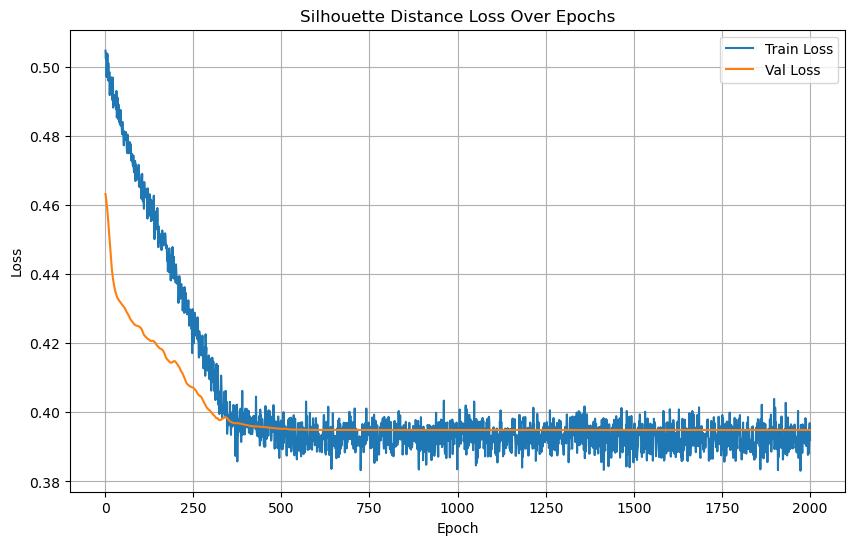

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/157], Loss: 0.3753
Test Batch [20/157], Loss: 0.3752
Test Batch [30/157], Loss: 0.3745


Test Batch [40/157], Loss: 0.4140
Test Batch [50/157], Loss: 0.4347
Test Batch [60/157], Loss: 0.4130


Test Batch [70/157], Loss: 0.1993
Test Batch [80/157], Loss: 0.2320
Test Batch [90/157], Loss: 0.2418
Test Batch [100/157], Loss: 0.2171
Test Batch [110/157], Loss: 0.2191


Test Batch [120/157], Loss: 0.2221
Test Batch [130/157], Loss: 0.1280
Test Batch [140/157], Loss: 0.4058
Test Batch [150/157], Loss: 0.3168



Test Loss: 0.3201


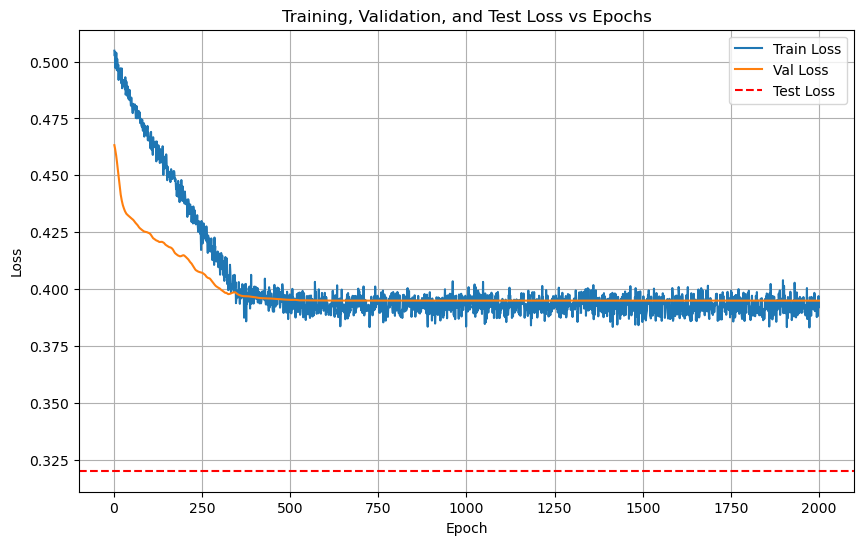

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/157 for test dataset.


  Processed batch 20/157 for test dataset.
  Processed batch 30/157 for test dataset.
  Processed batch 40/157 for test dataset.
  Processed batch 50/157 for test dataset.


  Processed batch 60/157 for test dataset.
  Processed batch 70/157 for test dataset.
  Processed batch 80/157 for test dataset.


  Processed batch 90/157 for test dataset.
  Processed batch 100/157 for test dataset.


  Processed batch 110/157 for test dataset.
  Processed batch 120/157 for test dataset.
  Processed batch 130/157 for test dataset.
  Processed batch 140/157 for test dataset.


  Processed batch 150/157 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         5
           3       0.75      0.60      0.67         5
           4       0.67      0.40      0.50         5
           5       0.60      0.60      0.60         5
           6       0.83      1.00      0.91         5
           7       0.60      0.60      0.60         5
           8       0.83      1.00      0.91         5
           9       0.50      0.60      0.55         5
          10       0.67      0.80      0.73         5
          11       0.50      0.60      0.55         5
          12       0.56      1.00      0.71         5
          13       0.5

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8094  |  Val Loss: 2.8568
Validation loss improved from inf to 2.8568.
[Epoch 2/1000] Train Loss: 2.7908  |  Val Loss: 2.8429
Validation loss improved from 2.8568 to 2.8429.
[Epoch 3/1000] Train Loss: 2.7754  |  Val Loss: 2.8292
Validation loss improved from 2.8429 to 2.8292.
[Epoch 4/1000] Train Loss: 2.7593  |  Val Loss: 2.8161
Validation loss improved from 2.8292 to 2.8161.
[Epoch 5/1000] Train Loss: 2.7441  |  Val Loss: 2.8034
Validation loss improved from 2.8161 to 2.8034.
[Epoch 6/1000] Train Loss: 2.7295  |  Val Loss: 2.7911
Validation loss improved from 2.8034 to 2.7911.
[Epoch 7/1000] Train Loss: 2.7151  |  Val Loss: 2.7791
Validation loss improved from 2.7911 to 2.7791.
[Epoch 8/1000] Train Loss: 2.7012  |  Val Loss: 2.7680
Validation loss improved from 2.7791 to 2.7680.
[Epoch 9/1000] Train Loss: 2.6884  |  Val Loss: 2.7575
Validation loss improved from 2.7680 to 2.7575.
[Epoch 10/1000] Train Loss: 2.6749  |  Val Loss: 2.7475
Validation loss impr

[Epoch 11/1000] Train Loss: 2.6621  |  Val Loss: 2.7382
Validation loss improved from 2.7475 to 2.7382.
[Epoch 12/1000] Train Loss: 2.6500  |  Val Loss: 2.7292
Validation loss improved from 2.7382 to 2.7292.
[Epoch 13/1000] Train Loss: 2.6379  |  Val Loss: 2.7209
Validation loss improved from 2.7292 to 2.7209.
[Epoch 14/1000] Train Loss: 2.6262  |  Val Loss: 2.7127
Validation loss improved from 2.7209 to 2.7127.
[Epoch 15/1000] Train Loss: 2.6139  |  Val Loss: 2.7045
Validation loss improved from 2.7127 to 2.7045.
[Epoch 16/1000] Train Loss: 2.6026  |  Val Loss: 2.6967
Validation loss improved from 2.7045 to 2.6967.
[Epoch 17/1000] Train Loss: 2.5906  |  Val Loss: 2.6891
Validation loss improved from 2.6967 to 2.6891.
[Epoch 18/1000] Train Loss: 2.5797  |  Val Loss: 2.6815
Validation loss improved from 2.6891 to 2.6815.
[Epoch 19/1000] Train Loss: 2.5686  |  Val Loss: 2.6741
Validation loss improved from 2.6815 to 2.6741.
[Epoch 20/1000] Train Loss: 2.5580  |  Val Loss: 2.6669
Validati

[Epoch 27/1000] Train Loss: 2.4859  |  Val Loss: 2.6182
Validation loss improved from 2.6248 to 2.6182.
[Epoch 28/1000] Train Loss: 2.4770  |  Val Loss: 2.6115
Validation loss improved from 2.6182 to 2.6115.
[Epoch 29/1000] Train Loss: 2.4667  |  Val Loss: 2.6047
Validation loss improved from 2.6115 to 2.6047.
[Epoch 30/1000] Train Loss: 2.4571  |  Val Loss: 2.5979
Validation loss improved from 2.6047 to 2.5979.
[Epoch 31/1000] Train Loss: 2.4469  |  Val Loss: 2.5912
Validation loss improved from 2.5979 to 2.5912.


[Epoch 32/1000] Train Loss: 2.4371  |  Val Loss: 2.5842
Validation loss improved from 2.5912 to 2.5842.
[Epoch 33/1000] Train Loss: 2.4275  |  Val Loss: 2.5772
Validation loss improved from 2.5842 to 2.5772.
[Epoch 34/1000] Train Loss: 2.4172  |  Val Loss: 2.5702
Validation loss improved from 2.5772 to 2.5702.
[Epoch 35/1000] Train Loss: 2.4074  |  Val Loss: 2.5630
Validation loss improved from 2.5702 to 2.5630.
[Epoch 36/1000] Train Loss: 2.3975  |  Val Loss: 2.5559
Validation loss improved from 2.5630 to 2.5559.
[Epoch 37/1000] Train Loss: 2.3876  |  Val Loss: 2.5485
Validation loss improved from 2.5559 to 2.5485.
[Epoch 38/1000] Train Loss: 2.3774  |  Val Loss: 2.5411
Validation loss improved from 2.5485 to 2.5411.
[Epoch 39/1000] Train Loss: 2.3673  |  Val Loss: 2.5337
Validation loss improved from 2.5411 to 2.5337.
[Epoch 40/1000] Train Loss: 2.3570  |  Val Loss: 2.5261
Validation loss improved from 2.5337 to 2.5261.
[Epoch 41/1000] Train Loss: 2.3464  |  Val Loss: 2.5184
Validati

[Epoch 42/1000] Train Loss: 2.3362  |  Val Loss: 2.5107
Validation loss improved from 2.5184 to 2.5107.
[Epoch 43/1000] Train Loss: 2.3258  |  Val Loss: 2.5033
Validation loss improved from 2.5107 to 2.5033.
[Epoch 44/1000] Train Loss: 2.3153  |  Val Loss: 2.4956
Validation loss improved from 2.5033 to 2.4956.
[Epoch 45/1000] Train Loss: 2.3049  |  Val Loss: 2.4883
Validation loss improved from 2.4956 to 2.4883.
[Epoch 46/1000] Train Loss: 2.2943  |  Val Loss: 2.4809
Validation loss improved from 2.4883 to 2.4809.
[Epoch 47/1000] Train Loss: 2.2842  |  Val Loss: 2.4733
Validation loss improved from 2.4809 to 2.4733.
[Epoch 48/1000] Train Loss: 2.2730  |  Val Loss: 2.4657
Validation loss improved from 2.4733 to 2.4657.
[Epoch 49/1000] Train Loss: 2.2625  |  Val Loss: 2.4580
Validation loss improved from 2.4657 to 2.4580.
[Epoch 50/1000] Train Loss: 2.2525  |  Val Loss: 2.4503
Validation loss improved from 2.4580 to 2.4503.
[Epoch 51/1000] Train Loss: 2.2417  |  Val Loss: 2.4429
Validati

[Epoch 56/1000] Train Loss: 2.1891  |  Val Loss: 2.4067
Validation loss improved from 2.4137 to 2.4067.
[Epoch 57/1000] Train Loss: 2.1788  |  Val Loss: 2.3995
Validation loss improved from 2.4067 to 2.3995.
[Epoch 58/1000] Train Loss: 2.1685  |  Val Loss: 2.3922
Validation loss improved from 2.3995 to 2.3922.
[Epoch 59/1000] Train Loss: 2.1579  |  Val Loss: 2.3850
Validation loss improved from 2.3922 to 2.3850.
[Epoch 60/1000] Train Loss: 2.1474  |  Val Loss: 2.3778
Validation loss improved from 2.3850 to 2.3778.
[Epoch 61/1000] Train Loss: 2.1373  |  Val Loss: 2.3706
Validation loss improved from 2.3778 to 2.3706.


[Epoch 62/1000] Train Loss: 2.1265  |  Val Loss: 2.3635
Validation loss improved from 2.3706 to 2.3635.
[Epoch 63/1000] Train Loss: 2.1160  |  Val Loss: 2.3562
Validation loss improved from 2.3635 to 2.3562.
[Epoch 64/1000] Train Loss: 2.1054  |  Val Loss: 2.3489
Validation loss improved from 2.3562 to 2.3489.
[Epoch 65/1000] Train Loss: 2.0948  |  Val Loss: 2.3417
Validation loss improved from 2.3489 to 2.3417.
[Epoch 66/1000] Train Loss: 2.0841  |  Val Loss: 2.3344
Validation loss improved from 2.3417 to 2.3344.
[Epoch 67/1000] Train Loss: 2.0735  |  Val Loss: 2.3270
Validation loss improved from 2.3344 to 2.3270.
[Epoch 68/1000] Train Loss: 2.0626  |  Val Loss: 2.3198
Validation loss improved from 2.3270 to 2.3198.
[Epoch 69/1000] Train Loss: 2.0518  |  Val Loss: 2.3126
Validation loss improved from 2.3198 to 2.3126.
[Epoch 70/1000] Train Loss: 2.0411  |  Val Loss: 2.3057
Validation loss improved from 2.3126 to 2.3057.
[Epoch 71/1000] Train Loss: 2.0302  |  Val Loss: 2.2985
Validati

[Epoch 72/1000] Train Loss: 2.0193  |  Val Loss: 2.2909
Validation loss improved from 2.2985 to 2.2909.
[Epoch 73/1000] Train Loss: 2.0086  |  Val Loss: 2.2831
Validation loss improved from 2.2909 to 2.2831.
[Epoch 74/1000] Train Loss: 1.9975  |  Val Loss: 2.2752
Validation loss improved from 2.2831 to 2.2752.
[Epoch 75/1000] Train Loss: 1.9866  |  Val Loss: 2.2675
Validation loss improved from 2.2752 to 2.2675.
[Epoch 76/1000] Train Loss: 1.9754  |  Val Loss: 2.2597
Validation loss improved from 2.2675 to 2.2597.
[Epoch 77/1000] Train Loss: 1.9646  |  Val Loss: 2.2521
Validation loss improved from 2.2597 to 2.2521.
[Epoch 78/1000] Train Loss: 1.9537  |  Val Loss: 2.2444
Validation loss improved from 2.2521 to 2.2444.
[Epoch 79/1000] Train Loss: 1.9426  |  Val Loss: 2.2367
Validation loss improved from 2.2444 to 2.2367.
[Epoch 80/1000] Train Loss: 1.9315  |  Val Loss: 2.2292
Validation loss improved from 2.2367 to 2.2292.
[Epoch 81/1000] Train Loss: 1.9203  |  Val Loss: 2.2214
Validati

[Epoch 87/1000] Train Loss: 1.8525  |  Val Loss: 2.1738
Validation loss improved from 2.1816 to 2.1738.
[Epoch 88/1000] Train Loss: 1.8414  |  Val Loss: 2.1658
Validation loss improved from 2.1738 to 2.1658.
[Epoch 89/1000] Train Loss: 1.8300  |  Val Loss: 2.1580
Validation loss improved from 2.1658 to 2.1580.
[Epoch 90/1000] Train Loss: 1.8187  |  Val Loss: 2.1502
Validation loss improved from 2.1580 to 2.1502.
[Epoch 91/1000] Train Loss: 1.8075  |  Val Loss: 2.1422
Validation loss improved from 2.1502 to 2.1422.
[Epoch 92/1000] Train Loss: 1.7961  |  Val Loss: 2.1346
Validation loss improved from 2.1422 to 2.1346.
[Epoch 93/1000] Train Loss: 1.7847  |  Val Loss: 2.1269
Validation loss improved from 2.1346 to 2.1269.
[Epoch 94/1000] Train Loss: 1.7735  |  Val Loss: 2.1192
Validation loss improved from 2.1269 to 2.1192.
[Epoch 95/1000] Train Loss: 1.7621  |  Val Loss: 2.1114
Validation loss improved from 2.1192 to 2.1114.


[Epoch 96/1000] Train Loss: 1.7511  |  Val Loss: 2.1036
Validation loss improved from 2.1114 to 2.1036.
[Epoch 97/1000] Train Loss: 1.7397  |  Val Loss: 2.0956
Validation loss improved from 2.1036 to 2.0956.
[Epoch 98/1000] Train Loss: 1.7286  |  Val Loss: 2.0876
Validation loss improved from 2.0956 to 2.0876.
[Epoch 99/1000] Train Loss: 1.7176  |  Val Loss: 2.0793
Validation loss improved from 2.0876 to 2.0793.
[Epoch 100/1000] Train Loss: 1.7062  |  Val Loss: 2.0714
Validation loss improved from 2.0793 to 2.0714.
[Epoch 101/1000] Train Loss: 1.6944  |  Val Loss: 2.0634
Validation loss improved from 2.0714 to 2.0634.
[Epoch 102/1000] Train Loss: 1.6833  |  Val Loss: 2.0555
Validation loss improved from 2.0634 to 2.0555.
[Epoch 103/1000] Train Loss: 1.6720  |  Val Loss: 2.0474
Validation loss improved from 2.0555 to 2.0474.


[Epoch 104/1000] Train Loss: 1.6610  |  Val Loss: 2.0395
Validation loss improved from 2.0474 to 2.0395.
[Epoch 105/1000] Train Loss: 1.6491  |  Val Loss: 2.0319
Validation loss improved from 2.0395 to 2.0319.
[Epoch 106/1000] Train Loss: 1.6380  |  Val Loss: 2.0244
Validation loss improved from 2.0319 to 2.0244.
[Epoch 107/1000] Train Loss: 1.6267  |  Val Loss: 2.0167
Validation loss improved from 2.0244 to 2.0167.
[Epoch 108/1000] Train Loss: 1.6152  |  Val Loss: 2.0090
Validation loss improved from 2.0167 to 2.0090.
[Epoch 109/1000] Train Loss: 1.6038  |  Val Loss: 2.0014
Validation loss improved from 2.0090 to 2.0014.
[Epoch 110/1000] Train Loss: 1.5926  |  Val Loss: 1.9940
Validation loss improved from 2.0014 to 1.9940.
[Epoch 111/1000] Train Loss: 1.5809  |  Val Loss: 1.9862
Validation loss improved from 1.9940 to 1.9862.
[Epoch 112/1000] Train Loss: 1.5698  |  Val Loss: 1.9785
Validation loss improved from 1.9862 to 1.9785.
[Epoch 113/1000] Train Loss: 1.5581  |  Val Loss: 1.970

[Epoch 116/1000] Train Loss: 1.5238  |  Val Loss: 1.9471
Validation loss improved from 1.9548 to 1.9471.
[Epoch 117/1000] Train Loss: 1.5127  |  Val Loss: 1.9397
Validation loss improved from 1.9471 to 1.9397.
[Epoch 118/1000] Train Loss: 1.5011  |  Val Loss: 1.9319
Validation loss improved from 1.9397 to 1.9319.
[Epoch 119/1000] Train Loss: 1.4898  |  Val Loss: 1.9244
Validation loss improved from 1.9319 to 1.9244.
[Epoch 120/1000] Train Loss: 1.4786  |  Val Loss: 1.9168
Validation loss improved from 1.9244 to 1.9168.
[Epoch 121/1000] Train Loss: 1.4672  |  Val Loss: 1.9091
Validation loss improved from 1.9168 to 1.9091.


[Epoch 122/1000] Train Loss: 1.4563  |  Val Loss: 1.9016
Validation loss improved from 1.9091 to 1.9016.
[Epoch 123/1000] Train Loss: 1.4452  |  Val Loss: 1.8941
Validation loss improved from 1.9016 to 1.8941.
[Epoch 124/1000] Train Loss: 1.4339  |  Val Loss: 1.8866
Validation loss improved from 1.8941 to 1.8866.
[Epoch 125/1000] Train Loss: 1.4229  |  Val Loss: 1.8790
Validation loss improved from 1.8866 to 1.8790.
[Epoch 126/1000] Train Loss: 1.4116  |  Val Loss: 1.8717
Validation loss improved from 1.8790 to 1.8717.
[Epoch 127/1000] Train Loss: 1.4007  |  Val Loss: 1.8643
Validation loss improved from 1.8717 to 1.8643.
[Epoch 128/1000] Train Loss: 1.3897  |  Val Loss: 1.8568
Validation loss improved from 1.8643 to 1.8568.
[Epoch 129/1000] Train Loss: 1.3786  |  Val Loss: 1.8498
Validation loss improved from 1.8568 to 1.8498.
[Epoch 130/1000] Train Loss: 1.3675  |  Val Loss: 1.8424
Validation loss improved from 1.8498 to 1.8424.


[Epoch 131/1000] Train Loss: 1.3570  |  Val Loss: 1.8347
Validation loss improved from 1.8424 to 1.8347.
[Epoch 132/1000] Train Loss: 1.3457  |  Val Loss: 1.8272
Validation loss improved from 1.8347 to 1.8272.
[Epoch 133/1000] Train Loss: 1.3354  |  Val Loss: 1.8197
Validation loss improved from 1.8272 to 1.8197.
[Epoch 134/1000] Train Loss: 1.3244  |  Val Loss: 1.8121
Validation loss improved from 1.8197 to 1.8121.
[Epoch 135/1000] Train Loss: 1.3134  |  Val Loss: 1.8045
Validation loss improved from 1.8121 to 1.8045.
[Epoch 136/1000] Train Loss: 1.3027  |  Val Loss: 1.7969
Validation loss improved from 1.8045 to 1.7969.
[Epoch 137/1000] Train Loss: 1.2923  |  Val Loss: 1.7898
Validation loss improved from 1.7969 to 1.7898.
[Epoch 138/1000] Train Loss: 1.2813  |  Val Loss: 1.7826
Validation loss improved from 1.7898 to 1.7826.
[Epoch 139/1000] Train Loss: 1.2710  |  Val Loss: 1.7753
Validation loss improved from 1.7826 to 1.7753.
[Epoch 140/1000] Train Loss: 1.2603  |  Val Loss: 1.768

[Epoch 142/1000] Train Loss: 1.2395  |  Val Loss: 1.7553
Validation loss improved from 1.7619 to 1.7553.
[Epoch 143/1000] Train Loss: 1.2292  |  Val Loss: 1.7485
Validation loss improved from 1.7553 to 1.7485.
[Epoch 144/1000] Train Loss: 1.2188  |  Val Loss: 1.7419
Validation loss improved from 1.7485 to 1.7419.
[Epoch 145/1000] Train Loss: 1.2085  |  Val Loss: 1.7352
Validation loss improved from 1.7419 to 1.7352.
[Epoch 146/1000] Train Loss: 1.1983  |  Val Loss: 1.7289
Validation loss improved from 1.7352 to 1.7289.
[Epoch 147/1000] Train Loss: 1.1882  |  Val Loss: 1.7224
Validation loss improved from 1.7289 to 1.7224.


[Epoch 148/1000] Train Loss: 1.1780  |  Val Loss: 1.7162
Validation loss improved from 1.7224 to 1.7162.
[Epoch 149/1000] Train Loss: 1.1678  |  Val Loss: 1.7094
Validation loss improved from 1.7162 to 1.7094.
[Epoch 150/1000] Train Loss: 1.1576  |  Val Loss: 1.7029
Validation loss improved from 1.7094 to 1.7029.
[Epoch 151/1000] Train Loss: 1.1475  |  Val Loss: 1.6964
Validation loss improved from 1.7029 to 1.6964.
[Epoch 152/1000] Train Loss: 1.1376  |  Val Loss: 1.6894
Validation loss improved from 1.6964 to 1.6894.
[Epoch 153/1000] Train Loss: 1.1276  |  Val Loss: 1.6829
Validation loss improved from 1.6894 to 1.6829.
[Epoch 154/1000] Train Loss: 1.1176  |  Val Loss: 1.6761
Validation loss improved from 1.6829 to 1.6761.
[Epoch 155/1000] Train Loss: 1.1078  |  Val Loss: 1.6693
Validation loss improved from 1.6761 to 1.6693.
[Epoch 156/1000] Train Loss: 1.0978  |  Val Loss: 1.6629
Validation loss improved from 1.6693 to 1.6629.
[Epoch 157/1000] Train Loss: 1.0882  |  Val Loss: 1.656

[Epoch 159/1000] Train Loss: 1.0686  |  Val Loss: 1.6440
Validation loss improved from 1.6503 to 1.6440.
[Epoch 160/1000] Train Loss: 1.0589  |  Val Loss: 1.6378
Validation loss improved from 1.6440 to 1.6378.
[Epoch 161/1000] Train Loss: 1.0496  |  Val Loss: 1.6316
Validation loss improved from 1.6378 to 1.6316.
[Epoch 162/1000] Train Loss: 1.0400  |  Val Loss: 1.6255
Validation loss improved from 1.6316 to 1.6255.
[Epoch 163/1000] Train Loss: 1.0306  |  Val Loss: 1.6193
Validation loss improved from 1.6255 to 1.6193.
[Epoch 164/1000] Train Loss: 1.0211  |  Val Loss: 1.6135
Validation loss improved from 1.6193 to 1.6135.
[Epoch 165/1000] Train Loss: 1.0119  |  Val Loss: 1.6075
Validation loss improved from 1.6135 to 1.6075.
[Epoch 166/1000] Train Loss: 1.0024  |  Val Loss: 1.6015
Validation loss improved from 1.6075 to 1.6015.
[Epoch 167/1000] Train Loss: 0.9935  |  Val Loss: 1.5958
Validation loss improved from 1.6015 to 1.5958.
[Epoch 168/1000] Train Loss: 0.9841  |  Val Loss: 1.590

[Epoch 171/1000] Train Loss: 0.9572  |  Val Loss: 1.5729
Validation loss improved from 1.5783 to 1.5729.


[Epoch 172/1000] Train Loss: 0.9482  |  Val Loss: 1.5665
Validation loss improved from 1.5729 to 1.5665.
[Epoch 173/1000] Train Loss: 0.9396  |  Val Loss: 1.5608
Validation loss improved from 1.5665 to 1.5608.
[Epoch 174/1000] Train Loss: 0.9309  |  Val Loss: 1.5557
Validation loss improved from 1.5608 to 1.5557.
[Epoch 175/1000] Train Loss: 0.9221  |  Val Loss: 1.5505
Validation loss improved from 1.5557 to 1.5505.
[Epoch 176/1000] Train Loss: 0.9131  |  Val Loss: 1.5453
Validation loss improved from 1.5505 to 1.5453.
[Epoch 177/1000] Train Loss: 0.9051  |  Val Loss: 1.5401
Validation loss improved from 1.5453 to 1.5401.
[Epoch 178/1000] Train Loss: 0.8962  |  Val Loss: 1.5352
Validation loss improved from 1.5401 to 1.5352.
[Epoch 179/1000] Train Loss: 0.8878  |  Val Loss: 1.5300
Validation loss improved from 1.5352 to 1.5300.
[Epoch 180/1000] Train Loss: 0.8795  |  Val Loss: 1.5250
Validation loss improved from 1.5300 to 1.5250.
[Epoch 181/1000] Train Loss: 0.8711  |  Val Loss: 1.519

[Epoch 185/1000] Train Loss: 0.8389  |  Val Loss: 1.4994
Validation loss improved from 1.5041 to 1.4994.
[Epoch 186/1000] Train Loss: 0.8310  |  Val Loss: 1.4953
Validation loss improved from 1.4994 to 1.4953.
[Epoch 187/1000] Train Loss: 0.8231  |  Val Loss: 1.4911
Validation loss improved from 1.4953 to 1.4911.
[Epoch 188/1000] Train Loss: 0.8154  |  Val Loss: 1.4872
Validation loss improved from 1.4911 to 1.4872.
[Epoch 189/1000] Train Loss: 0.8082  |  Val Loss: 1.4836
Validation loss improved from 1.4872 to 1.4836.
[Epoch 190/1000] Train Loss: 0.8004  |  Val Loss: 1.4796
Validation loss improved from 1.4836 to 1.4796.
[Epoch 191/1000] Train Loss: 0.7930  |  Val Loss: 1.4754
Validation loss improved from 1.4796 to 1.4754.
[Epoch 192/1000] Train Loss: 0.7855  |  Val Loss: 1.4720
Validation loss improved from 1.4754 to 1.4720.
[Epoch 193/1000] Train Loss: 0.7781  |  Val Loss: 1.4692
Validation loss improved from 1.4720 to 1.4692.
[Epoch 194/1000] Train Loss: 0.7714  |  Val Loss: 1.466

[Epoch 199/1000] Train Loss: 0.7362  |  Val Loss: 1.4509
Validation loss improved from 1.4539 to 1.4509.
[Epoch 200/1000] Train Loss: 0.7299  |  Val Loss: 1.4479
Validation loss improved from 1.4509 to 1.4479.
[Epoch 201/1000] Train Loss: 0.7230  |  Val Loss: 1.4457
Validation loss improved from 1.4479 to 1.4457.
[Epoch 202/1000] Train Loss: 0.7166  |  Val Loss: 1.4432
Validation loss improved from 1.4457 to 1.4432.
[Epoch 203/1000] Train Loss: 0.7103  |  Val Loss: 1.4404
Validation loss improved from 1.4432 to 1.4404.
[Epoch 204/1000] Train Loss: 0.7039  |  Val Loss: 1.4375
Validation loss improved from 1.4404 to 1.4375.
[Epoch 205/1000] Train Loss: 0.6974  |  Val Loss: 1.4347
Validation loss improved from 1.4375 to 1.4347.
[Epoch 206/1000] Train Loss: 0.6915  |  Val Loss: 1.4322
Validation loss improved from 1.4347 to 1.4322.
[Epoch 207/1000] Train Loss: 0.6854  |  Val Loss: 1.4299
Validation loss improved from 1.4322 to 1.4299.
[Epoch 208/1000] Train Loss: 0.6794  |  Val Loss: 1.427

[Epoch 218/1000] Train Loss: 0.6233  |  Val Loss: 1.4103
Validation loss improved from 1.4124 to 1.4103.
[Epoch 219/1000] Train Loss: 0.6180  |  Val Loss: 1.4083
Validation loss improved from 1.4103 to 1.4083.
[Epoch 220/1000] Train Loss: 0.6133  |  Val Loss: 1.4064
Validation loss improved from 1.4083 to 1.4064.
[Epoch 221/1000] Train Loss: 0.6078  |  Val Loss: 1.4052
Validation loss improved from 1.4064 to 1.4052.
[Epoch 222/1000] Train Loss: 0.6027  |  Val Loss: 1.4048
Validation loss improved from 1.4052 to 1.4048.
[Epoch 223/1000] Train Loss: 0.5980  |  Val Loss: 1.4045
Validation loss improved from 1.4048 to 1.4045.
[Epoch 224/1000] Train Loss: 0.5931  |  Val Loss: 1.4033
Validation loss improved from 1.4045 to 1.4033.
[Epoch 225/1000] Train Loss: 0.5884  |  Val Loss: 1.4024
Validation loss improved from 1.4033 to 1.4024.
[Epoch 226/1000] Train Loss: 0.5837  |  Val Loss: 1.4016
Validation loss improved from 1.4024 to 1.4016.


[Epoch 227/1000] Train Loss: 0.5790  |  Val Loss: 1.4010
Validation loss improved from 1.4016 to 1.4010.
[Epoch 228/1000] Train Loss: 0.5746  |  Val Loss: 1.4003
Validation loss improved from 1.4010 to 1.4003.
[Epoch 229/1000] Train Loss: 0.5701  |  Val Loss: 1.3993
Validation loss improved from 1.4003 to 1.3993.
[Epoch 230/1000] Train Loss: 0.5655  |  Val Loss: 1.3989
Validation loss improved from 1.3993 to 1.3989.
[Epoch 231/1000] Train Loss: 0.5615  |  Val Loss: 1.3979
Validation loss improved from 1.3989 to 1.3979.
[Epoch 232/1000] Train Loss: 0.5569  |  Val Loss: 1.3972
Validation loss improved from 1.3979 to 1.3972.
[Epoch 233/1000] Train Loss: 0.5529  |  Val Loss: 1.3960
Validation loss improved from 1.3972 to 1.3960.
[Epoch 234/1000] Train Loss: 0.5485  |  Val Loss: 1.3955
Validation loss improved from 1.3960 to 1.3955.
[Epoch 235/1000] Train Loss: 0.5442  |  Val Loss: 1.3952
Validation loss improved from 1.3955 to 1.3952.
[Epoch 236/1000] Train Loss: 0.5400  |  Val Loss: 1.395

[Epoch 246/1000] Train Loss: 0.5021  |  Val Loss: 1.3992
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 247/1000] Train Loss: 0.4986  |  Val Loss: 1.3991
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 248/1000] Train Loss: 0.4951  |  Val Loss: 1.3993
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 249/1000] Train Loss: 0.4916  |  Val Loss: 1.3998
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 250/1000] Train Loss: 0.4882  |  Val Loss: 1.3991
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 251/1000] Train Loss: 0.4847  |  Val Loss: 1.3996
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 252/1000] Train Loss: 0.4814  |  Val Loss: 1.3997
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 253/1000] Train Loss: 0.4783  |  Val Loss: 1.3997
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 254/1000] Train Loss: 0.4751  |  Val Loss: 1.4007
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.4653  |  Val Loss: 1.4023
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 258/1000] Train Loss: 0.4624  |  Val Loss: 1.4026
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 259/1000] Train Loss: 0.4592  |  Val Loss: 1.4037
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 260/1000] Train Loss: 0.4560  |  Val Loss: 1.4051
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 261/1000] Train Loss: 0.4530  |  Val Loss: 1.4064
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 262/1000] Train Loss: 0.4498  |  Val Loss: 1.4073
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 263/1000] Train Loss: 0.4470  |  Val Loss: 1.4075
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 264/1000] Train Loss: 0.4440  |  Val Loss: 1.4087
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 265/1000] Train Loss: 0.4411  |  Val Loss: 1.4094
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 0.4088  |  Val Loss: 1.4270
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 278/1000] Train Loss: 0.4064  |  Val Loss: 1.4289
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 279/1000] Train Loss: 0.4038  |  Val Loss: 1.4315
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 280/1000] Train Loss: 0.4013  |  Val Loss: 1.4339
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 281/1000] Train Loss: 0.3989  |  Val Loss: 1.4362
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 282/1000] Train Loss: 0.3965  |  Val Loss: 1.4390
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 283/1000] Train Loss: 0.3940  |  Val Loss: 1.4418
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 284/1000] Train Loss: 0.3916  |  Val Loss: 1.4443
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 285/1000] Train Loss: 0.3890  |  Val Loss: 1.4463
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 0.3818  |  Val Loss: 1.4529
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 289/1000] Train Loss: 0.3795  |  Val Loss: 1.4552
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 290/1000] Train Loss: 0.3774  |  Val Loss: 1.4577
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 291/1000] Train Loss: 0.3750  |  Val Loss: 1.4600
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 292/1000] Train Loss: 0.3728  |  Val Loss: 1.4612
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 293/1000] Train Loss: 0.3706  |  Val Loss: 1.4627
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 294/1000] Train Loss: 0.3686  |  Val Loss: 1.4638
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 295/1000] Train Loss: 0.3661  |  Val Loss: 1.4654
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 296/1000] Train Loss: 0.3639  |  Val Loss: 1.4666
!! Validation loss did NOT improve !! Patience:

[Epoch 305/1000] Train Loss: 0.3450  |  Val Loss: 1.4832
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 306/1000] Train Loss: 0.3428  |  Val Loss: 1.4861
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 307/1000] Train Loss: 0.3411  |  Val Loss: 1.4889
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 308/1000] Train Loss: 0.3390  |  Val Loss: 1.4921
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 309/1000] Train Loss: 0.3371  |  Val Loss: 1.4955
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 310/1000] Train Loss: 0.3351  |  Val Loss: 1.4986
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 311/1000] Train Loss: 0.3331  |  Val Loss: 1.5013
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 312/1000] Train Loss: 0.3316  |  Val Loss: 1.5045
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 313/1000] Train Loss: 0.3297  |  Val Loss: 1.5079
!! Validation loss did NOT improve !! Patience:

[Epoch 315/1000] Train Loss: 0.3258  |  Val Loss: 1.5132
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 316/1000] Train Loss: 0.3242  |  Val Loss: 1.5150
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 317/1000] Train Loss: 0.3225  |  Val Loss: 1.5176
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 318/1000] Train Loss: 0.3206  |  Val Loss: 1.5203
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 319/1000] Train Loss: 0.3190  |  Val Loss: 1.5226
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 320/1000] Train Loss: 0.3171  |  Val Loss: 1.5255
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 321/1000] Train Loss: 0.3157  |  Val Loss: 1.5284
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 322/1000] Train Loss: 0.3137  |  Val Loss: 1.5317
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 323/1000] Train Loss: 0.3121  |  Val Loss: 1.5341
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 0.2948  |  Val Loss: 1.5653
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 335/1000] Train Loss: 0.2934  |  Val Loss: 1.5684
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 336/1000] Train Loss: 0.2918  |  Val Loss: 1.5709
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 336 !!
No improvement for 100 epochs.


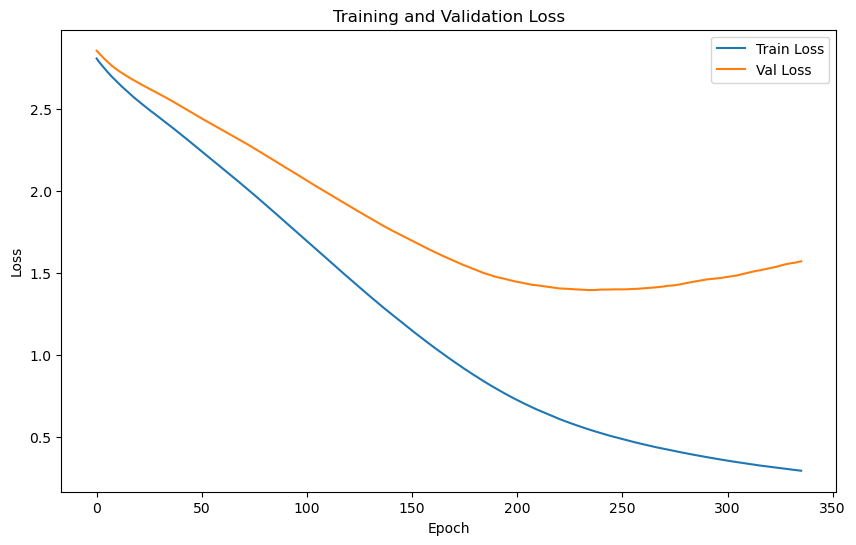

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.9128 | Test Accuracy: 52.07%


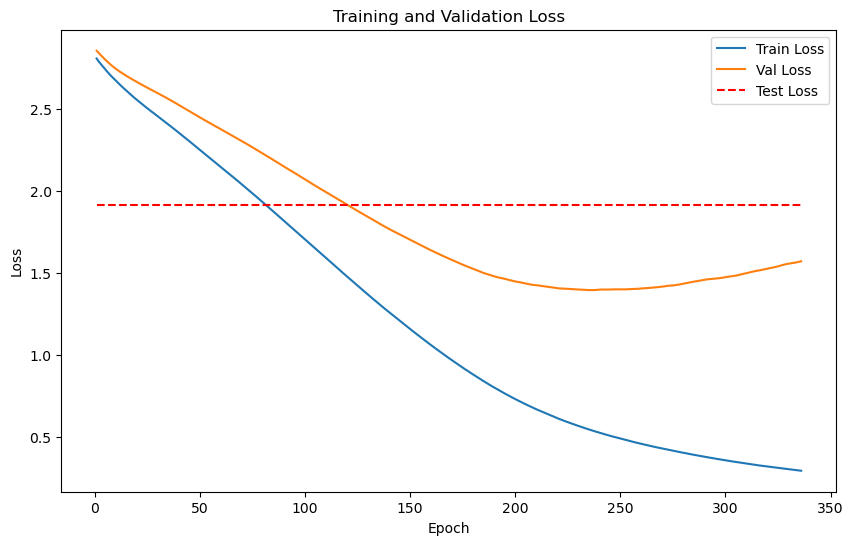

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


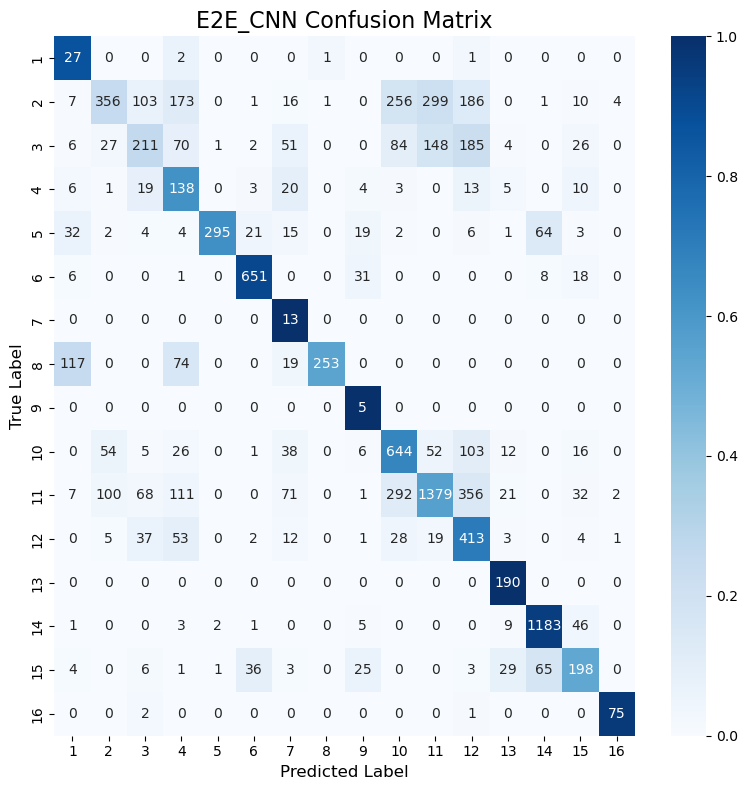

Classification Accuracy: 60.26%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


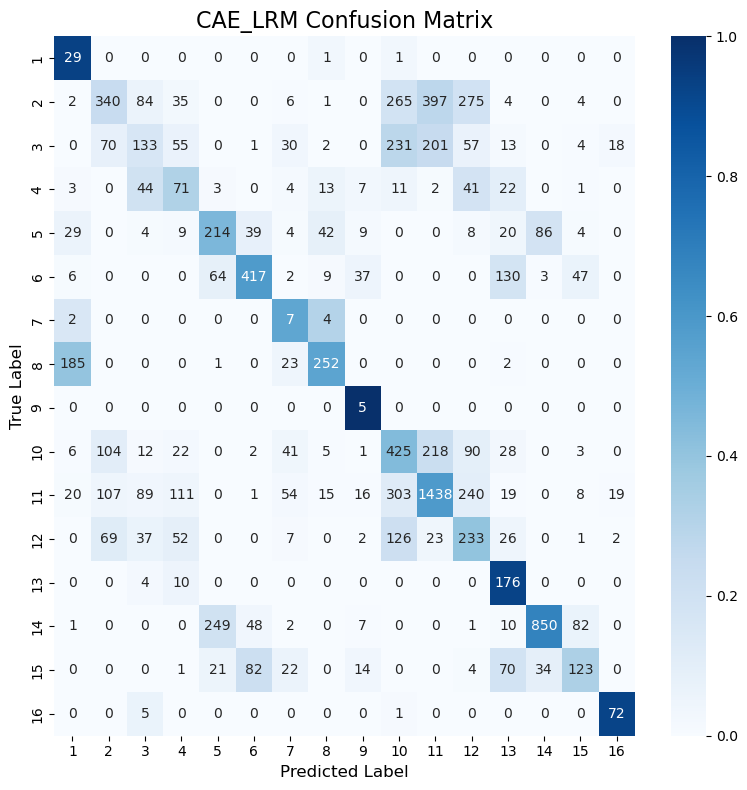

Classification Accuracy: 47.81%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


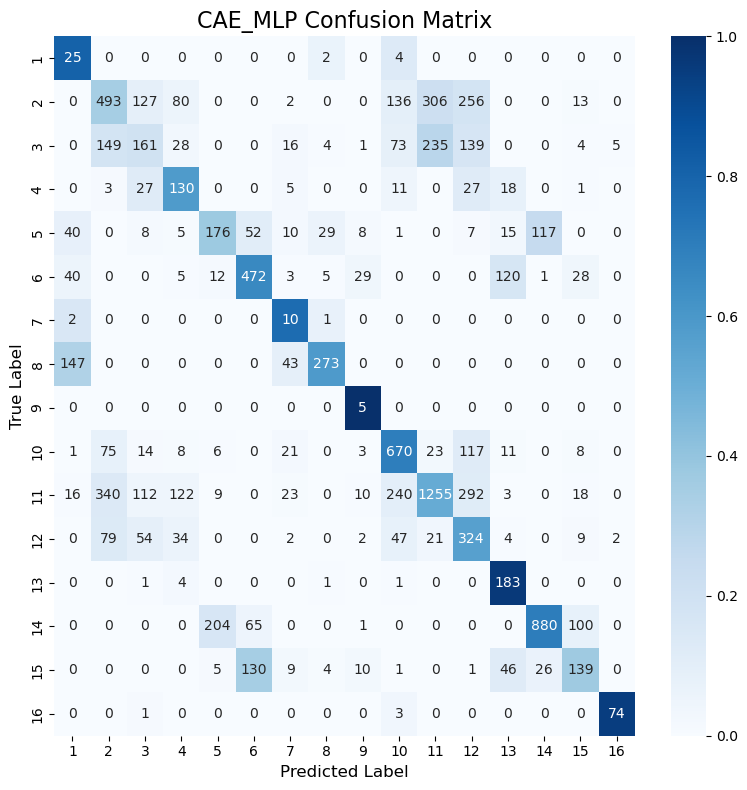

Classification Accuracy: 52.65%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


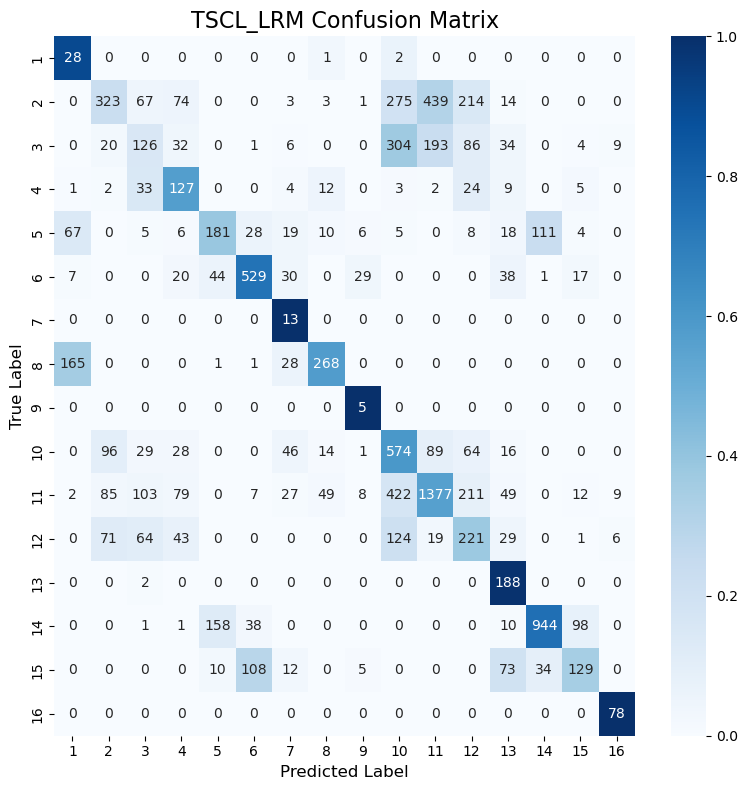

Classification Accuracy: 51.06%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


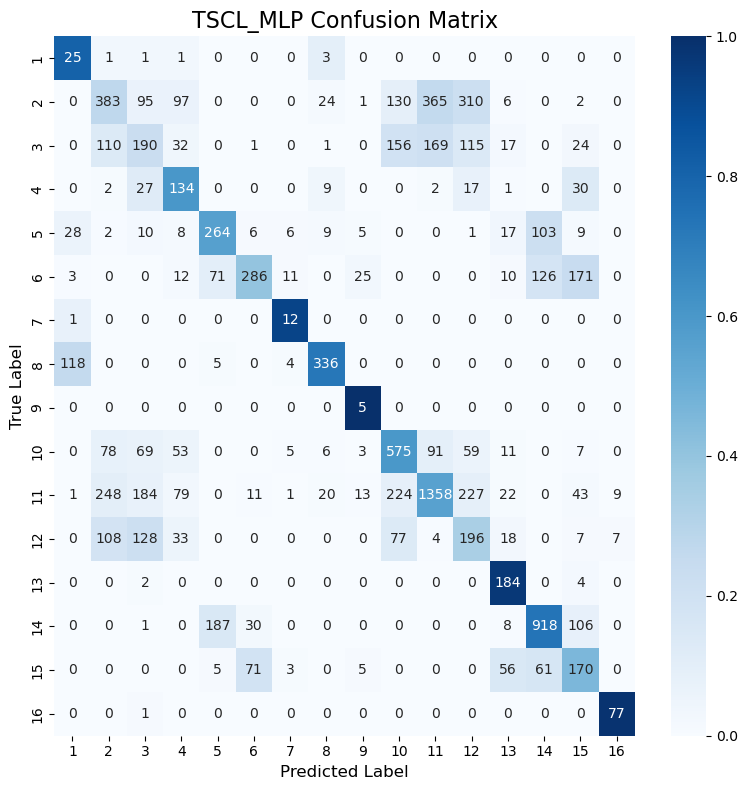

Classification Accuracy: 51.08%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


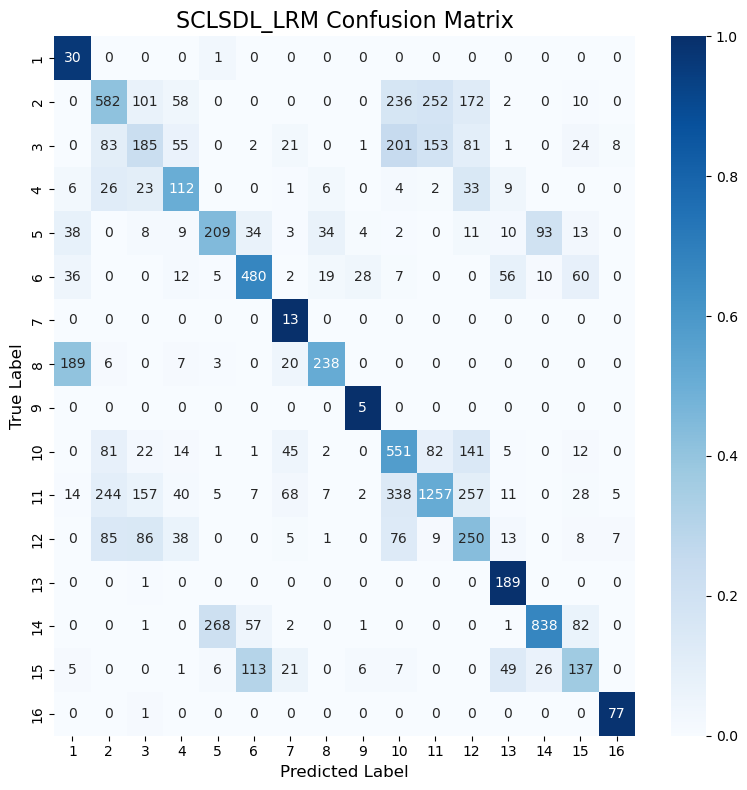

Classification Accuracy: 51.48%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


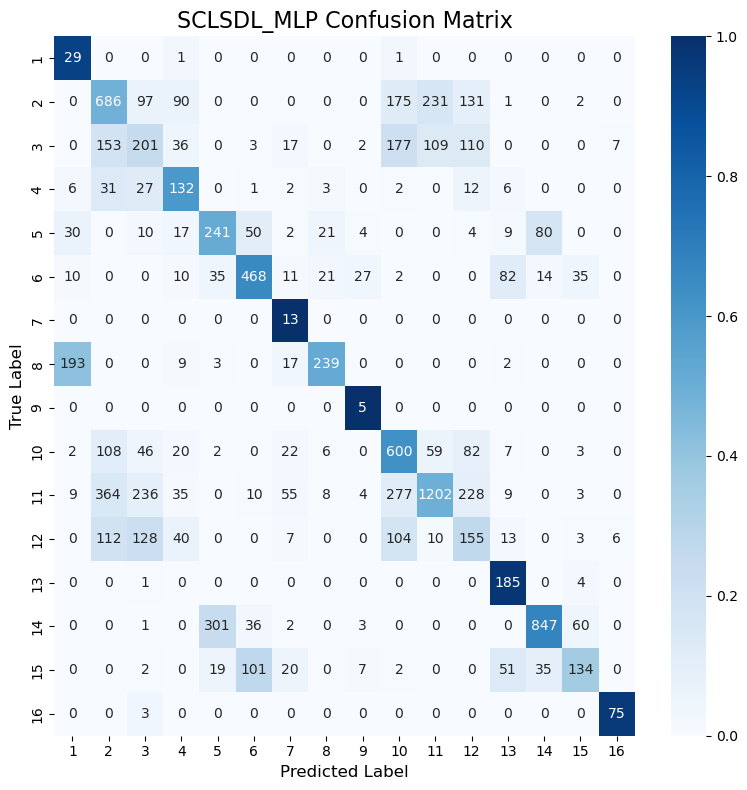

Classification Accuracy: 52.07%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          60.26
1    LRM (CAE)          47.81
2    MLP (CAE)          52.65
3     TSCL LRM          51.06
4     TSCL MLP          51.08
5  SCL_SDL LRM          51.48
6  SCL_SDL MLP          52.07

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          60.26
2    MLP (CAE)          52.65
6  SCL_SDL MLP          52.07
5  SCL_SDL LRM          51.48
4     TSCL MLP          51.08
3     TSCL LRM          51.06
1    LRM (CAE)          47.81
